In [1]:
#from mpl_toolkits.basemap import Basemap, cm
import os.path
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import pyart
from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import pyart
import numpy as np
import numpy.ma as ma
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dry_lapse, moist_lapse, vapor_pressure, saturation_vapor_pressure,
                        wind_speed, wind_direction, pressure_to_height_std, mixing_ratio, cape_cin, wind_components,
                        height_to_pressure_std, equivalent_potential_temperature, parcel_profile, precipitable_water,
                        storm_relative_helicity, mean_pressure_weighted, most_unstable_cape_cin, most_unstable_parcel,
                        supercell_composite, significant_tornado, get_layer, relative_humidity_from_dewpoint)
from metpy.calc import dewpoint_from_relative_humidity as dewpoint_rh
from metpy.calc.tools import get_layer, get_layer_heights
from metpy.calc import wind_direction
from metpy.units import units
from metpy.calc import lcl
import metpy.calc as metcalc
from metpy.interpolate import interpolate_1d as metinterp
from metpy.interpolate import log_interpolate_1d as log_interp
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
from metpy.plots import SkewT
from metpy.plots import Hodograph
import metpy.calc as mpcalc

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import pickle
import csv

from scipy import stats
import matplotlib.lines as mlines


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\setuptools\_distutils\version

In [2]:
# MIT License

# Copyright (c) 2017 thunderhoser

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import numpy
from scipy.interpolate import interp1d


def _run_pmm_one_variable(
        input_matrix, max_percentile_level=100):
    """Applies PMM to one variable.
    E = number of examples (realizations over which to average)
    :param input_matrix: numpy array.  The first axis must have length E.  Other
        axes are assumed to be spatial dimensions.  Thus, input_matrix[i, ...]
        is the spatial field for the [i]th example.
    :param max_percentile_level: Maximum percentile.  No output value will
        exceed the [q]th percentile of `input_matrix`, where q =
        `max_percentile_level`.  Similarly, no output value will be less than
        the [100 - q]th percentile of `input_matrix`.
    :return: mean_field_matrix: numpy array of probability-matched means.  Will
        have the same dimensions as `input_matrix`, except without the first
        axis.  For example, if `input_matrix` is E x 32 x 32 x 12, this will be
        32 x 32 x 12.
    """

    # Pool values over all dimensions and remove extremes.
    pooled_values = numpy.ravel(input_matrix)
    pooled_values = numpy.sort(pooled_values)

    max_pooled_value = numpy.percentile(pooled_values, max_percentile_level)
    pooled_values = pooled_values[pooled_values <= max_pooled_value]

    min_pooled_value = numpy.percentile(
        pooled_values, 100 - max_percentile_level)
    pooled_values = pooled_values[pooled_values >= min_pooled_value]

    # Find ensemble mean at each grid point.
    mean_field_matrix = numpy.mean(input_matrix, axis=0)
    mean_field_flattened = numpy.ravel(mean_field_matrix)

    # At each grid point, replace ensemble mean with the same percentile from
    # pooled array.
    pooled_value_percentiles = numpy.linspace(
        0, 100, num=len(pooled_values), dtype=float)
    mean_value_percentiles = numpy.linspace(
        0, 100, num=len(mean_field_flattened), dtype=float)

    sort_indices = numpy.argsort(mean_field_flattened)
    unsort_indices = numpy.argsort(sort_indices)

    interp_object = interp1d(
        pooled_value_percentiles, pooled_values, kind='linear',
        bounds_error=True, assume_sorted=True)

    mean_field_flattened = interp_object(mean_value_percentiles)
    mean_field_flattened = mean_field_flattened[unsort_indices]
    mean_field_matrix = numpy.reshape(
        mean_field_flattened, mean_field_matrix.shape)

    return mean_field_matrix

In [3]:
#Read in the sounding data from the spreadsheet
#Bring in the sounding data
CIsoundings=np.genfromtxt('SupercellSoundings/environment_cicases_Final.csv',skip_header=1,delimiter=',', dtype=str)
Oldsoundings=np.genfromtxt('SupercellSoundings/environment_Oldcases.csv',delimiter=',', dtype=str)
# ETsoundings=np.genfromtxt('PythonEnvVars1.csv', skip_header=1,delimiter=',')
# ETsoundings[ETsoundings==-9999]=np.nan

NewSoundings=np.genfromtxt('SupercellSoundingsNew/environment_cicases1022.csv', delimiter=',', dtype=str)

TORsondes = pickle.load(open('TORsondes.pkl', 'rb'))
NTORsondes = pickle.load(open('NTORsondes.pkl', 'rb'))
ETORsondes = pickle.load(open('ETORsondes.pkl', 'rb'))
ENTORsondes = pickle.load(open('ENTORsondes.pkl', 'rb'))
TTorsondes = pickle.load(open('TTorsondes.pkl', 'rb'))
TNTsondes = pickle.load(open('TNTsondes.pkl', 'rb'))
STsondes = pickle.load(open('STsondes.pkl', 'rb'))
SNsondes = pickle.load(open('SNsondes.pkl', 'rb'))

ALL_sites1 = pickle.load(open('ALLVARSite.pkl', 'rb'))
ALL_years1 = pickle.load(open('ALLVARYear.pkl', 'rb'))
ALL_months1 = pickle.load(open('ALLVARMonth.pkl', 'rb'))
ALL_days1 = pickle.load(open('ALLVARDay.pkl', 'rb'))
ALL_hours1 = pickle.load(open('ALLVARHour.pkl', 'rb'))
ALL_TN1 = pickle.load(open('ALLVARTor_Non.pkl', 'rb'))

ALL_b_t1 = np.zeros((ALL_TN1.shape))
ALL_b_t1[ALL_TN1=='T'] = 1.0

#Fix the incorrect entry here
ALL_sites1[44] = 'KTLX'
ALL_years1[44] = 2019
ALL_months1[44] = 3
ALL_days1[44] = 23
ALL_hours1[44] = 23
ALL_TN1[44] = 'N'

#Fix second incorrect entry here
ALL_sites1[54] = 'KFDR'
ALL_years1[54] = 2013
ALL_months1[54] = 4
ALL_days1[54] = 18
ALL_hours1[54] = 1
ALL_TN1[54] = 'T'

#Fix third incorrect entry here
ALL_sites1[61] = 'KENX'
ALL_years1[61] = 2014
ALL_months1[61] = 7
ALL_days1[61] = 3
ALL_hours1[61] = 21
ALL_TN1[61] = 'N'

obsd_TOR = pickle.load(open('sp6_dir_TOR.pkl', 'rb'))
obsd_NTOR = pickle.load(open('sp6_dir_NTOR.pkl', 'rb'))
obsd_ETOR = pickle.load(open('sp6_dir_ETOR.pkl', 'rb'))
obsd_ENTOR = pickle.load(open('sp6_dir_ENTOR.pkl', 'rb'))
obsd_TTor = pickle.load(open('sp6_dir_TTor.pkl', 'rb'))
obsd_TNT = pickle.load(open('sp6_dir_TNT.pkl', 'rb'))
obsd_ST = pickle.load(open('sp6_dir_ST.pkl', 'rb'))
obsd_SN = pickle.load(open('sp6_dir_SN.pkl', 'rb'))

obspd_TOR = pickle.load(open('sp6_sp_TOR.pkl', 'rb'))
obspd_NTOR = pickle.load(open('sp6_sp_NTOR.pkl', 'rb'))
obspd_ETOR = pickle.load(open('sp6_sp_ETOR.pkl', 'rb'))
obspd_ENTOR = pickle.load(open('sp6_sp_ENTOR.pkl', 'rb'))
obspd_TTor = pickle.load(open('sp6_sp_TTor.pkl', 'rb'))
obspd_TNT = pickle.load(open('sp6_sp_TNT.pkl', 'rb'))
obspd_ST = pickle.load(open('sp6_sp_ST.pkl', 'rb'))
obspd_SN = pickle.load(open('sp6_sp_SN.pkl', 'rb'))

#Create the full arrays for storm speed and direction
#all_dir = np.concatenate([obsd_TOR, obsd_NTOR, obsd_ETOR, obsd_ENTOR, obsd_TTor, obsd_TNT, obsd_ST, obsd_SN], axis=0)
#all_spd = np.concatenate([obspd_TOR, obspd_NTOR, obspd_ETOR, obspd_ENTOR, obspd_TTor, obspd_TNT, obspd_ST, obspd_SN], axis=0)


NewCases = np.genfromtxt('SPORK_rerun_new.csv', delimiter=',', usecols=(0,2,3,4,7,17),skip_header=1, dtype=int)
NewCases1 = np.genfromtxt('SPORK_rerun_new.csv', delimiter=',', usecols=(0,2,3,4,7,17), dtype=str, skip_header=1)

print(NewCases[0,:])
print(NewCases1[0,:])

ALL_sites2 = NewCases1[:,0]
ALL_years2 = NewCases[:,1]
ALL_months2 = NewCases[:,2]
ALL_days2 = NewCases[:,3]
ALL_hours2 = NewCases[:,4]
ALL_TN2 = np.copy(ALL_sites2)
ALL_TN2[:] = 'TR'
ffds2 = NewCases[:,5]
print(ffds2)


NewCases2 = np.genfromtxt('New2023CSV.csv', delimiter=',', skip_header=1, dtype=int)
NewCases3 = np.genfromtxt('New2023CSV.csv', delimiter=',', dtype=str, skip_header=1)


ALL_sites3 = NewCases3[:,0]
ALL_years3 = NewCases2[:,2]
ALL_months3 = NewCases2[:,3]
ALL_days3 = NewCases2[:,4]
ALL_hours3 = NewCases2[:,7]
ALL_TN3 = np.copy(ALL_sites3)
ALL_TN3[:] = 'TR'
ffds3 = NewCases2[:,14]
print(ffds3)
#ALL_TN = pickle.load(open('ALLVARTor_Non.pkl', 'rb'))


ALL_sites = np.concatenate([ALL_sites1, ALL_sites2, ALL_sites3], axis=0)
ALL_years = np.concatenate([ALL_years1, ALL_years2, ALL_years3], axis=0)
ALL_months = np.concatenate([ALL_months1, ALL_months2, ALL_months3], axis=0)
ALL_days = np.concatenate([ALL_days1, ALL_days2, ALL_days3], axis=0)
ALL_hours = np.concatenate([ALL_hours1, ALL_hours2, ALL_hours3], axis=0)
ALL_TN = np.concatenate([ALL_TN1, ALL_TN2, ALL_TN3], axis=0)

[  -1 2021    6   19    0  220]
['KIND' '2021' '6' '19' '0' '220']
[220 160 190 145 200 140 160 180 110 170 120 170 165 140 150 140 140 170
 170 150 150 130 150 130 140 190 180 180 180 180 130  70 170 200 200 190
 190 120 130 140 200 200 180 220 190 180 190 160 160 150 160 150 160 180
 140 150 140 170 150 160 180 180 210 230 190 230 180 180 150 130 190 240
 170 130 190 160 130 150 180 180 190 190 180 230 150 150 200 230 170 190
 140 150 150 220 160 190 180 180 160 170 180 150 160 150]
[180 180 180 150 180 190 140 180 130 150 160 190 150 160 160 160 170 190
 180 180 170 140 210 160 160 220 210 210 160 180 190 170 150 180 170 180
 190 150 170 180 160 160 160 180 160 160 210 150 180 140 120 140 170 160
 170 150 220 170 160 190 210 210 200 200 240 210 200 220 130 210 190 210
 230 180 210 180 150 190 180 170 160 140 140 200 200 190 210 240 190 240
 200 160 200 190 170 190 200 190 210]


In [4]:
print(len(ALL_years))
print(len(ALL_years3))

409
99


In [5]:
print(ALL_TN)

['T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T'
 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T'
 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'T' 'T'
 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'T' 'T' 'T' 'T' 'T'
 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T'
 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T'
 'T' 'T' 'T' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT'
 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT'
 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT'
 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT' 'NT'
 'NT' 'NT' 'NT' 'NT' 'NT' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR'
 'TR' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR' 'TR

In [6]:
for i in range(len(ALL_sites)):
    print(ALL_TN[i])

T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
N
N
N
N
N
N
N
N
N
T
T
T
T
T
T
T
T
T
T
T
T
T
T
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
NT
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
TR
T

In [7]:
old_motions = np.genfromtxt('OldObsMotions.csv', delimiter=',', usecols=(4,5))
old_speeds=old_motions[:,0]
old_dirs=old_motions[:,1]

new_motions = np.genfromtxt('NewObsMotions.csv', delimiter=',', usecols=(4,5))
new_speeds=new_motions[:,0]
new_dirs=new_motions[:,1]

new_motions2 = np.genfromtxt('New2023ObsMotions.csv', delimiter=',', usecols=(4,5))
new_speeds2=new_motions2[:,0]
new_dirs2=new_motions2[:,1]

all_dir = np.concatenate([old_dirs, new_dirs, new_dirs2], axis=0)
all_spd = np.concatenate([old_speeds, new_speeds, new_speeds2], axis=0)

#print(old_motions.shape)

In [8]:
def vorticity_variables(u, v, h, depth, bottom, step,
                            storm_u, storm_v):
    r"""Calculate streamwise vorticity.
    
    Creator: Matthew Wilson
    Contributors: Cameron Nixon
    
    Parameters
    ----------
    u : array-like
        u component winds
    v : array-like
        v component winds
    h : array-like
        atmospheric heights, will be converted to AGL
    depth : number
        depth of the layer
    bottom : number
        height of layer bottom AGL (default is surface)
    step : number
        vertical resolution of interpolation (default is 1 m)
    storm_u : number
        u component of storm motion (default is 0 m/s)
    storm_v : number
        v component of storm motion (default is 0 m/s)
    """
    
    interpz = np.arange(bottom.m, bottom.m+depth.m, step.m)*units('m')
    u_int, v_int = metinterp(interpz, h, u, v)
    
    u = u_int
    v = v_int
    
    z = interpz
    u = u.to('m/s')
    v = v.to('m/s')
    storm_u = storm_u.to('m/s')
    storm_v = storm_v.to('m/s')

    storm_relative_u = u - storm_u
    storm_relative_v = v - storm_v
    
    layer_depths = (z[1:] - z[:-1])
        
    # Calculate storm-relative wind vectors for the middle of each layer
    sr_ushear = (storm_relative_u[1:] - storm_relative_u[:-1]) 
    sr_vshear = (storm_relative_v[1:] - storm_relative_v[:-1])
    
    # Calculate shear vectors for each layer
    sr_mwu = (storm_relative_u[1:] + storm_relative_u[:-1]) / 2.0
    sr_mwv = (storm_relative_v[1:] + storm_relative_v[:-1]) / 2.0
    
    srdir = mpcalc.wind_direction(sr_mwu, sr_mwv)
    shrdir = mpcalc.wind_direction(sr_ushear, sr_vshear)
    angle_diff = srdir-shrdir
    angle_diff = angle_diff.to('radians')
    shear = mpcalc.wind_speed(sr_ushear, sr_vshear)
    srwind = mpcalc.wind_speed(sr_mwu,sr_mwv)
    
    # Calculate streamwise vorticity
    streamwise_layers = -1*shear*np.sin((angle_diff))/layer_depths
    streamwise = np.sum(streamwise_layers)
    # Calculate crosswise vorticity
    crosswise_layers = shear*np.cos((angle_diff))/layer_depths
    crosswise = np.sum(crosswise_layers)
    
    # Calculate storm-relative helicity (SRH)
    sr_streamwise_layers = streamwise_layers*mpcalc.wind_speed(sr_mwu,sr_mwv)
    sr_streamwise_layers[np.isnan(sr_streamwise_layers)] = 0*units('m/s**2')
    sr_streamwise = (np.sum(sr_streamwise_layers).m)*units('m**2/s**2')
    # Calculate storm-relative transversity (SRT)
    sr_crosswise_layers = crosswise_layers*mpcalc.wind_speed(sr_mwu,sr_mwv)
    sr_crosswise_layers[np.isnan(sr_crosswise_layers)] = 0*units('m/s**2')
    sr_crosswise = (np.sum(sr_crosswise_layers).m)*units('m**2/s**2')
    # Calculate storm-relative total inflow vorticity (SRV)
    sr_totalvort_layers = (shear/1)*mpcalc.wind_speed(sr_mwu,sr_mwv)
    sr_totalvort = np.sum(sr_totalvort_layers)
    
    # Calculate ratio of streamwise to total inflow vorticity (streamwiseness)
    sr_streamwiseness = (sr_streamwise/sr_totalvort).m
    
    # Calculate ratio of streamwise vorticity to storm-relative inflow
    sr_streamwise_per_inflow = np.sum(streamwise_layers/srwind).m
    
    # shear: bulk wind difference in each step
    # srwind: mean storm-relative wind in each step
    # streamwise_layers: streamwise vorticity in each step
    # crosswise_layers: crosswise vorticity in each step
    # streamwise: total integrated streamwise vorticity of the layer
    # crosswise: total integrated crosswise vorticity of the layer
    # sr_streamwise_layers: storm-relative helicity in each step
    # sr_crosswise_layers: storm-relative transversity in each step
    # sr_totalvort_layers: storm-relative total inflow vorticity in each step
    # sr_streamwise: total integrated storm-relative helicity of the layer
    # sr_crosswise: total integrated storm-relative transversity of the layer
    # sr_totalvort: total integrated total inflow vorticity of the layer
    # sr_streamwiseness: mean streamwiseness of the layer
    # sr_streamwise_per_inflow: mean streamwise vorticity per inflow of the layer
    
    return (shear, srwind, streamwise_layers, crosswise_layers, streamwise, crosswise, sr_streamwise_layers, sr_crosswise_layers, sr_totalvort_layers, sr_streamwise, sr_crosswise, sr_totalvort, sr_streamwiseness, sr_streamwise_per_inflow, interpz)

In [9]:
mlcape_arr = []
mucape_arr = []
shr6_arr = []
shr3_arr = []
shr1_arr = []
eshr_arr = []
srh3_arr = []
srh1_arr = []
esrh_arr = []
srh3ob_arr = []
srh1ob_arr = []
esrhob_arr = []
lcl_arr = []
lfc_arr = []
Z0C_arr = []
rh13_arr = []
rh36_arr = []
rh69_arr = []
cin_arr = []
scp_arr = []
stp_arr = []
cape3_arr = []
srw01_arr = []
srw02_arr = []
srw03_arr = []
srw24_arr = []
srw06_arr = []
srw69_arr = []
muel_arr = []
offhodo_devs_arr = []
sfc_500_shrdir = []
sfc_8km_shrdir = []
sfc_6km_shrdir = []
sfc_3km_shrdir = []

srw01_dir = []
srw02_dir = []
srw03_dir = []
srw24_dir = []
srw06_dir = []
srw69_dir = []
srw911_dir = []

swvort1_arr = []
swn1_arr = []
io_angle = []

eff_shrdir = []
tot_shr1 = []

wbz_z = []
rh_850 = []
for i in range(len(ALL_sites)): 
#for i in [0]: 
    print('case: ', i)
    #Get observed motion
    obs_speed = all_spd[i]
    obs_direction = all_dir[i]
    
    obs_uc1, obs_vc1 = wind_components(obs_speed*units('m/s'), obs_direction*units('degrees'))
    obs_uc = obs_uc1.magnitude
    obs_vc = obs_vc1.magnitude
    
    site = ALL_sites[i]
    tor_nontor = ALL_TN[i]
    year=int(ALL_years[i])
    month=int(ALL_months[i])
    day=int(ALL_days[i])
    hour=int(ALL_hours[i])
    time_start = datetime(year, month, day, hour, 0) # Our specified time
    
        #print(month+2)
    if (month < 10):
        month = '0'+str(int(month))
    else:
        month = int(month)
    if (day < 10):
        day = '0'+str(int(day))
    else:
        day = int(day)
    if (hour < 10):
        hour = '0'+str(int(hour)) 
    else:
        hour = int(hour)
    if i < 206:
        soundingfile = 'SupercellSoundingsNew/sounding'+site+'_'+str(month)+'_'+str(day)+'_'+str(year)+'_'+str(hour)+'z.pkl'
        print(soundingfile)
    else:
        soundingfile = 'SupercellSoundingsNew/sounding_pickle'+site+'_'+str(month)+'_'+str(day)+'_'+str(year)+'_'+str(hour)+'z.pkl'
    soundingpkl = pickle.load(open(soundingfile, 'rb'))
    
    p_skewt = soundingpkl[0,:]*units('hPa')
    hgt_skewt = soundingpkl[1,:]*units('m')
    T_skewt = soundingpkl[2,:]*units('degC')
    Td_skewt = soundingpkl[3,:]*units('degC')
    u_skewt = soundingpkl[4,:]*units('kt')
    v_skewt = soundingpkl[5,:]*units('kt')
    RH_skewt = relative_humidity_from_dewpoint(T_skewt, Td_skewt)


    #wind_dir = wind_direction(u_skewt[:].magnitude, v_skewt[:].magnitude)
    wind_dir = []
    for j in range(len(u_skewt)):
        wdir = wind_direction(u_skewt[j], v_skewt[j])
        wind_dir.append(wdir.magnitude)
    wind_dir = np.asarray(wind_dir)
    wind_spd = wind_speed(u_skewt, v_skewt)
    
    prof = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt[::-1], 
                                    dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
    storm_motion = bunkers_storm_motion(p_skewt[::-1], u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1])
    
    #Storm motion with 2014 Bunkers values
    srwind = params.bunkers_storm_motion(prof)
    print("Bunker's Storm Motion (right-mover) [deg,kts]:", utils.comp2vec(srwind[0], srwind[1]))
    print("Bunker's Storm Motion (left-mover) [deg,kts]:", utils.comp2vec(srwind[2], srwind[3]))

    sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
    #fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
    mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
    mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

#     print ("Most-Unstable CAPE:", mupcl.bplus) # J/kg
#     print ("Most-Unstable CIN:", mupcl.bminus) # J/kg
#     print ("Most-Unstable LCL:", mupcl.lclhght) # meters AGL
#     print ("Most-Unstable LFC:", mupcl.lfchght) # meters AGL
#     print ("Most-Unstable EL:", mupcl.elhght) # meters AGL
#     print ("Most-Unstable LI:", mupcl.li5) # C

    #Get MU and ML CAPE
    mlcape = mlpcl.bplus
    mucape = mupcl.bplus
    cape3 = mlpcl.b3km
    #Get sfc-based lfc height
    lfc = mlpcl.lfchght
    #Get cin
    cin = mlpcl.bminus
    #Get parameters to match previous data
    sfc = prof.pres[prof.sfc]

    muel = mupcl.elhght
    
    p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
    p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
    p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
    p8km = interp.pres(prof, interp.to_msl(prof, 8000.))
    p9km = interp.pres(prof, interp.to_msl(prof, 9000.))
    p11km = interp.pres(prof, interp.to_msl(prof, 11000.))
    
    p_elh = interp.pres(prof, interp.to_msl(prof, muel/2.))
    
    #COMMENT OUT ONCE YOU'VE GOT OBS MOTIONS FOR NEW STORMS
#     obs_uc = srwind[0]
#     obs_vc = srwind[1]
    
#     obs_uc1 = np.asarray(srwind[0])*units('m/s')
#     obs_vc1 = np.asarray(srwind[1])*units('m/s')

    srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])[0]
    srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])[0]
    
    srh1km_obs = winds.helicity(prof, 0, 1000., stu = obs_uc, stv = obs_vc)[0]
    srh3km_obs = winds.helicity(prof, 0, 3000., stu = obs_uc, stv = obs_vc)[0]

    #Get shear magnitudes
    sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
    sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
    sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
    sfc_8km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p8km)
    sfc_500_shear = winds.wind_shear(prof, pbot=sfc, ptop=350)
    sfc1shear = utils.mag( sfc_1km_shear[0], sfc_1km_shear[1] )
    sfc3shear = utils.mag( sfc_3km_shear[0], sfc_3km_shear[1] )
    sfc6shear = utils.mag( sfc_6km_shear[0], sfc_6km_shear[1] )
    dir_6km = utils.comp2vec( sfc_6km_shear[0], sfc_6km_shear[1] )[0]
    dir_8km = utils.comp2vec( sfc_8km_shear[0], sfc_8km_shear[1] )[0]
    dir_500 = utils.comp2vec( sfc_500_shear[0], sfc_500_shear[1] )[0]
    dir_3km = utils.comp2vec( sfc_3km_shear[0], sfc_3km_shear[1] )[0]
    
    #sfc-6km mean wind
    u_6kmm, v_6kmm = winds.mean_wind_npw(prof,pbot=sfc, ptop=p6km)

    #Get vorticity variables
    vort_vars1 = vorticity_variables(u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1]-hgt_skewt[-1], depth=1000*units('m'),
                                   bottom=0*units('m'),step=1*units('m'),storm_u=obs_uc1,storm_v=obs_vc1)
    swvort1 = vort_vars1[4]
    swn1 = vort_vars1[12]
    tot_shr1i = vort_vars1[11]
    
    #Use MetPy to get the RH interpolations and pressure-weighted layers
    mpwrh_13 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=1000*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwrh_36 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=3000*units('meter'), depth=3000 * units.meter)[0].magnitude
    mpwrh_69 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
    try:
        mpwrh_850 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], p_skewt[::-1], bottom=850*units('hPa'), depth=150*units('hPa'))[0].magnitude
    except:
        mpwrh_850 = np.nan
    #mpwrh_69 = np.nan
    #Use MetPy to interpolate to the 3, 6, and 9km levels
    rh3 = metinterp(3000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
    rh6 = metinterp(6000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
    rh9 = metinterp(9000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
    
    #Get storm-relative winds at different levels
    sr_uwnd = u_skewt - obs_uc1.to('kt')
    sr_vwnd = v_skewt - obs_vc1.to('kt')
    mpwu_02 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwu_01 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=1000 * units.meter)[0].magnitude
    mpwu_03 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=3000 * units.meter)[0].magnitude
    mpwu_24 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=2000*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwu_06 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=6000 * units.meter)[0].magnitude
    mpwu_69 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
    mpwu_911 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=9000*units('meter'), depth=2000 * units.meter)[0].magnitude
    
    mpwv_02 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwv_01 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=1000 * units.meter)[0].magnitude
    mpwv_03 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=3000 * units.meter)[0].magnitude
    mpwv_24 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=2000*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwv_06 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=6000 * units.meter)[0].magnitude
    mpwv_69 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
    mpwv_911 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=9000*units('meter'), depth=2000 * units.meter)[0].magnitude

    
    sr_mag_02 = wind_speed(mpwu_02*units('kt'), mpwv_02*units('kt'))
    sr_mag_01 = wind_speed(mpwu_01*units('kt'), mpwv_01*units('kt'))
    sr_mag_03 = wind_speed(mpwu_03*units('kt'), mpwv_03*units('kt'))
    sr_mag_24 = wind_speed(mpwu_24*units('kt'), mpwv_24*units('kt'))
    sr_mag_06 = wind_speed(mpwu_06*units('kt'), mpwv_06*units('kt'))
    sr_mag_69 = wind_speed(mpwu_69*units('kt'), mpwv_69*units('kt'))
    sr_mag_911 = wind_speed(mpwu_911*units('kt'), mpwv_911*units('kt'))
    
    sr_d_02 = wind_direction(mpwu_02*units('kt'), mpwv_02*units('kt'))
    sr_d_01 = wind_direction(mpwu_01*units('kt'), mpwv_01*units('kt'))
    sr_d_03 = wind_direction(mpwu_03*units('kt'), mpwv_03*units('kt'))
    sr_d_24 = wind_direction(mpwu_24*units('kt'), mpwv_24*units('kt'))
    sr_d_06 = wind_direction(mpwu_06*units('kt'), mpwv_06*units('kt'))
    sr_d_69 = wind_direction(mpwu_69*units('kt'), mpwv_69*units('kt'))
    sr_d_911 = wind_direction(mpwu_911*units('kt'), mpwv_911*units('kt'))
    
    
    #Get 0C height from SharpPy
    hgt0c = sfcpcl.hght0c
    #Get convective temp
    ctemp = params.convective_temp(prof)
    #Add to a new profile and get the lcl from that (which becomes the ccl)
    T_skewt_c = np.copy(T_skewt.magnitude)
    T_skewt_c[-1] = ctemp
    profc = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt_c[::-1], 
                                        dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
    sfcpclc = params.parcelx( profc, flag=1 ) # Surface Parcel for ccl
    ccl = mlpcl.lclhght
    #Interpolate temperature to the ccl height with MetPy
    cclt = metinterp(ccl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

    #Get normal lcl height and t
    lcl = mlpcl.lclhght
    lclt = metinterp(lcl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

    #Get sigtor
    sigtor = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km, utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])

    #Get effective inflow stuff
    eff_inflow = params.effective_inflow_layer(prof)
    ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
    etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
    effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])[0]
    #Obs. motion esrh
    effective_srh_obs = winds.helicity(prof, ebot_hght, etop_hght, stu = obs_uc, stv = obs_vc)[0]
    
    ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=p_elh)
    ebwspd = utils.mag( ebwd[0], ebwd[1] )
    dir_eff= utils.comp2vec( ebwd[0], ebwd[1] )[0]
    
    #Get suepercell composite
    scp = params.scp(mupcl.bplus, effective_srh, ebwspd)
    #Get EHI
    
    #Create code to calculate the deviation from the mean wind
    #Calculate the difference between observed motion and the mean wind
    #u_alg, v_alg = wind_components(obs_speed*units('m/s'), obs_direction*units('degree'))
    u_alg = obs_uc1
    v_alg = obs_vc1
    #meanw_u, meanw_v = wind_components(meanw_s*units('m/s'), meanw_m*units('degree'))
    meanw_u = (u_6kmm * units('kt')).to('m/s')
    meanw_v = (v_6kmm * units('kt')).to('m/s')
    shear_dir1 = np.asarray(dir_6km) + 90
    if shear_dir1 > 360:
        shear_dir1 = shear_dir1 - 360
    #shear_dir1[shear_dir1 > 360] = shear_dir1[shear_dir1 > 360] - 360
    shear_u, shear_v = wind_components(1*units('m/s'), shear_dir1*units('degree'))
    print(u_alg)
    meand_u = u_alg - meanw_u
    meand_v = v_alg - meanw_v
    #Calculate the scalar projection of the difference between the mean wind and observed storm motion 
    #onto the vector orthogonal to the bulk shear vector (the off-hodograph deviation)
    offhodo_devs = (meand_u * shear_u) + (meand_v * shear_v)
    offhodo_devs = offhodo_devs.magnitude-7.5
    
    #Get wet bulb zero height
    wet_bulb = (prof.get_wetbulb_profile())*units('degC')
    wbz = metinterp(0*units('degC'), wet_bulb, hgt_skewt[::-1]-hgt_skewt[-1])[0].magnitude
    #Do calculations for VGP
    #ts3 = total_shear(u_skewt[::-1].to('m/s'), v_skewt[::-1].to('m/s'), hgt_skewt[::-1]-hgt_skewt[-1], bottom=0 *units('m'),depth = 3000 * units('meter'))[1]
    #VGP = ts3.magnitude*(np.sqrt(sfcpcl.bplus))
    print("MLCAPE", mlcape)
    print('lcl z', lcl)
    print('lfc z', lfc)
    print('MUCAPE', mucape)
    print('cin', cin)
    print("ESRH", effective_srh)
    print("ESRH (obs)", effective_srh_obs)
    print('ESHR', ebwspd)
    print("scp", scp)
    print('sigtor',sigtor)
    print('rh3',rh3)
    print('rh6',rh6)
    print('rh9',rh9)
    print("p3",p3km)
    print("p6",p6km)
    print("p9",p9km)
    print('RH 1-3', mpwrh_13)
    print('RH 3-6', mpwrh_36)
    print('RH 6-9', mpwrh_69)
    print('0C Z',hgt0c)
    print('CCL T',cclt)
    print('LCL T',lclt)
    print('0-1 SRH', srh1km)
    print('0-3 SRH', srh3km)
    print('0-1 SRH (obs)', srh1km_obs)
    print('0-3 SRH (obs)', srh3km_obs)
    print('0-1 Shear', sfc1shear)
    print('0-3 Shear', sfc3shear)
    print('0-6 Shear', sfc6shear)
    print('0-3 km CAPE', cape3)
    print('0-1 km SRW', sr_mag_01)
    print('0-2 km SRW', sr_mag_02)
    print('0-3 km SRW', sr_mag_03)
    print('2-4 km SRW', sr_mag_24)
    print('0-6 km SRW', sr_mag_06)
    print('6-9 km SRW', sr_mag_69)
    print('MU EL', muel)
    print('dir6', dir_6km)
    print('dir8', dir_8km)
    print('dir500', dir_500)
    print('swvort1', swvort1)

    mlcape_arr.append(mlcape)
    mucape_arr.append(mucape)
    shr6_arr.append(sfc6shear)
    shr3_arr.append(sfc3shear)
    shr1_arr.append(sfc1shear)
    eshr_arr.append(ebwspd)
    srh3_arr.append(srh3km)
    srh1_arr.append(srh1km)
    esrh_arr.append(effective_srh)
    srh3ob_arr.append(srh3km_obs)
    srh1ob_arr.append(srh1km_obs)
    esrhob_arr.append(effective_srh_obs)
    lcl_arr.append(lcl)
    lfc_arr.append(lfc)
    Z0C_arr.append(hgt0c)
    rh13_arr.append(mpwrh_13)
    rh36_arr.append(mpwrh_36)
    rh69_arr.append(mpwrh_69)
    cin_arr.append(cin)
    scp_arr.append(scp)
    stp_arr.append(sigtor)
    cape3_arr.append(cape3)
    srw01_arr.append(sr_mag_01.magnitude)
    srw02_arr.append(sr_mag_02.magnitude)
    srw03_arr.append(sr_mag_03.magnitude)
    srw24_arr.append(sr_mag_24.magnitude)
    srw06_arr.append(sr_mag_06.magnitude)
    srw69_arr.append(sr_mag_69.magnitude)
    muel_arr.append(muel)
    sfc_6km_shrdir.append(dir_6km)
    sfc_8km_shrdir.append(dir_8km)
    sfc_500_shrdir.append(dir_500)
    sfc_3km_shrdir.append(dir_3km)
    eff_shrdir.append(dir_eff)
    srw01_dir.append(sr_d_01.magnitude)
    srw02_dir.append(sr_d_02.magnitude)
    srw03_dir.append(sr_d_03.magnitude)
    srw24_dir.append(sr_d_24.magnitude)
    srw06_dir.append(sr_d_06.magnitude)
    srw69_dir.append(sr_d_69.magnitude)
    srw911_dir.append(sr_d_911.magnitude)
    io_an = sr_d_911.magnitude-sr_d_01.magnitude
    io_angle.append(io_an)
    offhodo_devs_arr.append(offhodo_devs)
    swvort1_arr.append(swvort1)
    swn1_arr.append(swn1)
    tot_shr1.append(tot_shr1i)
    wbz_z.append(wbz)
    rh_850.append(mpwrh_850)
    #break

case:  0
SupercellSoundingsNew/soundingKDGX_02_07_2017_22z.pkl


C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\numpy\lib\function_base.py:1439: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=304.39868263164556,
             mask=False,
       fill_value=-9999.0), 22.971657282085722)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=262.8725346583863,
             mask=False,
       fill_value=-9999.0), 42.06217884239529)
7.751349429492635 meter / second
MLCAPE 2080.6459742504308
lcl z 887.978609249717
lfc z 1300.3086776733398
MUCAPE 2637.6793900832636
cin -8.012691537753682
ESRH 319.6964903766676
ESRH (obs) 307.180388463962
ESHR 39.9498257921828
scp 16.86513687496977
sigtor 4.230420897151824
rh3 0.36194887037742135
rh6 0.16423948666034374
rh9 0.4169400987226024
p3 691.7236425566057
p6 468.7386205321074
p9 307.0414773050389
RH 1-3 0.6105194789725465
RH 3-6 0.22304984761958535
RH 6-9 0.36752309140830725
0C Z 3262.656426776535
CCL T 16.21393386281417
LCL T 16.21393386281417
0-1 SRH 240.57629481373107
0-3 SRH 342.42428918972297
0-1 SRH (obs) 188.15873563917694
0-3 SRH (obs) 361.42024837778155
0-1 

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=305.72418208930964,
             mask=False,
       fill_value=-9999.0), 17.991259331581702)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=223.73273837001764,
             mask=False,
       fill_value=-9999.0), 25.588305843334737)
3.3335304706553197 meter / second
MLCAPE 1573.4301635576323
lcl z 986.3799553247022
lfc z 1432.9220886230469
MUCAPE 1724.2946407618563
cin -29.644582676454053
ESRH 118.9914161335991
ESRH (obs) 98.46022858350456
ESHR 32.493896224308706
scp 4.103525222716576
sigtor 0.8263632803881944
rh3 0.6886823131165899
rh6 0.3265144117986128
rh9 0.6359338653022184
p3 680.6677288978161
p6 460.1653813533906
p9 299.56096508845206
RH 1-3 0.8707005815100404
RH 3-6 0.4484134846926236
RH 6-9 0.3825013007197101
0C Z 2814.152576269265
CCL T 13.935414657144333
LCL T 13.935414657144333
0-1 SRH 71.88707145981822
0-3 SRH 130.79050472817138
0-1 SRH (obs) 52.539569975825394
0-3 SRH (obs) 113.402637073507

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=231.2202081958674,
             mask=False,
       fill_value=-9999.0), 25.480492591298116)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=198.9462460715561,
             mask=False,
       fill_value=-9999.0), 47.33248570953211)
7.4422606150156305 meter / second
MLCAPE 2400.5812497690895
lcl z 683.2285990572591
lfc z 779.556858247849
MUCAPE 3011.415745122468
cin -1.0640034805251284
ESRH 332.4210161005999
ESRH (obs) 343.4435058777659
ESHR 36.60785279370183
scp 20.02115763789912
sigtor 4.6821130031313185
rh3 0.35916080366891867
rh6 0.2500000346912381
rh9 0.23920782047396594
p3 677.063327991152
p6 460.78948130094324
p9 302.46681019311563
RH 1-3 0.5735066493754596
RH 3-6 0.2782803809130179
RH 6-9 0.2966583353454886
0C Z 3544.2657545926736
CCL T 17.452067061410677
LCL T 17.452067061410677
0-1 SRH 233.2181969916399
0-3 SRH 353.73082309210884
0-1 SRH (obs) 189.12980536752454
0-3 SRH (obs) 381.75882177767846
0

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=247.22362589398108,
             mask=False,
       fill_value=-9999.0), 25.16205375994039)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=200.8174578971231,
             mask=False,
       fill_value=-9999.0), 40.11149744413592)
13.108822082650486 meter / second
MLCAPE 908.7454201185894
lcl z 712.5522279012941
lfc z 2164.7862005337097
MUCAPE 1130.9601146722703
cin -20.11931199112234
ESRH 331.40214274888336
ESRH (obs) 350.87381865476453
ESHR 38.30335438139652
scp 7.496052107318264
sigtor 1.6980544612918336
rh3 0.9716284439659779
rh6 0.8099999998079676
rh9 0.7414353936411613
p3 695.8667846408688
p6 474.4289242745231
p9 314.0489305138868
RH 1-3 0.8791284746174967
RH 3-6 0.8602330342175164
RH 6-9 0.7895649225219042
0C Z 3689.9834854773235
CCL T 17.389065515331787
LCL T 17.389065515331787
0-1 SRH 227.29121803505274
0-3 SRH 321.25609097280227
0-1 SRH (obs) 193.87441888506967
0-3 SRH (obs) 329.74678384360953


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=245.28520140966287,
             mask=False,
       fill_value=-9999.0), 34.87087391451786)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=206.44117391512765,
             mask=False,
       fill_value=-9999.0), 46.44215153472316)
18.63588641168173 meter / second
MLCAPE 1709.5371760222756
lcl z 1153.6479832082173
lfc z 2230.0263671875
MUCAPE 1969.6488529003602
cin -85.51890323045785
ESRH 173.7785827085117
ESRH (obs) 153.3874558384619
ESHR 59.19045930764893
scp 6.8456557218094085
sigtor 1.3939307303827766
rh3 0.6148704397805298
rh6 0.08493847197651735
rh9 0.20646310102817333
p3 682.3404424190502
p6 462.484940472896
p9 301.70344784290637
RH 1-3 0.532277964186395
RH 3-6 0.22761014490085965
RH 6-9 0.10843515631927168
0C Z 3183.4969617259844
CCL T 15.052873011827755
LCL T 15.052873011827755
0-1 SRH 184.22286312319966
0-3 SRH 207.1424379501816
0-1 SRH (obs) 137.8964894689372
0-3 SRH (obs) 200.2721339978494
0-

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=224.0846547952277,
             mask=False,
       fill_value=-9999.0), 28.780239000920833)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=195.2527893002471,
             mask=False,
       fill_value=-9999.0), 50.855194939015476)
9.24396352491383 meter / second
MLCAPE 2095.639420536324
lcl z 950.8548841298823
lfc z 1766.1285559686153
MUCAPE 2158.5938046601314
cin -17.73603806545136
ESRH 229.09229709231207
ESRH (obs) 252.33637607442697
ESHR 49.53084759974423
scp 9.890344263976461
sigtor 2.1601423285081074
rh3 0.3322502039423505
rh6 0.7867851638291891
rh9 0.6979646935533818
p3 662.9677615328147
p6 450.1601043706551
p9 295.09709403789094
RH 1-3 0.7424937360884704
RH 3-6 0.42220701591894444
RH 6-9 0.744931567456058
0C Z 3523.9839129764127
CCL T 15.492378923062011
LCL T 15.492378923062011
0-1 SRH 165.43751656687547
0-3 SRH 246.19033441282173
0-1 SRH (obs) 106.19037152602893
0-3 SRH (obs) 270.09535260722464


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=241.983361529133,
             mask=False,
       fill_value=-9999.0), 24.91602636289693)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=191.8770076680206,
             mask=False,
       fill_value=-9999.0), 37.99683576096451)
10.122820885824947 meter / second
MLCAPE 182.42276684397157
lcl z 625.5607429608086
lfc z 4130.8134765625
MUCAPE 195.52031609571432
cin -5.759973750242293
ESRH 196.8294941748337
ESRH (obs) 135.1861356375294
ESHR 47.575738313872684
scp 0.769683298360461
sigtor 0.15551814501209774
rh3 0.7319198183981354
rh6 0.6558981970233577
rh9 0.6644234570749156
p3 692.3916921845346
p6 468.3951738641795
p9 305.35829336787606
RH 1-3 0.9085916623210498
RH 3-6 0.34309711528467557
RH 6-9 0.7251853988784689
0C Z 2828.140582611323
CCL T 12.008703730004422
LCL T 12.008703730004422
0-1 SRH 217.34207127887527
0-3 SRH 310.4870062819162
0-1 SRH (obs) 156.0955166814317
0-3 SRH (obs) 268.00098997779537
0-1 S

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=255.79953335036868,
             mask=False,
       fill_value=-9999.0), 25.79685326304762)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=200.63002111641075,
             mask=False,
       fill_value=-9999.0), 34.77831598054501)
11.385836603851923 meter / second
MLCAPE 3157.4399193173963
lcl z 936.7457193473522
lfc z 988.3654945439753
MUCAPE 3519.1746275730384
cin -0.9977716804267714
ESRH 100.32072604069083
ESRH (obs) 68.9634641908996
ESHR 35.404001284869544
scp 7.0609230740420985
sigtor 1.3228494123651169
rh3 0.32514307963748096
rh6 0.09237631080819661
rh9 0.3533152534663283
p3 641.0100563552131
p6 434.3614768066706
p9 283.04797842944913
RH 1-3 0.6269312472376914
RH 3-6 0.1412374523638416
RH 6-9 0.1920498645339023
0C Z 3213.2888185059887
CCL T 15.077511286918538
LCL T 15.077511286918538
0-1 SRH 56.38464493920578
0-3 SRH 111.15177439705505
0-1 SRH (obs) 31.7246278062141
0-3 SRH (obs) 92.19934150007185

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=315.45395409370855,
             mask=False,
       fill_value=-9999.0), 38.333797129460805)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=267.01815283658436,
             mask=False,
       fill_value=-9999.0), 30.679013983871446)
14.975599202769844 meter / second
MLCAPE 849.6527805832585
lcl z 1254.0042513651645
lfc z 1417.2817923436512
MUCAPE 1421.227012472329
cin -2.9243960667104836
ESRH 43.26091260069187
ESRH (obs) 2.938990488525686
ESHR 41.34117385641843
scp 1.229671551446157
sigtor 0.004713858337356259
rh3 0.5854101907453995
rh6 0.3114967930010364
rh9 0.27394674445184913
p3 668.1439006432914
p6 453.5101355081608
p9 297.6809618513492
RH 1-3 0.7551633023974985
RH 3-6 0.5511861559937078
RH 6-9 0.26604212612596023
0C Z 3229.975590317157
CCL T 12.022666822229024
LCL T 12.022666822229024
0-1 SRH 0.8085300196116236
0-3 SRH 107.31294820159874
0-1 SRH (obs) -2.8063295152241885
0-3 SRH (obs) -4.9602040001

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=233.8353187661706,
             mask=False,
       fill_value=-9999.0), 28.62881144271402)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=198.98612473574525,
             mask=False,
       fill_value=-9999.0), 47.63059693754028)
12.91593766410991 meter / second
MLCAPE 1755.0838212082322
lcl z 1156.1760713284546
lfc z 2437.7791748046875
MUCAPE 2050.2081889312435
cin -83.72579821293796
ESRH 343.7357376783741
ESRH (obs) 409.0443265537242
ESHR 43.21058214567965
scp 14.094596484330488
sigtor 2.931920299906702
rh3 0.7357462280885751
rh6 0.21686308804097013
rh9 0.3250252350791625
p3 677.4202020681215
p6 463.11585309151064
p9 306.0943783203079
RH 1-3 0.8855441626880824
RH 3-6 0.3312416623211525
RH 6-9 0.2854549630873786
0C Z 3963.3130798560424
CCL T 17.73071042900059
LCL T 17.73071042900059
0-1 SRH 261.1283021709558
0-3 SRH 343.1673863130423
0-1 SRH (obs) 197.23209005226568
0-3 SRH (obs) 407.9473096255974
0-1 

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=247.63044385070768,
             mask=False,
       fill_value=-9999.0), 31.347044640863803)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=198.65493370962747,
             mask=False,
       fill_value=-9999.0), 37.63107766099933)
12.247419983970241 meter / second
MLCAPE 240.87588505297066
lcl z 616.3138139605693
lfc z 2551.2560746897893
MUCAPE 317.29621419189016
cin -41.57444993476329
ESRH 146.98130254042445
ESRH (obs) 90.44107102861392
ESHR 44.996676170835435
scp 0.9327322170613904
sigtor 0.2594797803522906
rh3 0.931074890808058
rh6 0.7518560873450953
rh9 0.7263099067939556
p3 700.4401802116622
p6 477.266385829409
p9 315.5408220512216
RH 1-3 0.8935436728344206
RH 3-6 0.7520401520054586
RH 6-9 0.7613890844597544
0C Z 3619.3615960634447
CCL T 16.473260562642047
LCL T 16.473260562642047
0-1 SRH 150.61863038197865
0-3 SRH 148.32348879210605
0-1 SRH (obs) 91.31330373363306
0-3 SRH (obs) 61.19837328711968


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=290.36959737476195,
             mask=False,
       fill_value=-9999.0), 27.162840069835745)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=219.88157266588124,
             mask=False,
       fill_value=-9999.0), 23.02454835088675)
12.779061449218094 meter / second
MLCAPE 840.1032210306576
lcl z 656.8624073690347
lfc z 656.8624073690347
MUCAPE 1427.1996454892383
cin -0.04789668612333616
ESRH 161.02052876297782
ESRH (obs) 110.08715990246947
ESHR 35.600773102163934
scp 4.596168831340232
sigtor 0.1656977816062321
rh3 0.9562185179485968
rh6 0.9900000055487368
rh9 0.573434793282569
p3 715.4431318309776
p6 492.3769022651135
p9 330.0256459620808
RH 1-3 0.9625038810253524
RH 3-6 0.9020073306311372
RH 6-9 0.8235978612302627
0C Z 4623.905012933523
CCL T 20.68438490689652
LCL T 20.68438490689652
0-1 SRH 17.414989780504563
0-3 SRH 154.91535533436323
0-1 SRH (obs) 8.938852087948863
0-3 SRH (obs) 104.2569548460881
0-

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=270.1629187320918,
             mask=False,
       fill_value=-9999.0), 2.8777910238754996)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=214.56509506808868,
             mask=False,
       fill_value=-9999.0), 30.68677282816202)
1.9447659614859045 meter / second
MLCAPE 3293.161128015502
lcl z 1191.13908885971
lfc z 2022.2971525109742
MUCAPE 5149.878473758041
cin -31.137406857131662
ESRH 290.38289037405224
ESRH (obs) 277.48687365287805
ESHR 44.84584240559351
scp 29.908731925699453
sigtor 1.1174004339002703
rh3 0.7173985623937622
rh6 0.21354470798086453
rh9 0.5819368091623397
p3 631.4095968867074
p6 431.63182879344083
p9 284.81814527235076
RH 1-3 0.6325339251126644
RH 3-6 0.5328621744380525
RH 6-9 0.3265484108008927
0C Z 3934.8787194570277
CCL T 18.663958568183116
LCL T 18.663958568183116
0-1 SRH 67.6341572904537
0-3 SRH 256.01807953855166
0-1 SRH (obs) 63.91683361343432
0-3 SRH (obs) 244.04883677644693

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=263.2328363227164,
             mask=False,
       fill_value=-9999.0), 19.959446872684783)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=200.95697532879953,
             mask=False,
       fill_value=-9999.0), 32.480462955513666)
12.287774678759373 meter / second
MLCAPE 1577.7160817000458
lcl z 895.6293896634811
lfc z 2090.699951171875
MUCAPE 1978.5571001306944
cin -33.992597122584755
ESRH 308.1092848183515
ESRH (obs) 292.21537991546796
ESHR 43.51616344293424
scp 12.192236261870793
sigtor 1.7965601162352418
rh3 0.8591734529994198
rh6 0.9221391086375343
rh9 0.8843224436348364
p3 648.7277787316859
p6 439.90839632879613
p9 287.6809929023729
RH 1-3 0.8516012872492258
RH 3-6 0.8506138266679448
RH 6-9 0.8440416329274599
0C Z 3394.797827388287
CCL T 14.530739800768231
LCL T 14.530739800768231
0-1 SRH 136.20229480235136
0-3 SRH 276.57639070761377
0-1 SRH (obs) 101.59503610631953
0-3 SRH (obs) 252.946653269179

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=268.5424577518298,
             mask=False,
       fill_value=-9999.0), 27.71256664741906)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=217.0860879051063,
             mask=False,
       fill_value=-9999.0), 36.770979290077705)
17.647400713104656 meter / second
MLCAPE 112.25476943242775
lcl z 503.0603994069919
lfc z 3436.9358783979465
MUCAPE 748.3844484211377
cin -198.6080684678478
ESRH 207.34957464187926
ESRH (obs) 226.27090661347842
ESHR 66.87474907163318
scp 3.1035439409744066
sigtor --
rh3 0.3199344998794859
rh6 0.0349238712852519
rh9 0.28188438502592694
p3 681.1244513934865
p6 462.52134760170514
p9 303.265660388981
RH 1-3 0.5785191546867435
RH 3-6 0.19233886328659824
RH 6-9 0.13345211432484733
0C Z 3314.483985208696
CCL T 15.517653364522447
LCL T 15.517653364522447
0-1 SRH 364.3698840220933
0-3 SRH 428.9491546066596
0-1 SRH (obs) 313.76879584356664
0-3 SRH (obs) 464.106982901035
0-1 Shear 26.4420

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=241.68507811887795,
             mask=False,
       fill_value=-9999.0), 38.70934183935477)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=207.73497214509572,
             mask=False,
       fill_value=-9999.0), 51.676381238055605)
14.49559975531226 meter / second
MLCAPE 594.8037443040754
lcl z 534.9861463681151
lfc z 1576.9011991246834
MUCAPE 850.8587468787201
cin -10.600074734757369
ESRH 254.20538078572466
ESRH (obs) 310.03177990709435
ESHR 54.181445716854626
scp 4.325857434903391
sigtor 1.5021566891870037
rh3 0.5628581901439501
rh6 3.533506239767439
rh9 0.09471340563998427
p3 646.9725982398433
p6 439.82672987593196
p9 289.4386603223096
RH 1-3 0.6048176240470253
RH 3-6 0.7831284170812196
RH 6-9 0.8463754171951163
0C Z 3075.100219374679
CCL T 14.624713410518652
LCL T 14.624713410518652
0-1 SRH 264.81893052709927
0-3 SRH 248.25509609139002
0-1 SRH (obs) 266.5282180122313
0-3 SRH (obs) 301.3639789601576


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=285.08284003732854,
             mask=False,
       fill_value=-9999.0), 30.11636421291236)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=242.56568392068078,
             mask=False,
       fill_value=-9999.0), 43.07686623449375)
17.742445110692433 meter / second
MLCAPE 1539.6401952829865
lcl z 1474.2076306820122
lfc z 1578.443105998329
MUCAPE 2669.0955144282566
cin -3.422792075572945
ESRH 98.20165744041066
ESRH (obs) 86.22281711920715
ESHR 52.59658701233791
scp 5.2421920676724065
sigtor 0.8350177587797911
rh3 0.842715535817347
rh6 0.16510698684957095
rh9 0.3363323106476793
p3 678.5858771030647
p6 462.5985918954771
p9 305.111610645463
RH 1-3 0.7383173045495571
RH 3-6 0.4576944796604457
RH 6-9 0.2339233195047094
0C Z 3647.375879253534
CCL T 14.180099276026002
LCL T 14.180099276026002
0-1 SRH 68.48034974590365
0-3 SRH 141.68202135411812
0-1 SRH (obs) 52.86589594949745
0-3 SRH (obs) 128.91933623234047
0-1

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1379717843.py:246: UserWarning: Warning: converting a masked element to nan.
  T_skewt_c[-1] = ctemp


3.460830861018916 meter / second
MLCAPE 1965.0747024785405
lcl z 1905.322697669249
lfc z 2190.5858154296875
MUCAPE 2582.6686441658967
cin -13.933648614331009
ESRH 151.07398969852846
ESRH (obs) 142.96891677441897
ESHR 38.83457834208888
scp 7.8034811228686225
sigtor 0.04411103935560359
rh3 0.734038452849715
rh6 0.28344039078340705
rh9 0.4861371458890842
p3 633.662567904294
p6 429.0023816463134
p9 279.66051128627345
RH 1-3 0.7255834145082539
RH 3-6 0.4100098579272186
RH 6-9 0.4291252217879856
0C Z 3074.902061724501
CCL T 9.302661837522608
LCL T 9.302661837522608
0-1 SRH 36.10339066874038
0-3 SRH 167.12222671389193
0-1 SRH (obs) 11.443693904951889
0-3 SRH (obs) 162.56428073436751
0-1 Shear 11.071346976451819
0-3 Shear 21.11066574556721
0-6 Shear 38.39525048804676
0-3 km CAPE 47.84672457021972
0-1 km SRW 24.706262563720426 knot
0-2 km SRW 25.903514380304795 knot
0-3 km SRW 25.248269971131666 knot
2-4 km SRW 26.850523044665323 knot
0-6 km SRW 22.305514136378484 knot
6-9 km SRW 37.09169561555

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=241.819808060108,
             mask=False,
       fill_value=-9999.0), 27.700166564701785)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=193.04515077837365,
             mask=False,
       fill_value=-9999.0), 38.653952698467954)
10.922368050236614 meter / second
MLCAPE 1521.0545052719585
lcl z 698.4997836630012
lfc z 981.3983424402403
MUCAPE 1766.1222649980377
cin -6.410624973068276
ESRH 335.47019138093293
ESRH (obs) 310.3850845348073
ESHR 45.834379739901486
scp 11.84962748482037
sigtor 2.015503370611483
rh3 0.401435211450423
rh6 0.3107338318944382
rh9 0.4500970893696093
p3 693.3059197373506
p6 469.5148812652218
p9 308.29115634423715
RH 1-3 0.666788645310825
RH 3-6 0.5085416691947576
RH 6-9 0.44553340806130354
0C Z 3258.5688080114633
CCL T 16.29836535688407
LCL T 16.29836535688407
0-1 SRH 283.776520145395
0-3 SRH 356.9836270509612
0-1 SRH (obs) 199.25224057340196
0-3 SRH (obs) 377.0775906530291
0-1 Sh

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=238.74886963665324,
             mask=False,
       fill_value=-9999.0), 33.18056696563214)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=200.55642634126784,
             mask=False,
       fill_value=-9999.0), 46.79684897108199)
11.987254934144161 meter / second
MLCAPE 1544.2683240601514
lcl z 696.8380246906037
lfc z 1340.7440920146298
MUCAPE 1608.3503894906903
cin -19.203494699946997
ESRH 378.4657034134248
ESRH (obs) 270.3588797436989
ESHR 46.843606093232786
scp 12.174109229876997
sigtor 2.5535601388466547
rh3 0.9299344216029212
rh6 0.7153684109465837
rh9 0.7082993876380896
p3 683.8275833413446
p6 466.3320063785735
p9 308.719036786783
RH 1-3 0.8983090037139296
RH 3-6 0.8490602611936122
RH 6-9 0.7553631367308017
0C Z 3682.144112028004
CCL T 18.322954694183032
LCL T 18.322954694183032
0-1 SRH 264.2699878604065
0-3 SRH 380.48661286503807
0-1 SRH (obs) 153.49920404607974
0-3 SRH (obs) 293.3245703163241
0

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=228.74037914574637,
             mask=False,
       fill_value=-9999.0), 39.261943526334726)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=191.7864350344563,
             mask=False,
       fill_value=-9999.0), 48.493896517193335)
13.201424249798063 meter / second
MLCAPE 3256.1043892236335
lcl z 917.079507919983
lfc z 1867.6284638865473
MUCAPE 3445.9646499906216
cin -15.907560363194271
ESRH 396.3934292313006
ESRH (obs) 470.48386701246244
ESHR 42.303335929549114
scp 27.319154892392422
sigtor 7.9564446763401655
rh3 0.5750407944888173
rh6 0.48963645579370774
rh9 0.6071784539399253
p3 645.4140240083925
p6 438.9388847288567
p9 287.9493972063184
RH 1-3 0.7119599925246244
RH 3-6 0.4507188628490621
RH 6-9 0.5640934902130114
0C Z 3508.4444793390335
CCL T 17.209779578698953
LCL T 17.209779578698953
0-1 SRH 373.7854021288858
0-3 SRH 397.52248392459137
0-1 SRH (obs) 272.72465242898
0-3 SRH (obs) 468.7967401602852


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=233.41170191902256,
             mask=False,
       fill_value=-9999.0), 27.11437219176846)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=193.31111249601528,
             mask=False,
       fill_value=-9999.0), 44.088323299615986)
9.655068503287035 meter / second
MLCAPE 2846.8591820047927
lcl z 1034.1630119067638
lfc z 1271.9150390625
MUCAPE 3226.0913405978613
cin -8.963570288086562
ESRH 221.91784633184915
ESRH (obs) 264.99375352258755
ESHR 63.52149928087184
scp 14.318544847506107
sigtor 4.808778193326518
rh3 0.3957260073721407
rh6 0.3965914043569518
rh9 0.4897778007513418
p3 629.7010928063548
p6 428.77405576142775
p9 282.27163495210186
RH 1-3 0.7616101739791621
RH 3-6 0.3455329206160366
RH 6-9 0.4747990716604942
0C Z 3694.0019532090396
CCL T 16.874093147259448
LCL T 16.874093147259448
0-1 SRH 223.58843964576118
0-3 SRH 228.84726920486142
0-1 SRH (obs) 194.5706359202427
0-3 SRH (obs) 225.4087509501486


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=239.72017650671603,
             mask=False,
       fill_value=-9999.0), 36.14967548583252)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=202.8253253265925,
             mask=False,
       fill_value=-9999.0), 48.38271970610925)
12.999256448603889 meter / second
MLCAPE 2034.132339315527
lcl z 618.2806030136386
lfc z 790.7435029375544
MUCAPE 2488.7299813690206
cin -0.9488083144395278
ESRH 314.4692792773807
ESRH (obs) 274.05308154679034
ESHR 52.09027492315573
scp 15.652582471142498
sigtor 4.7363560594124765
rh3 0.26095065802603323
rh6 0.47797890868438303
rh9 0.6276596608268921
p3 706.9011045603559
p6 483.48483018844354
p9 319.77931293800253
RH 1-3 0.6033166123104309
RH 3-6 0.2684198252144945
RH 6-9 0.7063174637160646
0C Z 4096.147944596506
CCL T 19.496165419130985
LCL T 19.496165419130985
0-1 SRH 285.46825659289067
0-3 SRH 294.967935509895
0-1 SRH (obs) 210.13970449872693
0-3 SRH (obs) 285.1984582293652


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=263.74423059530477,
             mask=False,
       fill_value=-9999.0), 20.093822052084054)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=196.89002253308706,
             mask=False,
       fill_value=-9999.0), 30.454725477378577)
9.285394455861729 meter / second
MLCAPE 2196.435202354679
lcl z 1238.311946446262
lfc z 2234.9862935080546
MUCAPE 3109.7371869235294
cin -80.95805082191576
ESRH 54.46650549006603
ESRH (obs) 42.213940740377076
ESHR 52.65423887163074
scp 3.387530351284658
sigtor 0.9451818393100353
rh3 0.3053402198064606
rh6 0.20462349243024386
rh9 0.3915766350652959
p3 582.5068982892382
p6 394.1528256238178
p9 256.92329924817903
RH 1-3 0.2736907926068413
RH 3-6 0.19281413923297833
RH 6-9 0.361528822305422
0C Z 3090.118269000458
CCL T 15.634231640640397
LCL T 15.634231640640397
0-1 SRH 51.68672801474952
0-3 SRH 73.9064012059858
0-1 SRH (obs) 41.73463157407364
0-3 SRH (obs) 100.53582698613977
0-

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=251.7727168434018,
             mask=False,
       fill_value=-9999.0), 28.35618516340138)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=223.29786123368396,
             mask=False,
       fill_value=-9999.0), 50.75979913005629)
14.199639088881101 meter / second
MLCAPE 2243.2495366974663
lcl z 929.9983200638474
lfc z 1220.918277842652
MUCAPE 2484.4230298250613
cin -6.903671948273594
ESRH 492.57036500381287
ESRH (obs) 597.5815615494832
ESHR 56.68617965941671
scp 24.47506317249618
sigtor 3.2277604674556115
rh3 0.5806234233292455
rh6 0.8706783610147939
rh9 0.6182415105060777
p3 684.5273352369273
p6 469.96034409148905
p9 311.85850173859313
RH 1-3 0.8532842020513496
RH 3-6 0.6572209248090551
RH 6-9 0.7687834228790233
0C Z 4346.554054090753
CCL T 19.614272539479643
LCL T 19.614272539479643
0-1 SRH 259.601096098703
0-3 SRH 483.054376192492
0-1 SRH (obs) 190.93663382959065
0-3 SRH (obs) 580.0968110424631
0-1 S

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=270.37738847201905,
             mask=False,
       fill_value=-9999.0), 19.986219438308687)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=205.18809876301202,
             mask=False,
       fill_value=-9999.0), 31.213315638599873)
8.138655089455767 meter / second
MLCAPE 1948.1043783002515
lcl z 1147.6689447121282
lfc z 2712.9783393786684
MUCAPE 2671.335849829993
cin -131.59612512703595
ESRH 181.4446442249403
ESRH (obs) 154.530282973669
ESHR 31.90074314567508
scp 9.693991657554633
sigtor 2.1618832297220023
rh3 0.8327337867442473
rh6 0.2579087136945194
rh9 0.37039125104332205
p3 671.5268753062577
p6 461.678059367446
p9 308.03160904818344
RH 1-3 0.7339907599794039
RH 3-6 0.7127100021466404
RH 6-9 0.2656833043325546
0C Z 4437.312712290704
CCL T 21.252506618166354
LCL T 21.252506618166354
0-1 SRH 127.06112277805113
0-3 SRH 170.07544944872058
0-1 SRH (obs) 86.34063680192064
0-3 SRH (obs) 141.56806959523686


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=251.2203352480804,
             mask=False,
       fill_value=-9999.0), 16.36690175996591)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=210.44411183984462,
             mask=False,
       fill_value=-9999.0), 39.52172165716686)
11.549580641723097 meter / second
MLCAPE 903.0663768994436
lcl z 1780.9078747547771
lfc z 3013.696533203125
MUCAPE 1127.6369397137723
cin -169.46357824275503
ESRH 193.2907416602027
ESRH (obs) 206.71230259380357
ESHR 47.04338494331851
scp 4.359235608014327
sigtor 0.0770350146058748
rh3 0.6648944647102596
rh6 0.6797072061277738
rh9 0.5718418348226679
p3 626.061930151317
p6 422.936969989731
p9 275.27241509292475
RH 1-3 0.4988532248888518
RH 3-6 0.7580318831010062
RH 6-9 0.648354456082705
0C Z 3046.775428727915
CCL T 11.344944439949929
LCL T 11.344944439949929
0-1 SRH 152.72385525949448
0-3 SRH 227.1804863096875
0-1 SRH (obs) 146.57516206831903
0-3 SRH (obs) 262.8050902527035
0-1 S

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=303.02263524956174,
             mask=False,
       fill_value=-9999.0), 33.84799601004533)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=253.2735066060348,
             mask=False,
       fill_value=-9999.0), 35.39063509535464)
13.782217207658322 meter / second
MLCAPE 1872.3320439315219
lcl z 1266.501496177984
lfc z 1503.795166015625
MUCAPE 3227.3797825209845
cin -5.43575515657454
ESRH 157.89168046929424
ESRH (obs) 67.2239004213478
ESHR 44.36983629891961
scp 10.191528347497274
sigtor 3.3964717093848384
rh3 0.5875400543745124
rh6 0.08936430365522856
rh9 0.615193452981515
p3 689.3438310651237
p6 471.7781447387228
p9 313.3561784875038
RH 1-3 0.5679735354681082
RH 3-6 0.583149576442786
RH 6-9 0.3994517314793148
0C Z 3865.0872169145814
CCL T 17.590040019716024
LCL T 17.590040019716024
0-1 SRH 157.85894153732528
0-3 SRH 215.8504668908061
0-1 SRH (obs) 67.20644522286442
0-3 SRH (obs) 188.18253540703694
0-1 S

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=292.21809494755905,
             mask=False,
       fill_value=-9999.0), 26.648121882392036)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=220.85577964164486,
             mask=False,
       fill_value=-9999.0), 23.096198365711146)
14.53357678995367 meter / second
MLCAPE 3087.1320765934106
lcl z 889.6782136518059
lfc z 1128.371337890625
MUCAPE 4963.943048963081
cin -3.226971256001421
ESRH 30.91049232447984
ESRH (obs) 16.983240760524406
ESHR 43.76028841943992
scp 3.0687584702825674
sigtor 0.42621561727688423
rh3 0.5129663998943627
rh6 0.2220887562958009
rh9 0.18611914896619774
p3 597.9554825606094
p6 405.7475055693434
p9 266.47791362373323
RH 1-3 0.6359520256595407
RH 3-6 0.41230341125137615
RH 6-9 0.3423840742114873
0C Z 3181.022067310185
CCL T 16.48468453446076
LCL T 16.48468453446076
0-1 SRH 12.87934651161791
0-3 SRH 53.82812507397707
0-1 SRH (obs) 7.306863097561768
0-3 SRH (obs) 25.290033287578893
0

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=263.12740614754864,
             mask=False,
       fill_value=-9999.0), 30.698221410118133)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=212.12166476994233,
             mask=False,
       fill_value=-9999.0), 36.07731831914842)
10.82427524008458 meter / second
MLCAPE 1995.631211759308
lcl z 1343.852997271552
lfc z 1793.57080078125
MUCAPE 3145.9487922225194
cin -36.97105282932457
ESRH 195.98560137597605
ESRH (obs) 131.4253065731366
ESHR 50.57405353883586
scp 12.33121331883512
sigtor 3.615071202808366
rh3 0.733669295007061
rh6 0.09730369299250698
rh9 0.24445478160518413
p3 624.973413270178
p6 422.14951405585606
p9 274.6083001229925
RH 1-3 0.5576849254957562
RH 3-6 0.2521479392527923
RH 6-9 0.13276406344593467
0C Z 2807.64328355227
CCL T 13.040792212619264
LCL T 13.040792212619264
0-1 SRH 172.3679297520173
0-3 SRH 265.09351746391496
0-1 SRH (obs) 112.98321140679471
0-3 SRH (obs) 270.63417992631776
0-1 

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=282.8623681483007,
             mask=False,
       fill_value=-9999.0), 10.734825173550453)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=176.6155728664139,
             mask=False,
       fill_value=-9999.0), 24.27216528918171)
6.825091066279083 meter / second
MLCAPE 578.8732918776997
lcl z 3086.463742233741
lfc z 3408.5478515625
MUCAPE 1380.2287225631267
cin -40.13921862504308
ESRH 36.98294825654371
ESRH (obs) 35.329298915231654
ESHR 40.24961768407786
scp 1.0208985485749507
sigtor 0.0
rh3 0.2965071062906957
rh6 0.13924768135547336
rh9 0.37887586471235374
p3 578.7351061798973
p6 392.14221306179377
p9 256.15208547602333
RH 1-3 0.29096389771980635
RH 3-6 0.29072159925551
RH 6-9 0.2611668209946675
0C Z 3266.726727776224
CCL T 1.68118160640649
LCL T 1.68118160640649
0-1 SRH 17.984730668078065
0-3 SRH 123.85235189623015
0-1 SRH (obs) 16.25621065043567
0-3 SRH (obs) 126.36881221182685
0-1 Shear 2.4958425185

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=270.10648673689747,
             mask=False,
       fill_value=-9999.0), 15.522958014693145)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=201.55699982720807,
             mask=False,
       fill_value=-9999.0), 31.0032211443591)
8.36192284667095 meter / second
MLCAPE 480.3810584586898
lcl z 1329.6527292006701
lfc z 2274.64013671875
MUCAPE 645.7794230065884
cin -103.83645993628494
ESRH 359.8040786485318
ESRH (obs) 340.90840885662715
ESHR 40.17455130949638
scp 4.647081406101321
sigtor 0.7498839231968466
rh3 0.62772730659365
rh6 0.38339134873881336
rh9 0.10020627498166673
p3 592.1562832715803
p6 393.2573972942059
p9 252.8340515553877
RH 1-3 0.5285553453036208
RH 3-6 0.5120231785923436
RH 6-9 0.3800694656488339
0C Z 1836.3134423548108
CCL T 4.591774760005806
LCL T 4.591774760005806
0-1 SRH 298.7872835725689
0-3 SRH 419.6455436324425
0-1 SRH (obs) 269.27598179017764
0-3 SRH (obs) 420.9278187658964
0-1 Shea

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=286.6729511247547,
             mask=False,
       fill_value=-9999.0), 32.7522982980526)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=243.0645802458082,
             mask=False,
       fill_value=-9999.0), 42.150214383311344)
20.887047011930154 meter / second
MLCAPE 1325.4722769478756
lcl z 1349.2748527763938
lfc z 2714.9169998168945
MUCAPE 1778.3971516815136
cin -100.29094371353906
ESRH 477.85497714864255
ESRH (obs) 429.4312010703475
ESHR 62.04491471482431
scp 16.996318605559615
sigtor 3.8158253119104364
rh3 0.7980325625858781
rh6 0.14355901995687922
rh9 0.26688711334965176
p3 700.1897265771876
p6 477.9135799832388
p9 315.0446677315739
RH 1-3 0.7437145334292583
RH 3-6 0.4838642552501053
RH 6-9 0.18490747630187354
0C Z 3774.0857508265854
CCL T 16.161647123602656
LCL T 16.161647123602656
0-1 SRH 321.84812950547825
0-3 SRH 477.7188420941131
0-1 SRH (obs) 256.186593902782
0-3 SRH (obs) 429.274192908465


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=313.5159087430287,
             mask=False,
       fill_value=-9999.0), 18.610938510842715)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=229.34569956604707,
             mask=False,
       fill_value=-9999.0), 24.415389283017657)
5.418209045855826 meter / second
MLCAPE 1196.1096757908847
lcl z 1505.7155975965682
lfc z 1993.0003451628554
MUCAPE 2147.7828285726346
cin -21.697516917220128
ESRH 82.91384852969192
ESRH (obs) 56.07703321283327
ESHR 32.068162140113316
scp 3.5616188024588933
sigtor 0.45689018818688243
rh3 0.27503227254869866
rh6 0.23013807698440836
rh9 0.09000001523659375
p3 628.4182846340838
p6 429.0116343399568
p9 283.2517573347607
RH 1-3 0.7058433994180404
RH 3-6 0.17667322562315754
RH 6-9 0.26533836278425754
0C Z 3982.410680764133
CCL T 13.74551716213418
LCL T 13.74551716213418
0-1 SRH 40.46270762223363
0-3 SRH 112.01175912962539
0-1 SRH (obs) 19.214899101970456
0-3 SRH (obs) 90.0802263950

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=274.78929313210085,
             mask=False,
       fill_value=-9999.0), 26.345474734793058)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=208.8762638265082,
             mask=False,
       fill_value=-9999.0), 27.235367903695437)
8.042999045717586 meter / second
MLCAPE 2847.1614900471955
lcl z 996.6948025070083
lfc z 1337.7692808246916
MUCAPE 3390.77760045515
cin -14.572531230134487
ESRH 215.76639095300092
ESRH (obs) 159.5010812442815
ESHR 40.23570104884109
scp 14.632316907489686
sigtor 4.46339469694112
rh3 0.671181116153116
rh6 0.30728757452179095
rh9 0.2719720497559181
p3 684.7017778318211
p6 467.8853604766859
p9 309.5124024141961
RH 1-3 0.8196702943536129
RH 3-6 0.4368114789969817
RH 6-9 0.22979369520382747
0C Z 3913.157445900424
CCL T 18.940370068104027
LCL T 18.940370068104027
0-1 SRH 197.4500493489454
0-3 SRH 226.33624164236028
0-1 SRH (obs) 83.6475313183001
0-3 SRH (obs) 171.41565680516734
0-1 

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=262.12636492924764,
             mask=False,
       fill_value=-9999.0), 33.261083553584776)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=221.08113120821525,
             mask=False,
       fill_value=-9999.0), 44.40201150592976)
12.323432070729845 meter / second
MLCAPE 948.3365524905342
lcl z 478.49420763940475
lfc z 1243.6989596137473
MUCAPE 1218.5186002202493
cin -9.432301657985354
ESRH 185.7721667294245
ESRH (obs) 138.25202124406914
ESHR 43.774917798645774
scp 4.5273368112604215
sigtor 0.5365512789723421
rh3 0.4037780012844187
rh6 0.8522764900780846
rh9 0.519207202102074
p3 703.5254628261465
p6 478.876778184062
p9 315.93544321000667
RH 1-3 0.8047551929064296
RH 3-6 0.7204671040865546
RH 6-9 0.754478699956706
0C Z 3387.331762802932
CCL T 17.214867728181126
LCL T 17.214867728181126
0-1 SRH 184.39205312952492
0-3 SRH 205.56339345486276
0-1 SRH (obs) 98.92884403628491
0-3 SRH (obs) 185.74128284731142


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=225.59842271440917,
             mask=False,
       fill_value=-9999.0), 24.57767465166902)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=155.87085470014466,
             mask=False,
       fill_value=-9999.0), 26.365876783008808)
7.683483299635523 meter / second
MLCAPE 1025.557406196892
lcl z 555.7790342986032
lfc z 1236.868606163147
MUCAPE 1272.5725825221223
cin -7.208459937119005
ESRH 164.07155816328515
ESRH (obs) 96.29810918330472
ESHR 48.24962687655093
scp 4.175859329805608
sigtor 0.8183060604639099
rh3 0.6244760802189507
rh6 0.09754344366147864
rh9 0.03573686511196369
p3 679.8223895925544
p6 458.0602832535551
p9 298.21646072524607
RH 1-3 0.7965053711912535
RH 3-6 0.33139380382884187
RH 6-9 0.11353789443271288
0C Z 2575.518093829187
CCL T 13.285708114946802
LCL T 13.285708114946802
0-1 SRH 96.45493762431634
0-3 SRH 180.928971902699
0-1 SRH (obs) 53.65529405086461
0-3 SRH (obs) 98.67390055918804
0-

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=236.95933434631115,
             mask=False,
       fill_value=-9999.0), 59.551574614717474)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=210.48429570845923,
             mask=False,
       fill_value=-9999.0), 65.36216846258446)
23.332691551048296 meter / second
MLCAPE 919.3073658265541
lcl z 496.3970879275158
lfc z 1445.9712524414062
MUCAPE 990.8176045996001
cin -4.259448296711558
ESRH 402.5750301651982
ESRH (obs) 418.86166125278635
ESHR 78.2578391379753
scp 7.9775685411978685
sigtor 2.1395109591063988
rh3 0.6817055454177987
rh6 0.24269215309678663
rh9 0.38761680358846656
p3 683.6822985474059
p6 466.35134209606895
p9 307.75460133195764
RH 1-3 0.8701456625599514
RH 3-6 0.3276732064041983
RH 6-9 0.32029356873179277
0C Z 3835.2500975111475
CCL T 16.904001666429867
LCL T 16.904001666429867
0-1 SRH 387.3114767281019
0-3 SRH 418.09677952618836
0-1 SRH (obs) 282.902465310242
0-3 SRH (obs) 508.4302103571543

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=294.6689602788426,
             mask=False,
       fill_value=-9999.0), 20.453816137373295)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=214.59736780203096,
             mask=False,
       fill_value=-9999.0), 24.603783750137932)
9.363309479606968 meter / second
MLCAPE 1846.3871371696846
lcl z 486.7719598048556
lfc z 2337.247977841121
MUCAPE 2133.5227755044334
cin -32.04456862476273
ESRH 74.92271191151133
ESRH (obs) 23.977587900207066
ESHR 32.42808522896251
scp 3.196986245315334
sigtor 0.2698048061705271
rh3 0.7568252603395814
rh6 0.5299680478120501
rh9 0.5444679506616988
p3 711.0584968624684
p6 488.15254517486665
p9 324.1828728464471
RH 1-3 0.9233973935421123
RH 3-6 0.4436347130522379
RH 6-9 0.5732193778733073
0C Z 4443.417662008447
CCL T 20.112753105601612
LCL T 20.112753105601612
0-1 SRH 26.490803065153493
0-3 SRH 77.69860687387293
0-1 SRH (obs) 12.047766345941533
0-3 SRH (obs) 25.173060528101104
0

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=222.9538426076086,
             mask=False,
       fill_value=-9999.0), 21.684614122465863)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=191.59370185078015,
             mask=False,
       fill_value=-9999.0), 45.40205013185936)
8.713758780971103 meter / second
MLCAPE 2839.1743350992565
lcl z 1626.4300467253722
lfc z 2340.7924194335938
MUCAPE 4043.96256186987
cin -87.07387927957231
ESRH 153.22430068002382
ESRH (obs) 133.87411246467795
ESHR 43.10724860514613
scp 12.392666710374169
sigtor 4.066824670112112
rh3 0.5221532888444711
rh6 0.8308543953126517
rh9 0.5146532607284697
p3 692.9023173125012
p6 473.5244469634295
p9 312.9792968645836
RH 1-3 0.47249672894067696
RH 3-6 0.634963230514892
RH 6-9 0.6611229237424854
0C Z 4039.264511807668
CCL T 19.542357288550132
LCL T 19.542357288550132
0-1 SRH 153.03176183258236
0-3 SRH 177.7460908173212
0-1 SRH (obs) 133.29555224277232
0-3 SRH (obs) 207.6139029852642
0-1

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=254.84302351716875,
             mask=False,
       fill_value=-9999.0), 26.104340099672196)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=190.1041416896766,
             mask=False,
       fill_value=-9999.0), 28.252148635913244)
3.4953598397893746 meter / second
MLCAPE 2558.140179633681
lcl z 598.8416098616968
lfc z 767.4336547851562
MUCAPE 3160.346331422905
cin -2.9440986439657406
ESRH 95.77762605334864
ESRH (obs) 72.90858794829063
ESHR 43.76442543848323
scp 6.053809382601905
sigtor 0.9769025545085424
rh3 0.488974357999711
rh6 0.5703643199855765
rh9 0.5434856645960284
p3 629.800143197677
p6 427.17213845586537
p9 279.7810067313956
RH 1-3 0.8051479443272814
RH 3-6 0.41059453872436685
RH 6-9 0.5862119882769273
0C Z 3287.48510701167
CCL T 16.54029679631778
LCL T 16.54029679631778
0-1 SRH 46.36687495901934
0-3 SRH 105.80090283149089
0-1 SRH (obs) 17.149888058402272
0-3 SRH (obs) 87.04273767852837
0-1 She

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=247.46067716856206,
             mask=False,
       fill_value=-9999.0), 16.44280205292375)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=181.2013434590465,
             mask=False,
       fill_value=-9999.0), 31.5923372420945)
4.524671101782069 meter / second
MLCAPE 331.7237629617402
lcl z 701.2150367199873
lfc z 896.1887817382812
MUCAPE 1397.0274922145204
cin -0.6806284036122826
ESRH 47.24952292876827
ESRH (obs) 21.56384808383705
ESHR 25.228516672292503
scp 1.3201776505101925
sigtor 0.5220428399880702
rh3 0.8416252355017219
rh6 0.9295264401731652
rh9 0.6989208856513647
p3 700.4768059428691
p6 480.72098112116396
p9 321.4725330779302
RH 1-3 0.9033273230415528
RH 3-6 0.8790205179063961
RH 6-9 0.8363019332239511
0C Z 4168.768513301488
CCL T 18.505433134256883
LCL T 18.505433134256883
0-1 SRH 63.78784333501203
0-3 SRH 104.36611471305378
0-1 SRH (obs) 29.496630848310215
0-3 SRH (obs) 66.35669076909892
0-1 

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=270.5905504660849,
             mask=False,
       fill_value=-9999.0), 25.15757699277319)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=225.45222809742796,
             mask=False,
       fill_value=-9999.0), 40.81533438822446)
13.56742220902186 meter / second
MLCAPE 3430.081269189597
lcl z 922.3857360716827
lfc z 1019.8504232894436
MUCAPE 5166.275589044695
cin -2.0873601826644697
ESRH 177.03283169760692
ESRH (obs) 124.14443496354778
ESHR 37.90408830115592
scp 18.292007937176095
sigtor 3.4636911873298235
rh3 0.5532025546359871
rh6 0.4430234507312913
rh9 0.57016252778815
p3 687.697799705093
p6 471.5876888843645
p9 314.0508235821228
RH 1-3 0.7076175178902363
RH 3-6 0.5034323040792424
RH 6-9 0.44052234190228495
0C Z 4291.66904239919
CCL T 21.001235000387645
LCL T 21.001235000387645
0-1 SRH 100.56638852197683
0-3 SRH 257.69768586739264
0-1 SRH (obs) 63.9461125230806
0-3 SRH (obs) 203.16558229388647
0-1 Sh

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=233.1135338480875,
             mask=False,
       fill_value=-9999.0), 55.81033673103445)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=209.18949187776764,
             mask=False,
       fill_value=-9999.0), 69.39846353422726)
20.759884517913928 meter / second
MLCAPE 1281.3391605599304
lcl z 574.5270281356866
lfc z 1547.1221313476562
MUCAPE 1511.712617965949
cin -6.70093285994526
ESRH 530.6107235463105
ESRH (obs) 467.07217666313227
ESHR 63.64916675596238
scp 16.04261852025999
sigtor 4.223149429465158
rh3 0.5305869596884988
rh6 0.8754903839670989
rh9 0.707709450079759
p3 692.5229016446997
p6 472.76402840966114
p9 312.96396249872663
RH 1-3 0.781982898433802
RH 3-6 0.8776064593977297
RH 6-9 0.8099670326330459
0C Z 3506.1295382533153
CCL T 17.630346674204063
LCL T 17.630346674204063
0-1 SRH 419.0428834761783
0-3 SRH 578.1382737989068
0-1 SRH (obs) 260.81777869586335
0-3 SRH (obs) 596.1197259668111
0-1 Sh

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=222.66252117555098,
             mask=False,
       fill_value=-9999.0), 43.64757685895601)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=196.52926780350677,
             mask=False,
       fill_value=-9999.0), 61.10743757381149)
16.031107116417214 meter / second
MLCAPE 2114.168025546343
lcl z 482.02284195200684
lfc z 772.2471854877116
MUCAPE 2186.0219281756044
cin -0.7260852626803607
ESRH 294.5937348252781
ESRH (obs) 293.39074690673874
ESHR 64.71795076653856
scp 12.879767284624144
sigtor 3.129437200644328
rh3 0.7627537203691475
rh6 0.8817248663511772
rh9 0.7277911330682357
p3 705.544613960113
p6 482.0854143824868
p9 319.78637839059127
RH 1-3 0.7140466826915901
RH 3-6 0.8848189285238917
RH 6-9 0.8040772855447802
0C Z 3758.2532745420804
CCL T 20.04593742620377
LCL T 20.04593742620377
0-1 SRH 303.607032646971
0-3 SRH 315.3302511903949
0-1 SRH (obs) 262.88621325508217
0-3 SRH (obs) 324.73242880189605
0-1 

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=294.15173964939123,
             mask=False,
       fill_value=-9999.0), 22.995312291876665)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=236.59002778485956,
             mask=False,
       fill_value=-9999.0), 34.09509397957524)
10.289491678081168 meter / second
MLCAPE 2522.781563243889
lcl z 651.3221286337849
lfc z 812.4049360575539
MUCAPE 2695.7121967249864
cin -0.6560724857987328
ESRH 147.91353937850485
ESRH (obs) 105.87899962833123
ESHR 46.121782276196036
scp 7.974646643267941
sigtor 1.4929938140005263
rh3 0.6588858785093802
rh6 0.813401836386394
rh9 0.67196042684206
p3 701.0349105619422
p6 478.32657942023644
p9 316.74417714928427
RH 1-3 0.8606422134393482
RH 3-6 0.6437642227573438
RH 6-9 0.7642847970159506
0C Z 3697.0043827053178
CCL T 19.24041250032824
LCL T 19.24041250032824
0-1 SRH 83.07603177080776
0-3 SRH 154.9863541407057
0-1 SRH (obs) 42.584637165046004
0-3 SRH (obs) 126.72549463779
0-1 S

12.068201778960725 meter / second
MLCAPE 1281.5413800053864
lcl z 1000.7682851561221
lfc z 2588.0556030273438
MUCAPE 1678.501047907753
cin -138.838403665839
ESRH 225.62643036060246
ESRH (obs) 157.67776521669785
ESHR 64.40638182689328
scp 7.574283995919137
sigtor 1.4090184389505929
rh3 0.5110325947997991
rh6 0.8214728872403343
rh9 0.6553486303298481
p3 641.4492452432853
p6 434.14133322327007
p9 283.8297866132268
RH 1-3 0.4234866482981262
RH 3-6 0.7061771277031864
RH 6-9 0.7511493089146645
0C Z 3099.7799480337417
CCL T 15.727881803466994
LCL T 15.727881803466994
0-1 SRH 215.32572990023647
0-3 SRH 300.91013993677825
0-1 SRH (obs) 146.04971796750476
0-3 SRH (obs) 248.85400194384775
0-1 Shear 24.291695742373314
0-3 Shear 45.45591306060801
0-6 Shear 67.3504047096873
0-3 km CAPE 20.452313191463535
0-1 km SRW 29.907810430424256 knot
0-2 km SRW 24.55879743312894 knot
0-3 km SRW 20.292383671801737 knot
2-4 km SRW 19.846932511199018 knot
0-6 km SRW 16.578726301575838 knot
6-9 km SRW 38.5576602760

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=269.88350269592695,
             mask=False,
       fill_value=-9999.0), 21.53094185486501)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=223.30530795432506,
             mask=False,
       fill_value=-9999.0), 39.40886207551181)
11.088111808739313 meter / second
MLCAPE 3527.2603216162406
lcl z 861.2824537797567
lfc z 1327.3040940458127
MUCAPE 3924.4972628178043
cin -19.377318779613894
ESRH 117.1950474345469
ESRH (obs) 97.41405772821575
ESHR 38.68070078539528
scp 9.19863285745364
sigtor 2.532208687674074
rh3 0.4771645530078253
rh6 0.7748279515735731
rh9 0.7132850268784728
p3 688.3358256078473
p6 470.59820576246125
p9 311.0072723570351
RH 1-3 0.6506096008721715
RH 3-6 0.6183436850591078
RH 6-9 0.6271427845438963
0C Z 4045.596361938792
CCL T 20.395258575192802
LCL T 20.395258575192802
0-1 SRH 96.78470329175124
0-3 SRH 142.70295852705883
0-1 SRH (obs) 65.16956822136218
0-3 SRH (obs) 118.9387483771625
0-1 

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=314.8628645913956,
             mask=False,
       fill_value=-9999.0), 17.553446611813854)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=231.62997744204142,
             mask=False,
       fill_value=-9999.0), 25.441974582084157)
10.71419805947887 meter / second
MLCAPE 596.6347929013382
lcl z 2236.1552850367784
lfc z 2799.2269287109375
MUCAPE 1166.751385115267
cin -35.00041919764335
ESRH 12.428429151806
ESRH (obs) 8.980140862207541
ESHR 48.091349739044624
scp 0.2900177385535323
sigtor 0.0
rh3 0.6222510881959135
rh6 0.2197120822570729
rh9 0.4621637172940601
p3 585.1127301857956
p6 395.271761966592
p9 257.9124710778803
RH 1-3 0.5251637548252992
RH 3-6 0.5648430868319548
RH 6-9 0.29364477951363827
0C Z 2890.795225458932
CCL T 5.5354394730811975
LCL T 5.5354394730811975
0-1 SRH 6.853565147440605
0-3 SRH 120.73514533064811
0-1 SRH (obs) 6.241662187343998
0-3 SRH (obs) 62.81617002488198
0-1 Shear 1.21186588

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=312.18832668553233,
             mask=False,
       fill_value=-9999.0), 27.55422657800681)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=258.90061473784283,
             mask=False,
       fill_value=-9999.0), 35.504848704269634)
13.02145160297818 meter / second
MLCAPE 1417.707833963809
lcl z 2202.737601782432
lfc z 2540.0902709960938
MUCAPE 2140.084121318824
cin -18.896584735396587
ESRH 61.3801679699999
ESRH (obs) 30.714775474426844
ESHR 42.99420842739523
scp 2.6271744567295814
sigtor 0.0
rh3 0.5406805471945125
rh6 0.09357767410461225
rh9 0.2976298752986906
p3 661.7133460588627
p6 450.71645776860424
p9 296.19831215757966
RH 1-3 0.5538349213627957
RH 3-6 0.28105090136814725
RH 6-9 0.1520671132157097
0C Z 3463.2644269204693
CCL T 10.411297256302705
LCL T 10.411297256302705
0-1 SRH 8.723600784501848
0-3 SRH 133.9997712669795
0-1 SRH (obs) 4.07795138589054
0-3 SRH (obs) 76.70379759667327
0-1 Shear 3.2068

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=233.11743010828678,
             mask=False,
       fill_value=-9999.0), 26.02341455052361)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=192.74423155318976,
             mask=False,
       fill_value=-9999.0), 43.6166879274812)
8.059406887211429 meter / second
MLCAPE 527.2809583455918
lcl z 607.1948839636342
lfc z 996.3447799682617
MUCAPE 763.5555704557848
cin -9.676298350377635
ESRH 252.7417164322801
ESRH (obs) 172.83462756420752
ESHR 42.87503022951278
scp 3.8596469093684767
sigtor 0.585215193305978
rh3 0.8005850606757275
rh6 0.22844359048617813
rh9 0.5132708060987001
p3 707.5608534194758
p6 484.06789602580903
p9 321.77659170268066
RH 1-3 0.8134339335858009
RH 3-6 0.6686755123986936
RH 6-9 0.29607128925717763
0C Z 3784.5655961324846
CCL T 18.486354980285142
LCL T 18.486354980285142
0-1 SRH 252.9423995382278
0-3 SRH 270.52826536342064
0-1 SRH (obs) 173.1078205439154
0-3 SRH (obs) 247.09763839851854
0-

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=231.92560499684313,
             mask=False,
       fill_value=-9999.0), 30.838099905866756)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=191.95878942944242,
             mask=False,
       fill_value=-9999.0), 45.03077605858663)
8.077752851363044 meter / second
MLCAPE 2530.257279005881
lcl z 1249.218323171503
lfc z 1662.6569519042969
MUCAPE 3278.4678826192335
cin -15.10309671784681
ESRH 217.28658650785792
ESRH (obs) 234.50225433439778
ESHR 50.41129793981474
scp 14.247341903799557
sigtor 4.43686445008019
rh3 0.590803008902513
rh6 0.13996322267878844
rh9 0.32081827007515096
p3 681.375757138691
p6 464.94722568216935
p9 306.3670289310338
RH 1-3 0.7392240926719702
RH 3-6 0.5571585004984763
RH 6-9 0.2564612589060509
0C Z 3775.3223436825274
CCL T 16.702018801526883
LCL T 16.702018801526883
0-1 SRH 203.00020965290764
0-3 SRH 251.01963914016855
0-1 SRH (obs) 155.43055872275352
0-3 SRH (obs) 240.07794248188964

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=286.09916031085226,
             mask=False,
       fill_value=-9999.0), 40.07471576775208)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=244.24671957339723,
             mask=False,
       fill_value=-9999.0), 41.478943761694254)
18.385548888750463 meter / second
MLCAPE 78.90232389010869
lcl z 944.764123913882
lfc z 1383.084556969771
MUCAPE 208.75893880906978
cin -87.62406393815377
ESRH 5.994788742771647
ESRH (obs) -0.40534894129365995
ESHR 42.586382630572444
scp 0.02502931472651133
sigtor 0.2461031969000115
rh3 0.7900771229929736
rh6 0.1845099458970172
rh9 0.3056673478150655
p3 687.4890509509078
p6 458.755695936409
p9 295.7207804656867
RH 1-3 0.7905112572756399
RH 3-6 0.41535177627152087
RH 6-9 0.19825619043292486
0C Z 1448.585341102952
CCL T 3.7324997326538285
LCL T 3.7324997326538285
0-1 SRH 176.83304842224985
0-3 SRH 197.25495706559957
0-1 SRH (obs) 137.45375775551406
0-3 SRH (obs) 73.615311994207

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=259.4249503120385,
             mask=False,
       fill_value=-9999.0), 45.517682579203694)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=221.30569091261168,
             mask=False,
       fill_value=-9999.0), 43.598941187929206)
21.04813341428516 meter / second
MLCAPE 1457.7598528249418
lcl z 774.6816060465273
lfc z 1371.7122054773592
MUCAPE 1912.2247007517474
cin -12.409151039751363
ESRH 155.98901459690134
ESRH (obs) 51.122662036621584
ESHR 57.08975974155513
scp 5.965720935162392
sigtor 1.5061479885658482
rh3 0.861741976821987
rh6 0.6390927477227836
rh9 0.3366045622522307
p3 671.2540869931354
p6 453.9339263646575
p9 296.15598277217975
RH 1-3 0.8776638585457238
RH 3-6 0.7920002193742244
RH 6-9 0.5026327842241465
0C Z 2684.283983589653
CCL T 14.15049373176271
LCL T 14.15049373176271
0-1 SRH 118.14626084270384
0-3 SRH 186.6010842549252
0-1 SRH (obs) 39.42429304626633
0-3 SRH (obs) 47.584198142234065
0-

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=253.23430170502672,
             mask=False,
       fill_value=-9999.0), 30.01672763177385)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=206.6003985889427,
             mask=False,
       fill_value=-9999.0), 39.94996911255534)
18.787869488107038 meter / second
MLCAPE 1494.2950621033413
lcl z 1075.5995324901378
lfc z 2151.853446960449
MUCAPE 1674.6327152230383
cin -43.41184243163216
ESRH 157.3162910248797
ESRH (obs) 163.84010008215066
ESHR 69.6274619913208
scp 5.268940151756239
sigtor 0.6314340710876738
rh3 0.7711021379248233
rh6 0.8266056186633769
rh9 0.6871283853826362
p3 699.2804268494415
p6 476.57263373847167
p9 314.8518114216456
RH 1-3 0.7796768778363772
RH 3-6 0.8185779702275983
RH 6-9 0.7692149850986653
0C Z 3595.924575195248
CCL T 17.066955484079767
LCL T 17.066955484079767
0-1 SRH 56.558736612604804
0-3 SRH 183.3025177765003
0-1 SRH (obs) 45.62034698289134
0-3 SRH (obs) 192.9371353737418
0-1 

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=283.49794393906666,
             mask=False,
       fill_value=-9999.0), 28.317379552978373)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=233.5116097790915,
             mask=False,
       fill_value=-9999.0), 37.695665446931336)
12.261028546922555 meter / second
MLCAPE 1049.8911209194225
lcl z 1302.9619165307336
lfc z 2373.3253784179688
MUCAPE 1431.8410649232064
cin -71.94911986575134
ESRH 399.47881665465695
ESRH (obs) 413.5761544244322
ESHR 54.009675330694094
scp 11.439803485061327
sigtor 1.6212145408876886
rh3 0.5089105736759955
rh6 0.01082107866321666
rh9 0.28843538938332186
p3 695.2534509176386
p6 476.30080272673746
p9 315.665549737634
RH 1-3 0.6750501036330978
RH 3-6 0.26620575138395447
RH 6-9 0.07822457124931005
0C Z 4264.03395546305
CCL T 17.460950819563696
LCL T 17.460950819563696
0-1 SRH 309.231911799273
0-3 SRH 428.4990042584215
0-1 SRH (obs) 244.01698955282544
0-3 SRH (obs) 472.20707695308

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=258.9776116101698,
             mask=False,
       fill_value=-9999.0), 33.30973838097819)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=207.56896237298037,
             mask=False,
       fill_value=-9999.0), 33.904734650287935)
14.594931291136124 meter / second
MLCAPE 2457.8658921066153
lcl z 1632.6290109601175
lfc z 1803.7072143554688
MUCAPE 3477.4681915098017
cin -10.21333216249542
ESRH 66.35738757877488
ESRH (obs) 35.58801429094008
ESHR 38.41494726975888
scp 4.615114091537545
sigtor 0.41305167109185026
rh3 0.6253939347539111
rh6 0.2842435228689885
rh9 0.25292460362918395
p3 691.8365121960211
p6 469.2403186477779
p9 307.52842058065215
RH 1-3 0.6385664819280328
RH 3-6 0.4696103215412248
RH 6-9 0.2718740113439808
0C Z 3294.9231118232788
CCL T 13.702754406859773
LCL T 13.702754406859773
0-1 SRH 32.5775212109251
0-3 SRH 85.13298009228875
0-1 SRH (obs) 13.132643850834498
0-3 SRH (obs) 40.39572321056088


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=281.3462394578927,
             mask=False,
       fill_value=-9999.0), 9.068709905377625)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=211.41694618380993,
             mask=False,
       fill_value=-9999.0), 30.997923571699843)
5.743973132016475 meter / second
MLCAPE 1807.919658388233
lcl z 1079.786688233654
lfc z 2990.4135131835938
MUCAPE 2185.657830048499
cin -87.60711973349069
ESRH 84.96251167437076
ESRH (obs) 91.94614758899468
ESHR 54.91534803521746
scp 3.7139795780335088
sigtor 0.685658254738031
rh3 0.3365050333786874
rh6 0.619105141235061
rh9 0.29740675742183426
p3 699.1885309954434
p6 478.2979079171284
p9 317.2661736133362
RH 1-3 0.515529215050202
RH 3-6 0.5164940539593209
RH 6-9 0.46394708675601787
0C Z 4098.497037455292
CCL T 19.660333151432265
LCL T 19.660333151432265
0-1 SRH 86.43665928822301
0-3 SRH 106.15517918112913
0-1 SRH (obs) 89.05642744513027
0-3 SRH (obs) 114.19260731265761
0-1 Sh

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=344.1045611263033,
             mask=False,
       fill_value=-9999.0), 16.49468573794074)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=222.67905786801214,
             mask=False,
       fill_value=-9999.0), 16.935262295020163)
2.228908057795234 meter / second
MLCAPE 1456.5084644942428
lcl z 1318.7071907270838
lfc z 2009.9021530151367
MUCAPE 2767.3106534603603
cin -27.06882298705522
ESRH 100.97611236785806
ESRH (obs) 64.3980604667881
ESHR 33.991621989708904
scp 5.588645430011681
sigtor 0.44066001235676444
rh3 0.6561748106510074
rh6 0.5033439467918122
rh9 0.2461502610801804
p3 709.2294522780571
p6 482.8432995298125
p9 318.27532893610646
RH 1-3 0.719341308307449
RH 3-6 0.6177515333250921
RH 6-9 0.2884922101962061
0C Z 3470.6440251059107
CCL T 15.320339169682795
LCL T 15.320339169682795
0-1 SRH 28.519659158336914
0-3 SRH 141.01630159567037
0-1 SRH (obs) 25.520077691315336
0-3 SRH (obs) 87.51139662645137

15.643317583644224 meter / second
MLCAPE 823.8183714836032
lcl z 2139.5122683618347
lfc z 2627.4071655273438
MUCAPE 1362.3427804008857
cin -29.20817452900997
ESRH 89.06257803018228
ESRH (obs) 72.89462401550921
ESHR 43.36865081041429
scp 2.4266752036661874
sigtor 0.06422970972415862
rh3 0.7096737797815558
rh6 0.8298694473954501
rh9 0.6666765235724763
p3 668.7324046298141
p6 455.57683486431654
p9 300.76352468361506
RH 1-3 0.579732387817975
RH 3-6 0.8793938367502885
RH 6-9 0.6552114011374804
0C Z 3459.267612731651
CCL T 10.772694157272408
LCL T 10.772694157272408
0-1 SRH 72.29244908768159
0-3 SRH 145.49443373509212
0-1 SRH (obs) 54.04395735695177
0-3 SRH (obs) 151.52552928281034
0-1 Shear 9.841369876337637
0-3 Shear 28.271626771003767
0-6 Shear 45.30823898547948
0-3 km CAPE 14.696742830358435
0-1 km SRW 29.548245789197946 knot
0-2 km SRW 24.715351975160996 knot
0-3 km SRW 20.29590741088406 knot
2-4 km SRW 12.106520078643895 knot
0-6 km SRW 15.758183338844331 knot
6-9 km SRW 35.06122650345

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=292.61879742405387,
             mask=False,
       fill_value=-9999.0), 13.154586798068733)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=201.04300073626095,
             mask=False,
       fill_value=-9999.0), 25.662424130805388)
9.817054373055186 meter / second
MLCAPE 600.1821876134268
lcl z 1463.8407970397932
lfc z 2265.0599313728617
MUCAPE 829.9114935882344
cin -94.3023255857315
ESRH 162.753932801445
ESRH (obs) 155.86382819608048
ESHR 37.466939444360776
scp 2.701427189172127
sigtor 0.6656842323245585
rh3 0.8251005694549762
rh6 0.5545274212449426
rh9 0.5203206230225096
p3 656.7005897598515
p6 442.4595230825724
p9 286.5232319243395
RH 1-3 0.6773766890903564
RH 3-6 0.6498123641217013
RH 6-9 0.5592077446372794
0C Z 2529.547415401234
CCL T 9.681137858443059
LCL T 9.681137858443059
0-1 SRH 120.31720926885521
0-3 SRH 207.20659555361243
0-1 SRH (obs) 114.86130070806658
0-3 SRH (obs) 201.56517611656213
0-1

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=268.38397244862614,
             mask=False,
       fill_value=-9999.0), 10.792199738433883)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=196.78501794996856,
             mask=False,
       fill_value=-9999.0), 30.70698758906457)
5.840978647672095 meter / second
MLCAPE 718.7965072653543
lcl z 1251.404459949956
lfc z 2326.7493896484375
MUCAPE 1402.6521263112713
cin -52.789152632671005
ESRH 109.17243206179138
ESRH (obs) 95.46022646213322
ESHR 37.46367950764667
scp 3.06261887932089
sigtor 0.6769940753181588
rh3 0.7120072702466875
rh6 0.5785926368347445
rh9 0.5775552728266012
p3 621.2594347341704
p6 421.7036638110246
p9 276.6097479479861
RH 1-3 0.669346381959979
RH 3-6 0.6903194639342594
RH 6-9 0.5751276103602703
0C Z 3113.3639542383344
CCL T 12.579721018132044
LCL T 12.579721018132044
0-1 SRH 74.69413620840034
0-3 SRH 234.07242710570472
0-1 SRH (obs) 63.647752231167765
0-3 SRH (obs) 232.66366427280857
0-

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=325.58028559707236,
             mask=False,
       fill_value=-9999.0), 17.033179222154736)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=245.19170614389793,
             mask=False,
       fill_value=-9999.0), 26.67939411567626)
2.797830453793771 meter / second
MLCAPE 5497.85377062302
lcl z 1156.5362564635768
lfc z 1553.7826538085938
MUCAPE 5786.105267003816
cin -15.632302466777393
ESRH 104.57662383755007
ESRH (obs) 82.51467559276009
ESHR 48.711443272032376
scp 12.101827079838506
sigtor 2.749541719787195
rh3 0.35047474710365173
rh6 0.5130839977129702
rh9 0.710978921287373
p3 695.8856354795452
p6 478.2598788585304
p9 318.32971485461826
RH 1-3 0.6037642610315647
RH 3-6 0.39196642368999024
RH 6-9 0.5835077545806262
0C Z 4402.148701289184
CCL T 22.945023884084797
LCL T 22.945023884084797
0-1 SRH 74.72056889831053
0-3 SRH 121.42187683724572
0-1 SRH (obs) 47.816535896162364
0-3 SRH (obs) 79.53820806658874


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=257.4623317760865,
             mask=False,
       fill_value=-9999.0), 21.974327125958037)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=212.03021367247854,
             mask=False,
       fill_value=-9999.0), 40.019194044539105)
12.098540504730046 meter / second
MLCAPE 4523.5068298137285
lcl z 1570.8228668967506
lfc z 1723.5208610903014
MUCAPE 4830.037993356874
cin -5.311381340822571
ESRH 148.5201133990274
ESRH (obs) 210.58805651696306
ESHR 73.49903504588386
scp 14.347155809899473
sigtor 0.6759272719897687
rh3 0.2682024555523545
rh6 0.8003811337578431
rh9 0.6612011983770555
p3 679.0074450520823
p6 463.7242266993774
p9 306.56373543340396
RH 1-3 0.6674885493385252
RH 3-6 0.5805365802840804
RH 6-9 0.701280993812807
0C Z 3973.708537576861
CCL T 18.82586113649723
LCL T 18.82586113649723
0-1 SRH 50.681067411070586
0-3 SRH 176.9232786886021
0-1 SRH (obs) 36.67427255381486
0-3 SRH (obs) 264.7800927533957
0-1

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=287.9536527354674,
             mask=False,
       fill_value=-9999.0), 28.42641189214361)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=243.98665199087927,
             mask=False,
       fill_value=-9999.0), 41.92365139488155)
12.518691319419375 meter / second
MLCAPE 3206.856261343563
lcl z 1241.8698650553592
lfc z 1824.8205913525517
MUCAPE 3385.7987364913097
cin -60.96730154104655
ESRH 506.98803606971137
ESRH (obs) 476.2861592632591
ESHR 50.227289765616455
scp 34.33118903882078
sigtor 8.874004299722513
rh3 0.7458557021652485
rh6 0.2438270875317117
rh9 0.4169413389362952
p3 704.792862766715
p6 485.0978010597511
p9 323.85641105579083
RH 1-3 0.8489457392170239
RH 3-6 0.4112372467106207
RH 6-9 0.25739004278197886
0C Z 4617.57915460353
CCL T 22.605511273017086
LCL T 22.605511273017086
0-1 SRH 393.1422829750924
0-3 SRH 503.40918970766376
0-1 SRH (obs) 285.1526183607186
0-3 SRH (obs) 468.90479348545205
0-1

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=279.67363627016675,
             mask=False,
       fill_value=-9999.0), 14.749290985928555)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=208.61762335671398,
             mask=False,
       fill_value=-9999.0), 30.392080765453112)
10.374688119965924 meter / second
MLCAPE 1718.0215124975948
lcl z 1784.892776918709
lfc z 2069.972807360961
MUCAPE 2278.552467953502
cin -17.442653905499
ESRH 225.9410990768116
ESRH (obs) 215.05653768584975
ESHR 58.92074085228093
scp 10.296372978271915
sigtor 0.30906410002906853
rh3 0.6471423217348841
rh6 0.43276078792732436
rh9 0.13917661274354398
p3 570.593437909405
p6 384.36737108763697
p9 250.01401882449517
RH 1-3 0.5973148609848141
RH 3-6 0.6678800564126051
RH 6-9 0.24823209380058123
0C Z 2903.6496500998596
CCL T 8.988396627786347
LCL T 8.988396627786347
0-1 SRH 60.59453725476608
0-3 SRH 205.09091365412448
0-1 SRH (obs) 53.24863365969887
0-3 SRH (obs) 193.74227299456433

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=357.21447378456185,
             mask=False,
       fill_value=-9999.0), 15.15077873667165)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=234.5075658803786,
             mask=False,
       fill_value=-9999.0), 18.03636583026775)
3.8351334815916194 meter / second
MLCAPE 1327.9594422779878
lcl z 861.0786748470862
lfc z 2516.921402706234
MUCAPE 1399.8707762888912
cin -76.90892550777423
ESRH 286.86012185641664
ESRH (obs) 264.85982465521937
ESHR 61.37222055456856
scp 8.031342029389357
sigtor 0.5776991181848081
rh3 0.5378670618907361
rh6 0.3838281767018617
rh9 0.07116352814713697
p3 598.7520603446777
p6 407.02428107582074
p9 268.94037570541997
RH 1-3 0.6601273006779929
RH 3-6 0.4961725827426201
RH 6-9 0.39465630382618366
0C Z 3603.3504738964516
CCL T 16.50063672562051
LCL T 16.50063672562051
0-1 SRH 68.98021854055766
0-3 SRH 395.87000937737025
0-1 SRH (obs) 81.50774317333895
0-3 SRH (obs) 352.8611518632534
0

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=321.91162139719574,
             mask=False,
       fill_value=-9999.0), 22.036134572084443)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=245.70084724049048,
             mask=False,
       fill_value=-9999.0), 25.055495525369636)
7.519571713404387 meter / second
MLCAPE 4285.274890030434
lcl z 1860.7387064117781
lfc z 2132.5529174804688
MUCAPE 5265.19705238278
cin -27.390731063073908
ESRH 60.227736203513366
ESRH (obs) 39.485098721298954
ESHR 36.72805922886229
scp 6.342217982608526
sigtor 0.7964451699287499
rh3 0.5629234003239367
rh6 0.3890111526792069
rh9 0.3550157776218991
p3 654.056454235748
p6 449.2399078181256
p9 299.4150097952778
RH 1-3 0.614694435032799
RH 3-6 0.5721276755017208
RH 6-9 0.330808372894359
0C Z 4322.838868934152
CCL T 18.658782438992763
LCL T 18.658782438992763
0-1 SRH 28.21581230965525
0-3 SRH 75.84331328390333
0-1 SRH (obs) 19.571162798464695
0-3 SRH (obs) 50.578259277306046
0-1 

6.644657694188133 meter / second
MLCAPE 1711.5620791194153
lcl z 1694.7915001675128
lfc z 2197.9992065429688
MUCAPE 2433.1331888290724
cin -23.385927416534635
ESRH 71.7499152182616
ESRH (obs) 77.58167503302934
ESHR 53.491202354994726
scp 3.4915420002644892
sigtor 0.15720269096125106
rh3 0.5853674045731311
rh6 0.6355426257628644
rh9 0.47721708922678463
p3 634.6501365139164
p6 431.27087909351263
p9 283.33271993602716
RH 1-3 0.721825424186804
RH 3-6 0.6836543884232446
RH 6-9 0.5252853767173681
0C Z 3292.260678875313
CCL T 12.12483914817064
LCL T 12.12483914817064
0-1 SRH 36.30208024019986
0-3 SRH 114.29332185814582
0-1 SRH (obs) 22.590706848723357
0-3 SRH (obs) 139.91322771337278
0-1 Shear 5.615456310911459
0-3 Shear 29.476302606870142
0-6 Shear 53.65760044504359
0-3 km CAPE 42.670961683801465
0-1 km SRW 33.74117112367878 knot
0-2 km SRW 32.24458915852082 knot
0-3 km SRW 27.465435868917275 knot
2-4 km SRW 15.75594313397818 knot
0-6 km SRW 19.56595403485473 knot
6-9 km SRW 43.0374469106410

In [10]:
print(wet_bulb)
print(wbz)

[27.885159278768015 25.743300085765686 24.2900398583094 23.174493723326307
 21.707178430599356 20.341677373297447 18.723301324887505
 17.125856741328494 15.31824130745246 13.19558144318716 10.775538315001283
 8.258467408109695 5.664452927951573 3.372220871922311 1.1277745637021448
 -0.9004421271262959 -2.3569685837300796 -3.4023233061414535
 -4.565121075470462 -5.80601892001895 -7.442208077434624
 -9.292005923734003 -11.119700863530324 -13.365209987379226
 -16.09696610878716 -19.37920092834017 -23.20438243646827
 -27.259956293482446 -31.851474514076866 -36.50349381200518
 -41.72123543572248 -47.67294397945142 -53.2804533185041
 -59.52130836809452 -66.5196001385949 -68.35162075414084 -69.2318288778664]
3796.8785901007705


In [11]:
for q in range(len(Z0C_arr)):
    print(Z0C_arr[q])

3262.656426776535
4222.270224898762
4239.151421249047
4322.148149924698
3329.6249984821643
3622.2970920847306
2814.152576269265
3996.962980495266
3879.64742597821
3607.110624443094
4337.793959106367
2836.097027430549
3544.2657545926736
4106.516494012164
4745.846508027537
3780.1685302809005
3606.4629702220222
3932.763579840437
3689.9834854773235
3616.620789093227
4002.758432463398
3043.0200552495717
3326.1971924115687
3624.061599025393
3183.4969617259844
2661.1169215967197
2299.3667167368008
3269.2887611047395
3959.4987758189586
3581.3825513213974
3523.9839129764127
4094.220385911932
3470.745466152215
3564.9011720216467
4304.3219406389935
3134.0967716125647
2828.140582611323
3856.6397731599973
3995.482124458045
3143.498074893219
4206.046314399984
3652.5724885812315
3213.2888185059887
3571.379496884573
2905.017185779931
3150.552243908255
4086.4604259576813
4578.675365499542
3229.975590317157
3872.265997811999
2649.8187346190175
3105.9643146961967
4240.78147983664
3466.59680081011
3963.31

In [12]:
#Load in all of the postage stamps and make the composites
#Generate the file names for the postage stamps
j=1
ref_array = np.zeros((409,99,99))
rot1_array = np.zeros((409,99,99))
rot3_array = np.zeros((409,99,99))
rot5_array = np.zeros((409,99,99))
rot7_array = np.zeros((409,99,99))
nzdr_array = np.zeros((409,99,99))
zdrd_array = np.zeros((409,99,99))
zdr_array = np.zeros((409,99,99))
kdp_array = np.zeros((409,99,99))
cc_array = np.zeros((409,99,99))

for i in range(len(ALL_years)):
#for i in np.arange(201,207,1):
#for i in [0]:
    print(i)
    postage = pickle.load(open('SPORK_SHIFT_AC3'+str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i])+'.pkl', 'rb'))
    ref_array[i,:,:] = postage[2]
    rot1_array[i,:,:] = postage[3]
    rot3_array[i,:,:] = postage[4]
    rot5_array[i,:,:] = postage[5]    
    rot7_array[i,:,:] = postage[6]
    zdrd_array[i,:,:] = postage[7]    
    nzdr_array[i,:,:] = postage[8]
    zdr_array[i,:,:] = postage[9]
    kdp_array[i,:,:] = postage[10]
    cc_array[i,:,:] = postage[11] 
ref_array[np.isnan(ref_array)] = 0.0
rot1_array[np.isnan(rot1_array)] = 0.0
rot1_array[ref_array<20] = 0.0
rot3_array[np.isnan(rot3_array)] = 0.0
rot3_array[ref_array<20] = 0.0
rot5_array[np.isnan(rot5_array)] = 0.0
rot5_array[ref_array<20] = 0.0
rot7_array[np.isnan(rot7_array)] = 0.0
rot7_array[ref_array<20] = 0.0
nzdr_array[np.isnan(nzdr_array)] = 0.0
zdrd_array[np.isnan(zdrd_array)] = 0.0
zdr_array[np.isnan(zdr_array)] = 0.0
kdp_array[np.isnan(kdp_array)] = 0.0
cc_array[np.isnan(cc_array)] = 0.0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
for i in range(len(swvort1_arr)):
    swvort1_arr[i] = swvort1_arr[i].magnitude/1000
    
for i in range(len(swvort1_arr)):
    tot_shr1[i] = tot_shr1[i].magnitude
    
# for i in range(len(rh_850)):
#     try:
#         rh_850[i] = rh_850[i][0].magnitude
#     except:
#         rh_850[i] = rh_850[i]

In [14]:
#Grab a sounding to get an analog for
year_a = '2024'
month_a = '01'
day_a = '09'
hour_a = '12'
site_a = 'KEVX'

soundingfile = 'SupercellSoundingsNew/sounding_pickle'+site_a+'_'+str(month_a)+'_'+str(day_a)+'_'+str(year_a)+'_'+str(hour_a)+'z.pkl'
soundingpkl = pickle.load(open(soundingfile, 'rb'))

p_skewt = soundingpkl[0,:]*units('hPa')
hgt_skewt = soundingpkl[1,:]*units('m')
T_skewt = soundingpkl[2,:]*units('degC')
Td_skewt = soundingpkl[3,:]*units('degC')
u_skewt = soundingpkl[4,:]*units('kt')
v_skewt = soundingpkl[5,:]*units('kt')
RH_skewt = relative_humidity_from_dewpoint(T_skewt, Td_skewt)


#wind_dir = wind_direction(u_skewt[:].magnitude, v_skewt[:].magnitude)
wind_dir = []
for j in range(len(u_skewt)):
    wdir = wind_direction(u_skewt[j], v_skewt[j])
    wind_dir.append(wdir.magnitude)
wind_dir = np.asarray(wind_dir)
wind_spd = wind_speed(u_skewt, v_skewt)

prof = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt[::-1], 
                                dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
storm_motion = bunkers_storm_motion(p_skewt[::-1], u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1])

#Storm motion with 2014 Bunkers values
srwind = params.bunkers_storm_motion(prof)
print("Bunker's Storm Motion (right-mover) [deg,kts]:", utils.comp2vec(srwind[0], srwind[1]))
print("Bunker's Storm Motion (left-mover) [deg,kts]:", utils.comp2vec(srwind[2], srwind[3]))

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
#fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

#     print ("Most-Unstable CAPE:", mupcl.bplus) # J/kg
#     print ("Most-Unstable CIN:", mupcl.bminus) # J/kg
#     print ("Most-Unstable LCL:", mupcl.lclhght) # meters AGL
#     print ("Most-Unstable LFC:", mupcl.lfchght) # meters AGL
#     print ("Most-Unstable EL:", mupcl.elhght) # meters AGL
#     print ("Most-Unstable LI:", mupcl.li5) # C

#Get MU and ML CAPE
mlcape = mlpcl.bplus
mucape = mupcl.bplus
cape3 = mlpcl.b3km
#Get sfc-based lfc height
lfc = mlpcl.lfchght
#Get cin
cin = mlpcl.bminus
#Get parameters to match previous data
sfc = prof.pres[prof.sfc]

muel = mupcl.elhght

p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
p8km = interp.pres(prof, interp.to_msl(prof, 8000.))
p9km = interp.pres(prof, interp.to_msl(prof, 9000.))
p11km = interp.pres(prof, interp.to_msl(prof, 11000.))

p_elh = interp.pres(prof, interp.to_msl(prof, muel/2.))

#COMMENT OUT ONCE YOU'VE GOT OBS MOTIONS FOR NEW STORMS
#     obs_uc = srwind[0]
#     obs_vc = srwind[1]

#     obs_uc1 = np.asarray(srwind[0])*units('m/s')
#     obs_vc1 = np.asarray(srwind[1])*units('m/s')

srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])[0]
srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])[0]

srh1km_obs = winds.helicity(prof, 0, 1000., stu = obs_uc, stv = obs_vc)[0]
srh3km_obs = winds.helicity(prof, 0, 3000., stu = obs_uc, stv = obs_vc)[0]

#Get shear magnitudes
sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
sfc_8km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p8km)
sfc_500_shear = winds.wind_shear(prof, pbot=sfc, ptop=350)
sfc1shear = utils.mag( sfc_1km_shear[0], sfc_1km_shear[1] )
sfc3shear = utils.mag( sfc_3km_shear[0], sfc_3km_shear[1] )
sfc6shear = utils.mag( sfc_6km_shear[0], sfc_6km_shear[1] )
dir_6km = utils.comp2vec( sfc_6km_shear[0], sfc_6km_shear[1] )[0]
dir_8km = utils.comp2vec( sfc_8km_shear[0], sfc_8km_shear[1] )[0]
dir_500 = utils.comp2vec( sfc_500_shear[0], sfc_500_shear[1] )[0]
dir_3km = utils.comp2vec( sfc_3km_shear[0], sfc_3km_shear[1] )[0]

lcl = mlpcl.lclhght

mpwrh_13 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=1000*units('meter'), depth=2000 * units.meter)[0].magnitude

hgt0c = sfcpcl.hght0c


#Get storm-relative winds at different levels
sr_uwnd = u_skewt - obs_uc1.to('kt')
sr_vwnd = v_skewt - obs_vc1.to('kt')
mpwu_02 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=2000 * units.meter)[0].magnitude
mpwu_01 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=1000 * units.meter)[0].magnitude
mpwu_03 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=3000 * units.meter)[0].magnitude
mpwu_24 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=2000*units('meter'), depth=2000 * units.meter)[0].magnitude
mpwu_06 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=6000 * units.meter)[0].magnitude
mpwu_69 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
mpwu_911 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=9000*units('meter'), depth=2000 * units.meter)[0].magnitude

mpwv_02 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=2000 * units.meter)[0].magnitude
mpwv_01 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=1000 * units.meter)[0].magnitude
mpwv_03 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=3000 * units.meter)[0].magnitude
mpwv_24 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=2000*units('meter'), depth=2000 * units.meter)[0].magnitude
mpwv_06 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=6000 * units.meter)[0].magnitude
mpwv_69 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
mpwv_911 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=9000*units('meter'), depth=2000 * units.meter)[0].magnitude


sr_mag_02 = wind_speed(mpwu_02*units('kt'), mpwv_02*units('kt'))
sr_mag_01 = wind_speed(mpwu_01*units('kt'), mpwv_01*units('kt'))
sr_mag_03 = wind_speed(mpwu_03*units('kt'), mpwv_03*units('kt'))
sr_mag_24 = wind_speed(mpwu_24*units('kt'), mpwv_24*units('kt'))
sr_mag_06 = wind_speed(mpwu_06*units('kt'), mpwv_06*units('kt'))
sr_mag_69 = wind_speed(mpwu_69*units('kt'), mpwv_69*units('kt'))
sr_mag_911 = wind_speed(mpwu_911*units('kt'), mpwv_911*units('kt'))

sr_d_02 = wind_direction(mpwu_02*units('kt'), mpwv_02*units('kt'))
sr_d_01 = wind_direction(mpwu_01*units('kt'), mpwv_01*units('kt'))
sr_d_03 = wind_direction(mpwu_03*units('kt'), mpwv_03*units('kt'))
sr_d_24 = wind_direction(mpwu_24*units('kt'), mpwv_24*units('kt'))
sr_d_06 = wind_direction(mpwu_06*units('kt'), mpwv_06*units('kt'))
sr_d_69 = wind_direction(mpwu_69*units('kt'), mpwv_69*units('kt'))
sr_d_911 = wind_direction(mpwu_911*units('kt'), mpwv_911*units('kt'))

mlcape_mx = np.copy(mlcape_arr)
mlcape_mx[mlcape_mx<mlcape]=mlcape
cin_mx = np.copy(cin_arr)
cin_mx[cin_mx>cin]=cin
lcl_mx = np.copy(lcl_arr)
lcl_mx[lcl_mx<lcl]=lcl
rh13_mx = np.copy(rh13_arr)
rh13_mx[rh13_mx<mpwrh_13]=mpwrh_13
srh1_mx = np.copy(srh1ob_arr)
srh1_mx = np.abs(srh1_mx)
srh1_mx[srh1_mx<np.abs(srh1km_obs)]=np.abs(srh1km_obs)
shr6_mx = np.copy(shr6_arr)
shr6_mx[shr6_mx<sfc6shear]=sfc6shear
Z0C_mx = np.copy(Z0C_arr)
Z0C_mx[Z0C_mx<hgt0c]=hgt0c
srw02_mx = np.copy(srw02_arr)
srw02_mx[srw02_mx<sr_mag_02.magnitude]=sr_mag_02.magnitude

#Calculate the environmental similarity index
mlcape_pdiff = (np.abs(mlcape_arr-mlcape))/np.abs(mlcape_mx)
cin_pdiff = (np.abs(cin_arr-cin))/np.abs(cin_mx)
lcl_pdiff = (np.abs(lcl_arr-lcl))/np.abs(lcl_mx)
rh13_pdiff = (np.abs(rh13_arr-mpwrh_13))/np.abs(rh13_mx)
srh1_pdiff = (np.abs(np.abs(srh1ob_arr)-np.abs(srh1km_obs)))/np.abs(srh1_mx)
shr6_pdiff = (np.abs(shr6_arr-sfc6shear))/np.abs(shr6_mx)
Z0C_pdiff = (np.abs(Z0C_arr-hgt0c))/np.abs(Z0C_mx)
srw02_pdiff = (np.abs(srw02_arr-sr_mag_02.magnitude))/np.abs(srw02_mx)


#env_sim = ((1-mlcape_pdiff)+(1-cin_pdiff)+2*(1-lcl_pdiff)+(1-rh13_pdiff)+2*(1-srh1_pdiff)+(1-shr6_pdiff)+(1-Z0C_pdiff))/9

env_sim = ((1-mlcape_pdiff)+(1-cin_pdiff)+2*(1-lcl_pdiff)+(1-rh13_pdiff)+2*(1-srh1_pdiff)+2*(1-shr6_pdiff)+(1-Z0C_pdiff)+2*(1-srw02_pdiff))/12

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=213.7066261673995,
             mask=False,
       fill_value=-9999.0), 55.6736857376948)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=195.1155037098458,
             mask=False,
       fill_value=-9999.0), 75.90130360565696)


In [15]:
aenv_sim = np.abs(env_sim)

In [16]:
print(np.max(mlcape_pdiff))
print(np.max(cin_pdiff))
print(np.max(lcl_pdiff))
print(np.max(rh13_pdiff))
print(np.nanmax(srh1_pdiff))
print(np.max(shr6_pdiff))
print(np.max(Z0C_pdiff))
print(np.max(srw02_pdiff))

1.0
1.0
0.80360881795655
0.652735637906944
0.9999259132686702
0.7559582759249032
0.8444507994167116
0.9099200577838669


In [17]:
print(np.nanmin(srh1_mx))
print(np.abs(srh1km_obs))



429.96361953481335
429.96361953481335


In [18]:
print(np.max(np.abs(srh1ob_arr)-np.abs(srh1km_obs)))
print()

160.48171901710634



(array([ 9., 25., 53., 71., 75., 76., 51., 33.,  8.,  8.]),
 array([0.30400605, 0.35097435, 0.39794265, 0.44491095, 0.49187925,
        0.53884756, 0.58581586, 0.63278416, 0.67975246, 0.72672076,
        0.77368907]),
 <BarContainer object of 10 artists>)

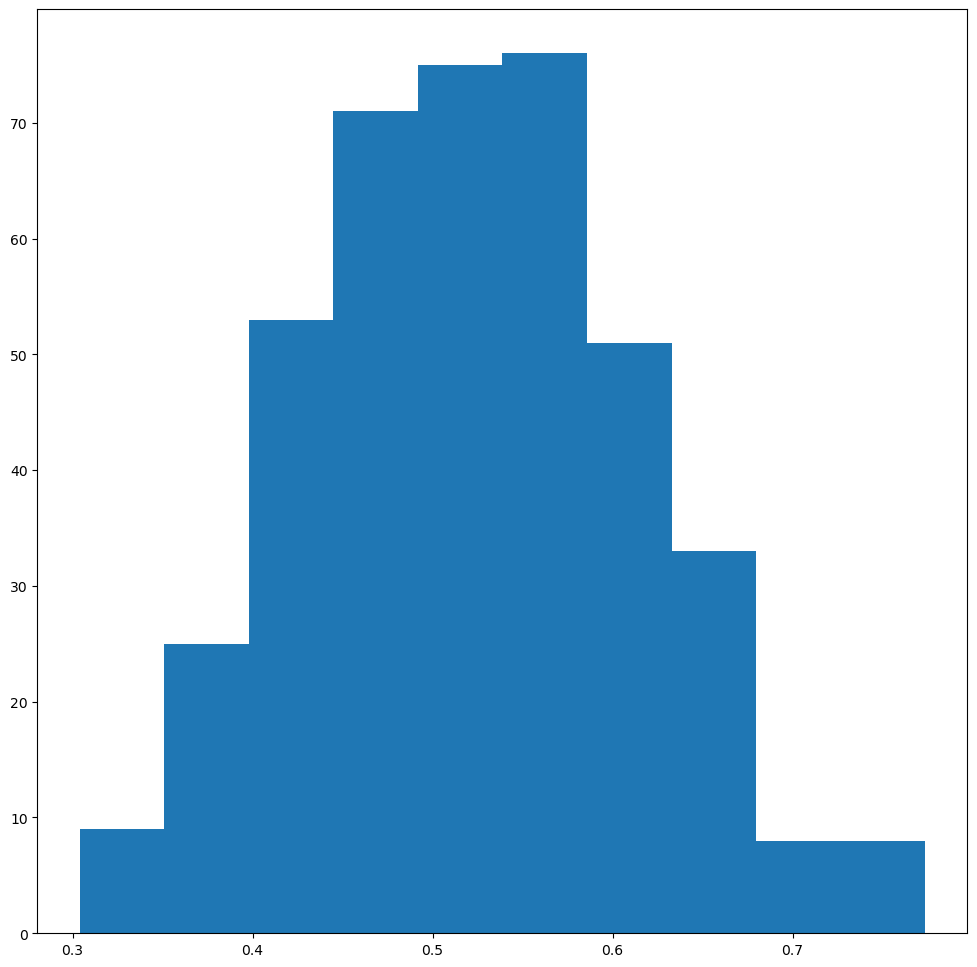

In [19]:
plt.figure(1, figsize=(12,12))
plt.hist(aenv_sim)

In [20]:
print(np.min(aenv_sim))

0.30400604580982676


In [21]:
#Calculate Sam Brandt's metric for updraft needed to get a meso given a certain srvort and srw
#srw01_arr1 = (srw01_arr*units('kt')).to('m/s').magnitude
#w_meso = (np.asarray(srw01_arr1)/2) * (np.exp(0.01/np.abs(np.asarray(swvort1_arr)))-np.exp(-0.01/np.abs(np.asarray(swvort1_arr))))

In [22]:
#print(np.median(w_meso))
print(swvort1_arr)

[0.01579184960003447, 0.020165987607191696, 0.016094999782279344, 0.01680902695276896, 0.013708667649423844, 0.006622301372302399, 0.0074302051030815126, 0.008301048964582558, 0.006846213968079302, 0.010997351106740452, 0.005884169491977359, 0.01766269736778905, 0.014775379652649802, 0.009412560288059917, 0.017963574612741475, 0.006855808978372261, 0.008968537778014162, 0.015014464969477392, 0.014407280778205425, 0.02059572471134504, 0.019343182198269984, 0.003554413870125257, 0.021787599330712254, 0.008241019157638082, 0.010212041992289915, 0.01342293058922867, 0.0201091140670585, 0.021314480256113547, 0.013878353305759771, 0.005945486545780675, 0.009720004366125157, 0.014181652089090451, 0.004285217745496675, 0.012589941135754481, 0.006198164723037772, 0.00465323286850635, 0.013098457441200598, 0.0010598817223581134, 0.006702064982951413, 0.017126273092963513, 0.0028954983541755646, 0.010250301260032572, 0.005141123945889401, 0.010777734204569869, 0.015421197040544747, 0.020050365284

In [774]:
envvar = 'offhodo_devs'
plottype = '90'

#var1 = np.asarray(aenv_sim)
#var1 = np.asarray(io_angle)
if envvar == 'swvort1':
    var1 = np.asarray(swvort1_arr)
#var1 = np.asarray(w_meso)
if envvar == 'swn1':
    var1 = np.asarray(swn1_arr)
if envvar == 'shr6': 
    var1 = np.asarray(shr6_arr)
if envvar == 'shr1': 
    var1 = np.asarray(shr1_arr)
if envvar == 'eshr': 
    var1 = np.asarray(eshr_arr)
if envvar == 'lcl': 
    var1 = np.asarray(lcl_arr)
if envvar == 'wbz': 
    var1 = np.asarray(wbz_z)
#var1 = np.asarray(rh13_arr)
#var1 = np.asarray(rh36_arr)
if envvar == 'rh_850': 
    var1 = np.asarray(rh_850)*100

#var1 = np.asarray(lfc_arr)
if envvar == 'srh1':
    var1 = np.asarray(srh1_arr)
if envvar == 'srh3': 
    var1 = np.asarray(srh3_arr)
if envvar == 'esrh': 
    var1 = np.asarray(esrh_arr)
#var1 = np.asarray(srh1ob_arr)
#var1 = np.asarray(srh3ob_arr)
if envvar == 'srw01': 
    var1 = np.asarray(srw01_arr)
if envvar == 'srw02': 
    var1 = np.asarray(srw02_arr)
#var1 = np.asarray(srw06_arr)
if envvar == 'srw69': 
    var1 = np.asarray(srw69_arr)

if envvar == 'mlcape': 
    var1 = np.asarray(mlcape_arr)
if envvar == 'cape3': 
    var1 = np.asarray(cape3_arr)
#var1 = np.asarray(muel_arr)
#var1 = np.asarray(cape3_arr)
if envvar == 'Z0C': 
    var1 = np.asarray(Z0C_arr)
#var1 = np.asarray(cin_arr)
#var1 = np.asarray(scp_arr)
#var1 = np.asarray(stp_arr)

if envvar == 'offhodo_devs': 
    var1 = np.asarray(offhodo_devs_arr)
if envvar == 'spd': 
    var1 = np.asarray(all_spd)

if plottype == 'quartile':
    var_25th = np.nanpercentile(var1, 25)
    var_75th = np.nanpercentile(var1, 75)
elif plottype == '90':
    var_25th = np.nanpercentile(var1, 10)
    var_75th = np.nanpercentile(var1, 90)
else:
    print('invalid plottype')

# var_25th = np.nanpercentile(var1, 5)
# var_75th = np.nanpercentile(var1, 95)
#print(var_25th, var_75th)


#Get index for all HSLC cases
# HSLC_index = np.where(np.logical_and(np.asarray(lcl_arr) < 1000, np.asarray(cape3_arr) < 50))
# B_index = np.where(np.logical_and(np.asarray(lcl_arr) < 1000, np.asarray(cape3_arr) > 100))

if envvar == 'HSLC':

    HSLC_index = np.where(np.logical_and(np.asarray(mlcape_arr) < 1000, np.asarray(shr6_arr) > 50))
    B_index = np.where(np.logical_and(np.asarray(mlcape_arr) > 2000, np.asarray(shr6_arr) < 40))
    print(HSLC_index[0].shape)
    print(B_index[0].shape)

#HSLC_index = np.where(np.asarray(mlcape_arr) < 1000)
#HSLC_index = np.where(np.asarray(shr6_arr) > 50)

else:
    HSLC_index = np.where(np.asarray(var1) > var_75th)
    B_index = np.where(np.asarray(var1) < var_25th)

#B_index = np.where(np.logical_and(np.asarray(var1) > 110, np.asarray(var1) < 130))


index_pmm1 = HSLC_index
ref_pm = _run_pmm_one_variable(ref_array[index_pmm1])
rot1_pm = _run_pmm_one_variable(rot1_array[index_pmm1])
rot3_pm = _run_pmm_one_variable(rot3_array[index_pmm1])
rot5_pm = _run_pmm_one_variable(rot5_array[index_pmm1])
rot7_pm = _run_pmm_one_variable(rot7_array[index_pmm1])
nzdr_pm = _run_pmm_one_variable(nzdr_array[index_pmm1])
zdrd_pm = _run_pmm_one_variable(zdrd_array[index_pmm1])
zdr_pm = _run_pmm_one_variable(zdr_array[index_pmm1])
kdp_pm = _run_pmm_one_variable(kdp_array[index_pmm1])
cc_pm = _run_pmm_one_variable(cc_array[index_pmm1])
var_75mean = np.nanmean(var1[index_pmm1])
var_25mean = np.nanmean(var1[B_index])


index_pmm2 = B_index
ref_pm1 = _run_pmm_one_variable(ref_array[index_pmm2])
rot1_pm1 = _run_pmm_one_variable(rot1_array[index_pmm2])
rot3_pm1 = _run_pmm_one_variable(rot3_array[index_pmm2])
rot5_pm1 = _run_pmm_one_variable(rot5_array[index_pmm2])
rot7_pm1 = _run_pmm_one_variable(rot7_array[index_pmm2])
nzdr_pm1 = _run_pmm_one_variable(nzdr_array[index_pmm2])
zdrd_pm1 = _run_pmm_one_variable(zdrd_array[index_pmm2])
zdr_pm1 = _run_pmm_one_variable(zdr_array[index_pmm2])
kdp_pm1 = _run_pmm_one_variable(kdp_array[index_pmm2])
cc_pm1 = _run_pmm_one_variable(cc_array[index_pmm2])

# var_75mean = (var_75mean*units('kt')).to('m/s').magnitude
# var_25mean = (var_25mean*units('kt')).to('m/s').magnitude

print(var_25mean, var_75mean)

print(cc_array[index_pmm1].shape)

if envvar == 'srh1':
    var_string = 'SRH1'
    unit_string = 'm$^2$ s$^-$$^2$'
    
if envvar == 'srh3':
    var_string = 'SRH3'
    unit_string = 'm$^2$ s$^-$$^2$'

# var_string = 'Obs. SRH1'
# unit_string = 'm$^2$ s$^-$$^2$'

if envvar == 'offhodo_devs':
    var_string = 'OFFHODO'
    unit_string = 'm s$^-$$^1$'

# var_string = 'Similarity'
# unit_string = ''

if envvar == 'spd':
    var_string = 'SPD'
    unit_string = 'm s$^-$$^1$'

# var_string = 'Mystery Variable'
# unit_string = 'no idea'

if envvar == 'wbz':
    var_string = 'WBZ Z'
    unit_string = 'm'

if envvar == 'rh_850':
    var_string = '850-600 mb RH'
    unit_string = 'percent'

# var_string = 'W_needed'
# unit_string = 'm s$^-$$^1$'

# var_string = 'IO_Angle'
# unit_string = 'degrees'

if envvar == 'swvort1':
    var_string = 'SWVORT1'
    unit_string = 's$^-$$^1$'

if envvar == 'swn1':
    var_string = 'SWN1'
    unit_string = '(unitless)'

# var_string = 'STP'
# unit_string = '(unitless)'

if envvar == 'shr1':
    var_string = 'SHR1'
    #unit_string = 'm s$^-$$^1$'
    unit_string = 'kt'
    
if envvar == 'shr6':
    var_string = 'SHR6'
    #unit_string = 'm s$^-$$^1$'
    unit_string = 'kt'
    
if envvar == 'eshr':
    var_string = 'eshr'
    #unit_string = 'm s$^-$$^1$'
    unit_string = 'kt'

if envvar == 'mlcape':
    var_string = 'MLCAPE'
    unit_string = 'J kg$^-$$^1$'
    
if envvar == 'cape3':
    var_string = 'ML3CAPE'
    unit_string = 'J kg$^-$$^1$'

# var_string = 'MLCIN'
# unit_string = 'J kg$^-$$^1$'

# var_string = 'ML3CAPE'
# unit_string = 'J kg$^-$$^1$'

if envvar == 'srw01':
    var_string = 'SRW01'
    unit_string = 'kt'
    #unit_string = 'm s$^-$$^1$'
    
if envvar == 'srw02':
    var_string = 'SRW02'
    unit_string = 'kt'
    #unit_string = 'm s$^-$$^1$'
    
if envvar == 'srw69':
    var_string = 'SRW6-9'
    unit_string = 'kt'
    #unit_string = 'm s$^-$$^1$'

if envvar == 'lcl':
    var_string = 'LCL'
    unit_string = 'm'

# var_string = 'LFC'
# unit_string = 'm'

# var_string = 'MUEL'
# unit_string = 'm'

if envvar == 'Z0C':
    var_string = 'Z0C'
    unit_string = 'm'
if envvar == 'HSLC':
    titlestring1 = 'HSLC (MLCAPE < 1000 J kg$^-$$^1$ + SHR06 > 50 kt) Cases (n=65)'
    titlestring2 = 'All MLCAPE > 2000 J kg$^-$$^1$ + SHR06 < 40 kt Cases (n=61)'
    titlestring3 = 'FFD-Relative Composite Comparison \n (HSLC=solid, High-CAPE=dashed)'
    unit_string=''

# titlestring1 = 'FFD-Relative Composite Supercell, All LCL < 1000 m + 3CAPE < 50'
# titlestring2 = 'FFD-Relative Composite Supercell, All LCL < 1000 m + 3CAPE > 100'
# titlestring3 = 'FFD-Relative Composite Comparison \n (Low-3CAPE=solid, High-3CAPE=dashed)'
# unit_string = ''

if plottype == 'quartile':
    titlestring1 = 'FFRG-Relative Composite Supercell, Top '+var_string+' Quartile (n=102) \n Mean '+var_string+': %.0f ' %(var_75mean)
    titlestring2 = 'FFRG-Relative Composite Supercell, Bottom '+var_string+' Quartile (n=102) \n Mean '+var_string+': %.0f ' %(var_25mean)
    titlestring3 = 'FFRG-Relative Composite Comparison \n (High-'+var_string+'=solid, Low-'+var_string+'=dashed)'

# titlestring1 = 'FFRG-Relative Composite Supercell, Top '+var_string+' Quartile (n=102) \n Mean '+var_string+': * absurd # due to asymptote * '
# titlestring2 = 'FFRG-Relative Composite Supercell, Bottom '+var_string+' Quartile (n=102) \n Mean '+var_string+': %.4f ' %(var_25mean)
# titlestring3 = 'FFRG-Relative Composite Comparison \n (High-'+var_string+'=solid, Low-'+var_string+'=dashed)'

elif plottype == '90':
    titlestring1 = 'FFRG-Relative Composite Supercell, Top '+var_string+' 10 percent (n=41) \n Mean '+var_string+': %.0f ' %(var_75mean)
    titlestring2 = 'FFRG-Relative Composite Supercell, Bottom '+var_string+' 10 percent (n=41) \n Mean '+var_string+': %.0f ' %(var_25mean)
    titlestring3 = 'FFRG-Relative Composite Comparison \n (High-'+var_string+'=solid, Low-'+var_string+'=dashed)'

else:
    print('invalid plottype')
# titlestring1 = 'FFRG-Relative Composite Supercell, Top '+var_string+' 10 percent (n=41) \n Mean '+var_string+': '
# titlestring2 = 'FFRG-Relative Composite Supercell, Bottom '+var_string+' 10 percent (n=41) \n Mean '+var_string+': '
# titlestring3 = 'FFRG-Relative Composite Comparison \n (High-'+var_string+'=solid, Low-'+var_string+'=dashed)'

# titlestring1 = 'FFRG-Relative Composite Supercell, Top '+var_string+' 5 percent (n=21) \n Mean '+var_string+': %.2f ' %(var_75mean)
# titlestring2 = 'FFRG-Relative Composite Supercell, Bottom '+var_string+' 5 percent (n=21) \n Mean '+var_string+': %.2f ' %(var_25mean)
# titlestring3 = 'FFRG-Relative Composite Comparison \n (High-'+var_string+'=solid, Low-'+var_string+'=dashed)'

#save_string='HSLC'
#save_string='CAPE_quartiles'
if plottype == 'quartile':
    save_string=var_string+'_quartiles'
elif plottype == '90':
    save_string=var_string+'_10_90'
elif plottype == 'HSLC':
    save_string=var_string+'HSLC'
else:
    print('invalid plottype')
#save_string=var_string+'simtest'

-4.652200489026043 5.900762700443677
(41, 99, 99)


In [775]:
print(rh_850)
#print(sr_d_911)

[0.5888103304531814, 0.9440073955953722, 0.9031183021633435, 0.49252688087083096, 0.705752696784042, 0.8055914072382866, 0.8903641450502556, 0.7095193926271569, 0.8479615985919393, 0.8804853561417562, 0.8660577508167632, 0.7831182519857761, 0.5782795608689402, 0.6375269062651645, 0.8987633902448706, 0.8652688103088982, 0.6831182832678862, 0.8789525088206112, 0.8901613240546385, 0.6901189478690849, 0.92698925722206, 0.6999999828319109, 0.9160608089693915, 0.851559156897173, 0.5065053708935593, 0.5401872200190556, 0.7687956545987811, 0.833172767002051, 0.6512731167044763, 0.6786882631387277, 0.8256842118709302, 0.8446537778488286, 0.626021490255063, 0.9541936079750223, 0.5933871885668265, 0.8699999917194952, 0.9077419387035175, 0.6617583260321174, 0.9637634266020164, 0.6810753017902748, 0.6357527208370025, 0.8402688088937638, 0.7839246614288069, 0.8117203985474731, 0.5046762406376312, 0.5652706016026203, 0.8680645129774557, 0.7462903371837631, 0.7804301476033357, 0.9923655994644227, 0.56

In [776]:
#print(ALL_years[ALL_years=='2019'])
#print(ALL_months[ALL_years=='2019'])

# for i in range(len(ALL_years[ALL_years=='2019'])):
#     print(ALL_years[ALL_years=='2019'][i], ALL_months[ALL_years=='2019'][i], ALL_days[ALL_years=='2019'][i], ALL_hours[ALL_years=='2019'][i], ALL_sites[ALL_years=='2019'][i], var1[ALL_years=='2019'][i])

In [777]:
for i in range(len(ALL_years[index_pmm1])):
    print(ALL_years[index_pmm1][i], ALL_months[index_pmm1][i], ALL_days[index_pmm1][i], ALL_hours[index_pmm1][i], ALL_sites[index_pmm1][i], var1[index_pmm1][i])
    #print(np.asarray(var1)[index_pmm1][i])

2017 5 18 19 KFDR 4.6553344942659844
2017 7 12 0 KMVX 5.686041597222534
2016 11 30 1 KGWX 6.847490863389973
2013 11 17 20 KPAH 5.5375995527247
2014 7 3 21 KENX 4.923244358883576
2012 4 29 8 KAMA 4.17309896663577
2013 5 10 3 KEWX 4.990099014756888
2014 4 29 21 KGRR 6.374347073019379
2013 3 18 22 KFFC 5.617285155537889
2013 4 27 2 KFDR 4.84045736530876
2014 9 4 6 KBIS 4.019961964789376
2013 3 18 21 KDGX 5.293992074129946
2013 4 8 0 KSGF 6.613504636949127
2019 5 25 22 KLBB 4.276169920382792
2019 10 21 2 KFWS 8.678163297077866
2014 4 29 1 KHTX 4.59018857598085
2017 6 28 23 KDMX 5.446470408981405
2019 4 13 7 KPOE 6.925556849383739
2016 4 13 2 KEWX 6.042625385671013
2020 4 28 22 KTLX 5.433738933407092
2020 5 8 0 KFDR 7.2669101175652955
2015 6 4 1 KDDC 4.250559582272864
2021 3 17 3 KFDR 6.384750396927437
2021 3 23 3 KGRK 4.506607858218377
2021 3 26 1 KOHX 5.053410831821365
2021 4 28 22 KDFX 6.192740601555714
2021 5 9 0 KUEX 5.459668187561967
2021 12 11 2 KLSX 8.636667041864445
2022 4 12 23 KG

In [778]:
index_pmm10 = B_index
for i in range(len(ALL_years[index_pmm10])):
    print(ALL_years[index_pmm10][i], ALL_months[index_pmm10][i], ALL_days[index_pmm10][i], ALL_hours[index_pmm10][i], ALL_sites[index_pmm10][i], var1[index_pmm10][i])
    #print(np.asarray(var1)[index_pmm1][i])

2018 5 1 22 KDDC -4.518988069211248
2016 1 21 22 KDGX -4.051008552749147
2015 9 18 13 KUEX -3.69574277043109
2013 6 2 20 KGSP -3.898106092733895
2013 7 1 23 KLWX -4.338389423693549
2013 8 18 23 KFFC -3.9013763514757462
2013 3 31 4 KSRX -3.935852899091776
2013 10 27 0 KFWS -3.6390834603144553
2013 7 23 20 KUDX -4.963066527716256
2019 5 1 1 KSGF -8.288224862517975
2019 5 20 20 KTLX -6.147792827965599
2019 5 21 23 KTWX -6.2173760142960575
2019 6 24 22 KSJT -5.036948448842646
2019 12 28 0 KFDX -4.659645427083332
2019 5 8 10 KSJT -3.553459138044056
2019 10 2 0 KDVN -4.263338772512665
2019 6 20 1 KLNX -5.138060911546952
2021 3 27 1 KUEX -5.404460340961914
2021 3 27 23 KNQA -3.3586504818717238
2021 4 14 21 KHGX -4.391222395373971
2021 5 22 22 KPUX -6.327486989010115
2021 5 24 21 KGLD -4.664767680594619
2021 5 25 23 KAMA -3.870770025351403
2021 6 8 23 KVWX -5.592083745054542
2021 6 26 23 KMAF -3.631166023398475
2022 6 2 2 KFDR -3.7408470904036415
2022 12 15 3 KTLH -3.408754130153768
2022 7 26 

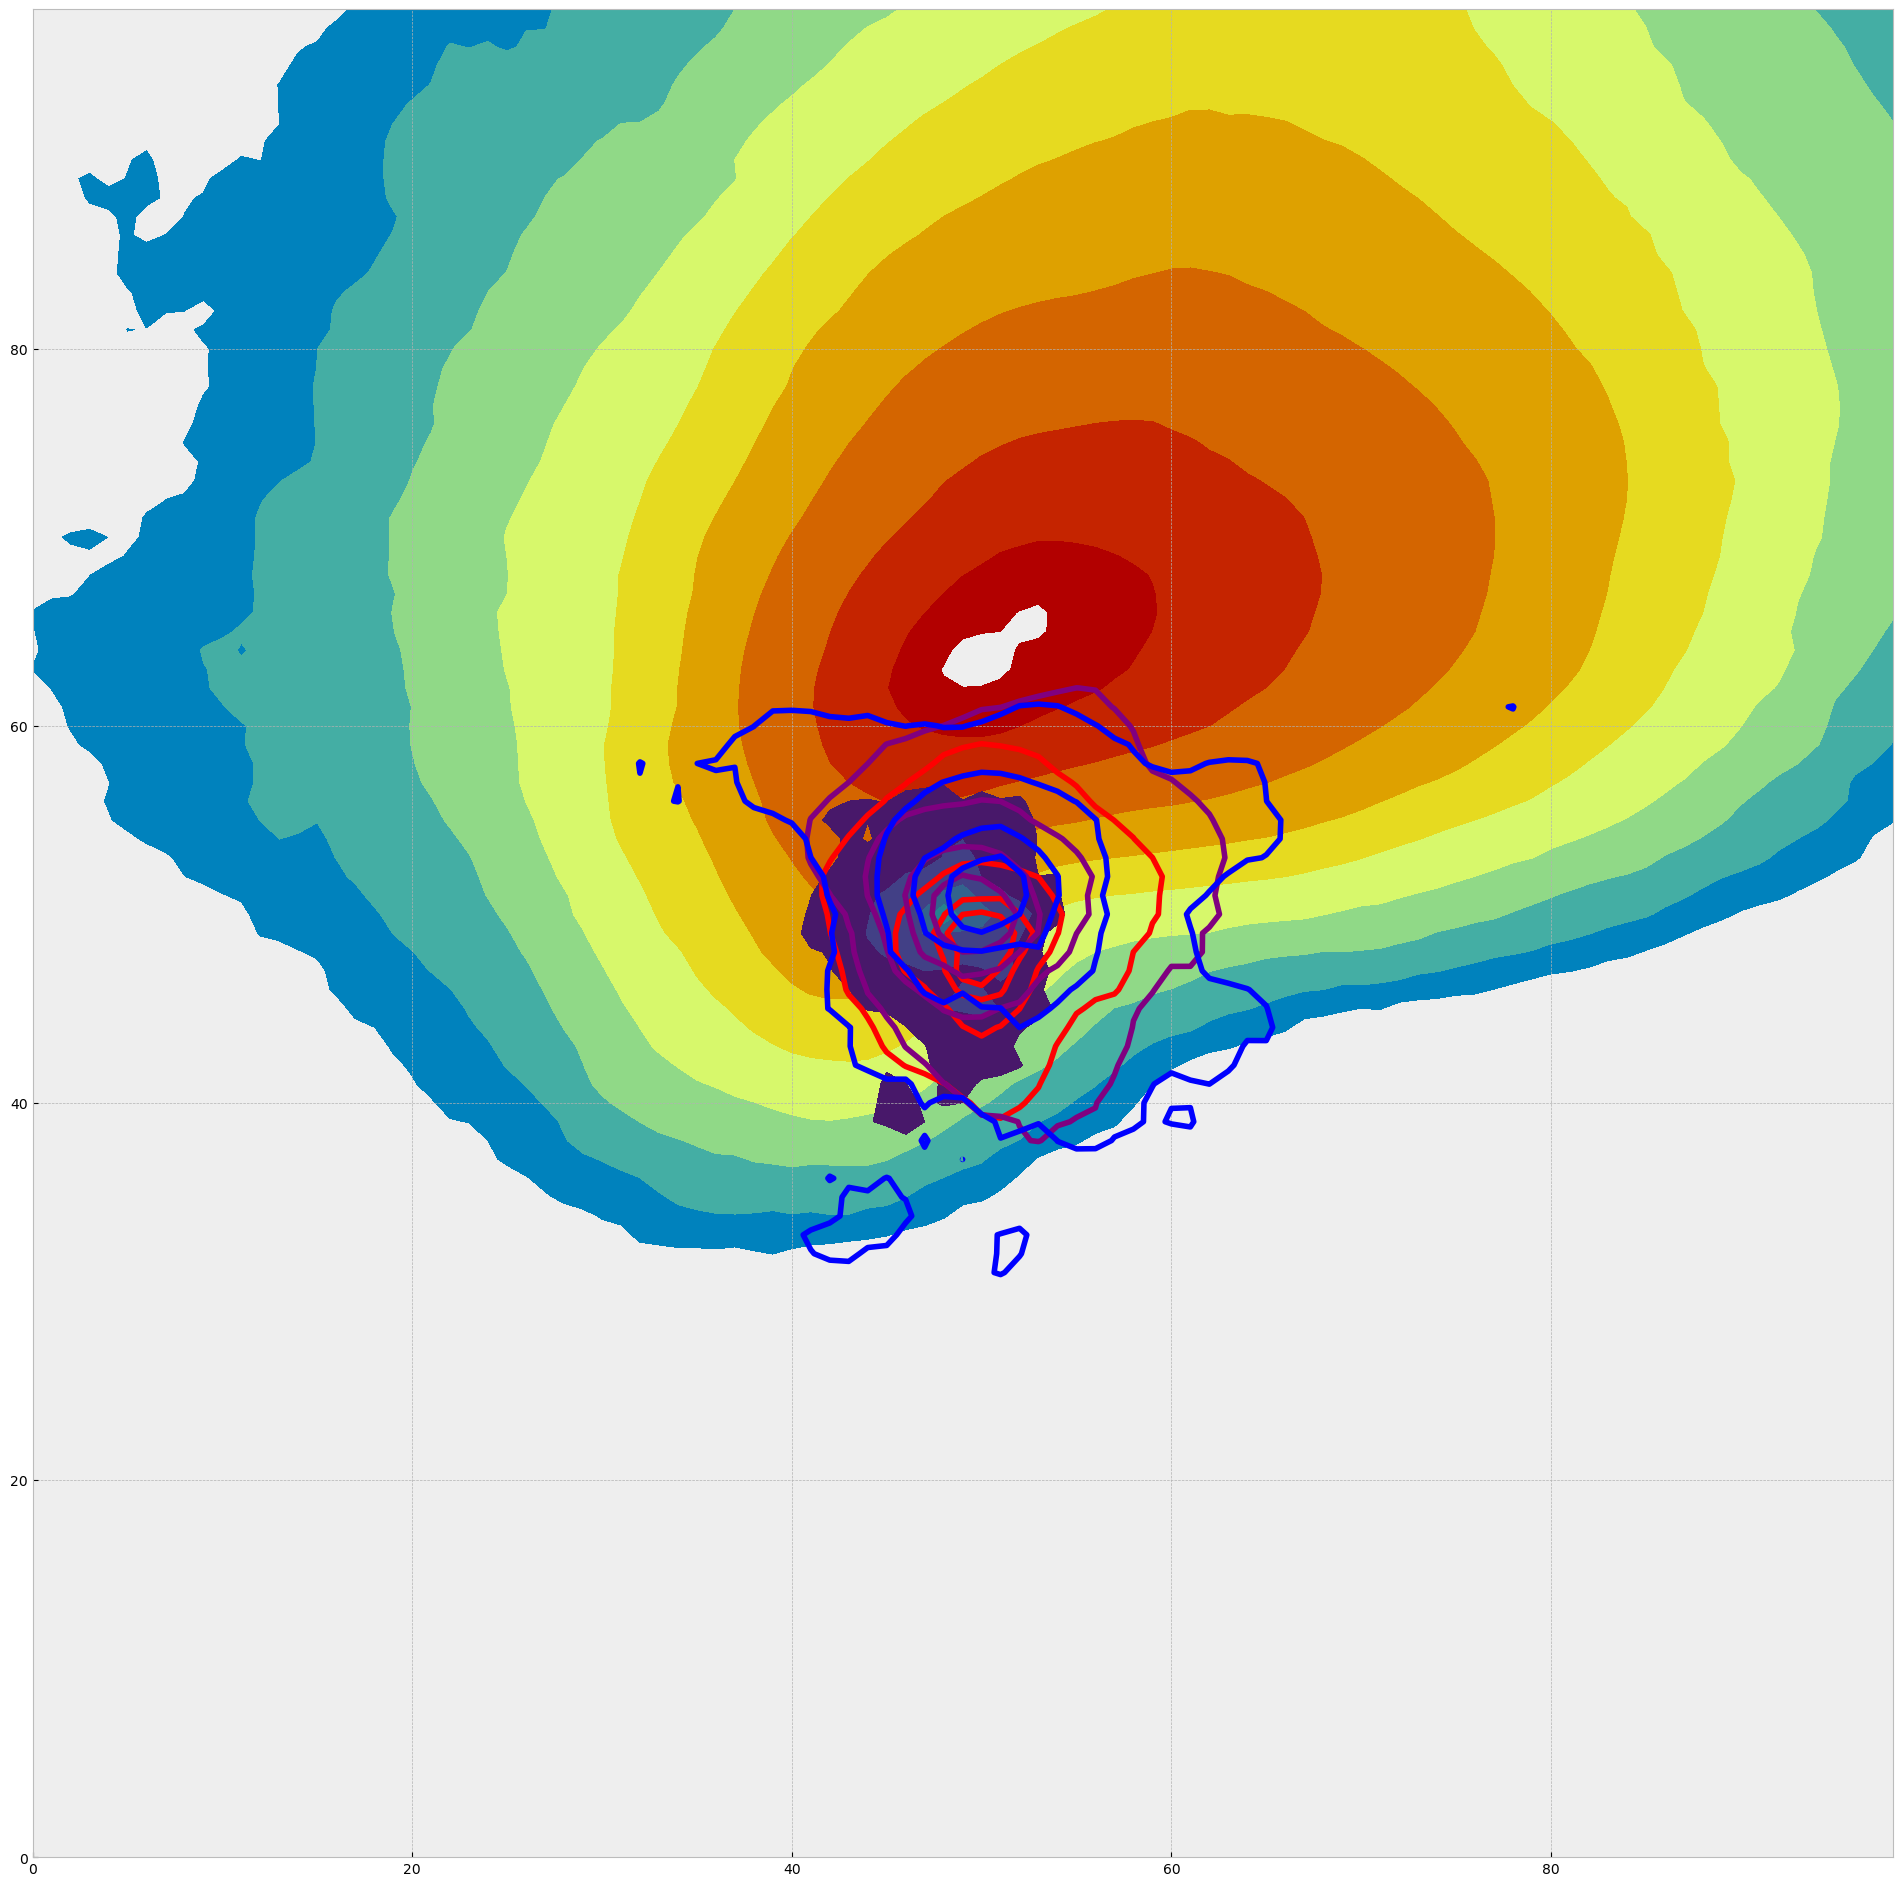

In [779]:
plt.figure(1, figsize=(24,24))
xr2 = np.arange(0, 99, 1)
reflevs = np.arange(20, 70, 5)
zdrdlev = np.arange(1, 10, 1)
rotlev = np.arange(0.002,0.01, 0.002)
# plt.contourf(xr, xr, ref_st[4, :, :], reflevs, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
# plt.contour(xr, xr, zdrd_st[:, :]/4, zdrdlev, cmap=plt.cm.viridis, linewidths=5)
plt.contourf(xr2, xr2, ref_pm, reflevs, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.contourf(xr2, xr2, zdrd_pm/4, zdrdlev, cmap=plt.cm.viridis)
plt.contour(xr2, xr2, rot1_pm, rotlev, colors='r', linewidths=4)
plt.contour(xr2, xr2, rot3_pm, rotlev, colors='purple', linewidths=4)
plt.contour(xr2, xr2, rot5_pm, rotlev, colors='blue', linewidths=4)

In [780]:
#Get index for all HSLC cases
#HC_index = np.where(np.asarray(mlcape_arr) > 2000)
#HC_index = np.where(np.asarray(shr6_arr) < 30)
# HC_index = np.where(np.asarray(var1) < var_25th)
# #HC_index = np.where(np.logical_and(np.asarray(var1) > 110, np.asarray(var1) < 130))


# index_pmm1 = HC_index
# ref_pm1 = _run_pmm_one_variable(ref_array[index_pmm1])
# rot1_pm1 = _run_pmm_one_variable(rot1_array[index_pmm1])
# rot3_pm1 = _run_pmm_one_variable(rot3_array[index_pmm1])
# rot5_pm1 = _run_pmm_one_variable(rot5_array[index_pmm1])
# rot7_pm1 = _run_pmm_one_variable(rot7_array[index_pmm1])
# nzdr_pm1 = _run_pmm_one_variable(nzdr_array[index_pmm1])
# zdrd_pm1 = _run_pmm_one_variable(zdrd_array[index_pmm1])
# zdr_pm1 = _run_pmm_one_variable(zdr_array[index_pmm1])
# kdp_pm1 = _run_pmm_one_variable(kdp_array[index_pmm1])
# cc_pm1 = _run_pmm_one_variable(cc_array[index_pmm1])

#print(cc_array[index_pmm1].shape)

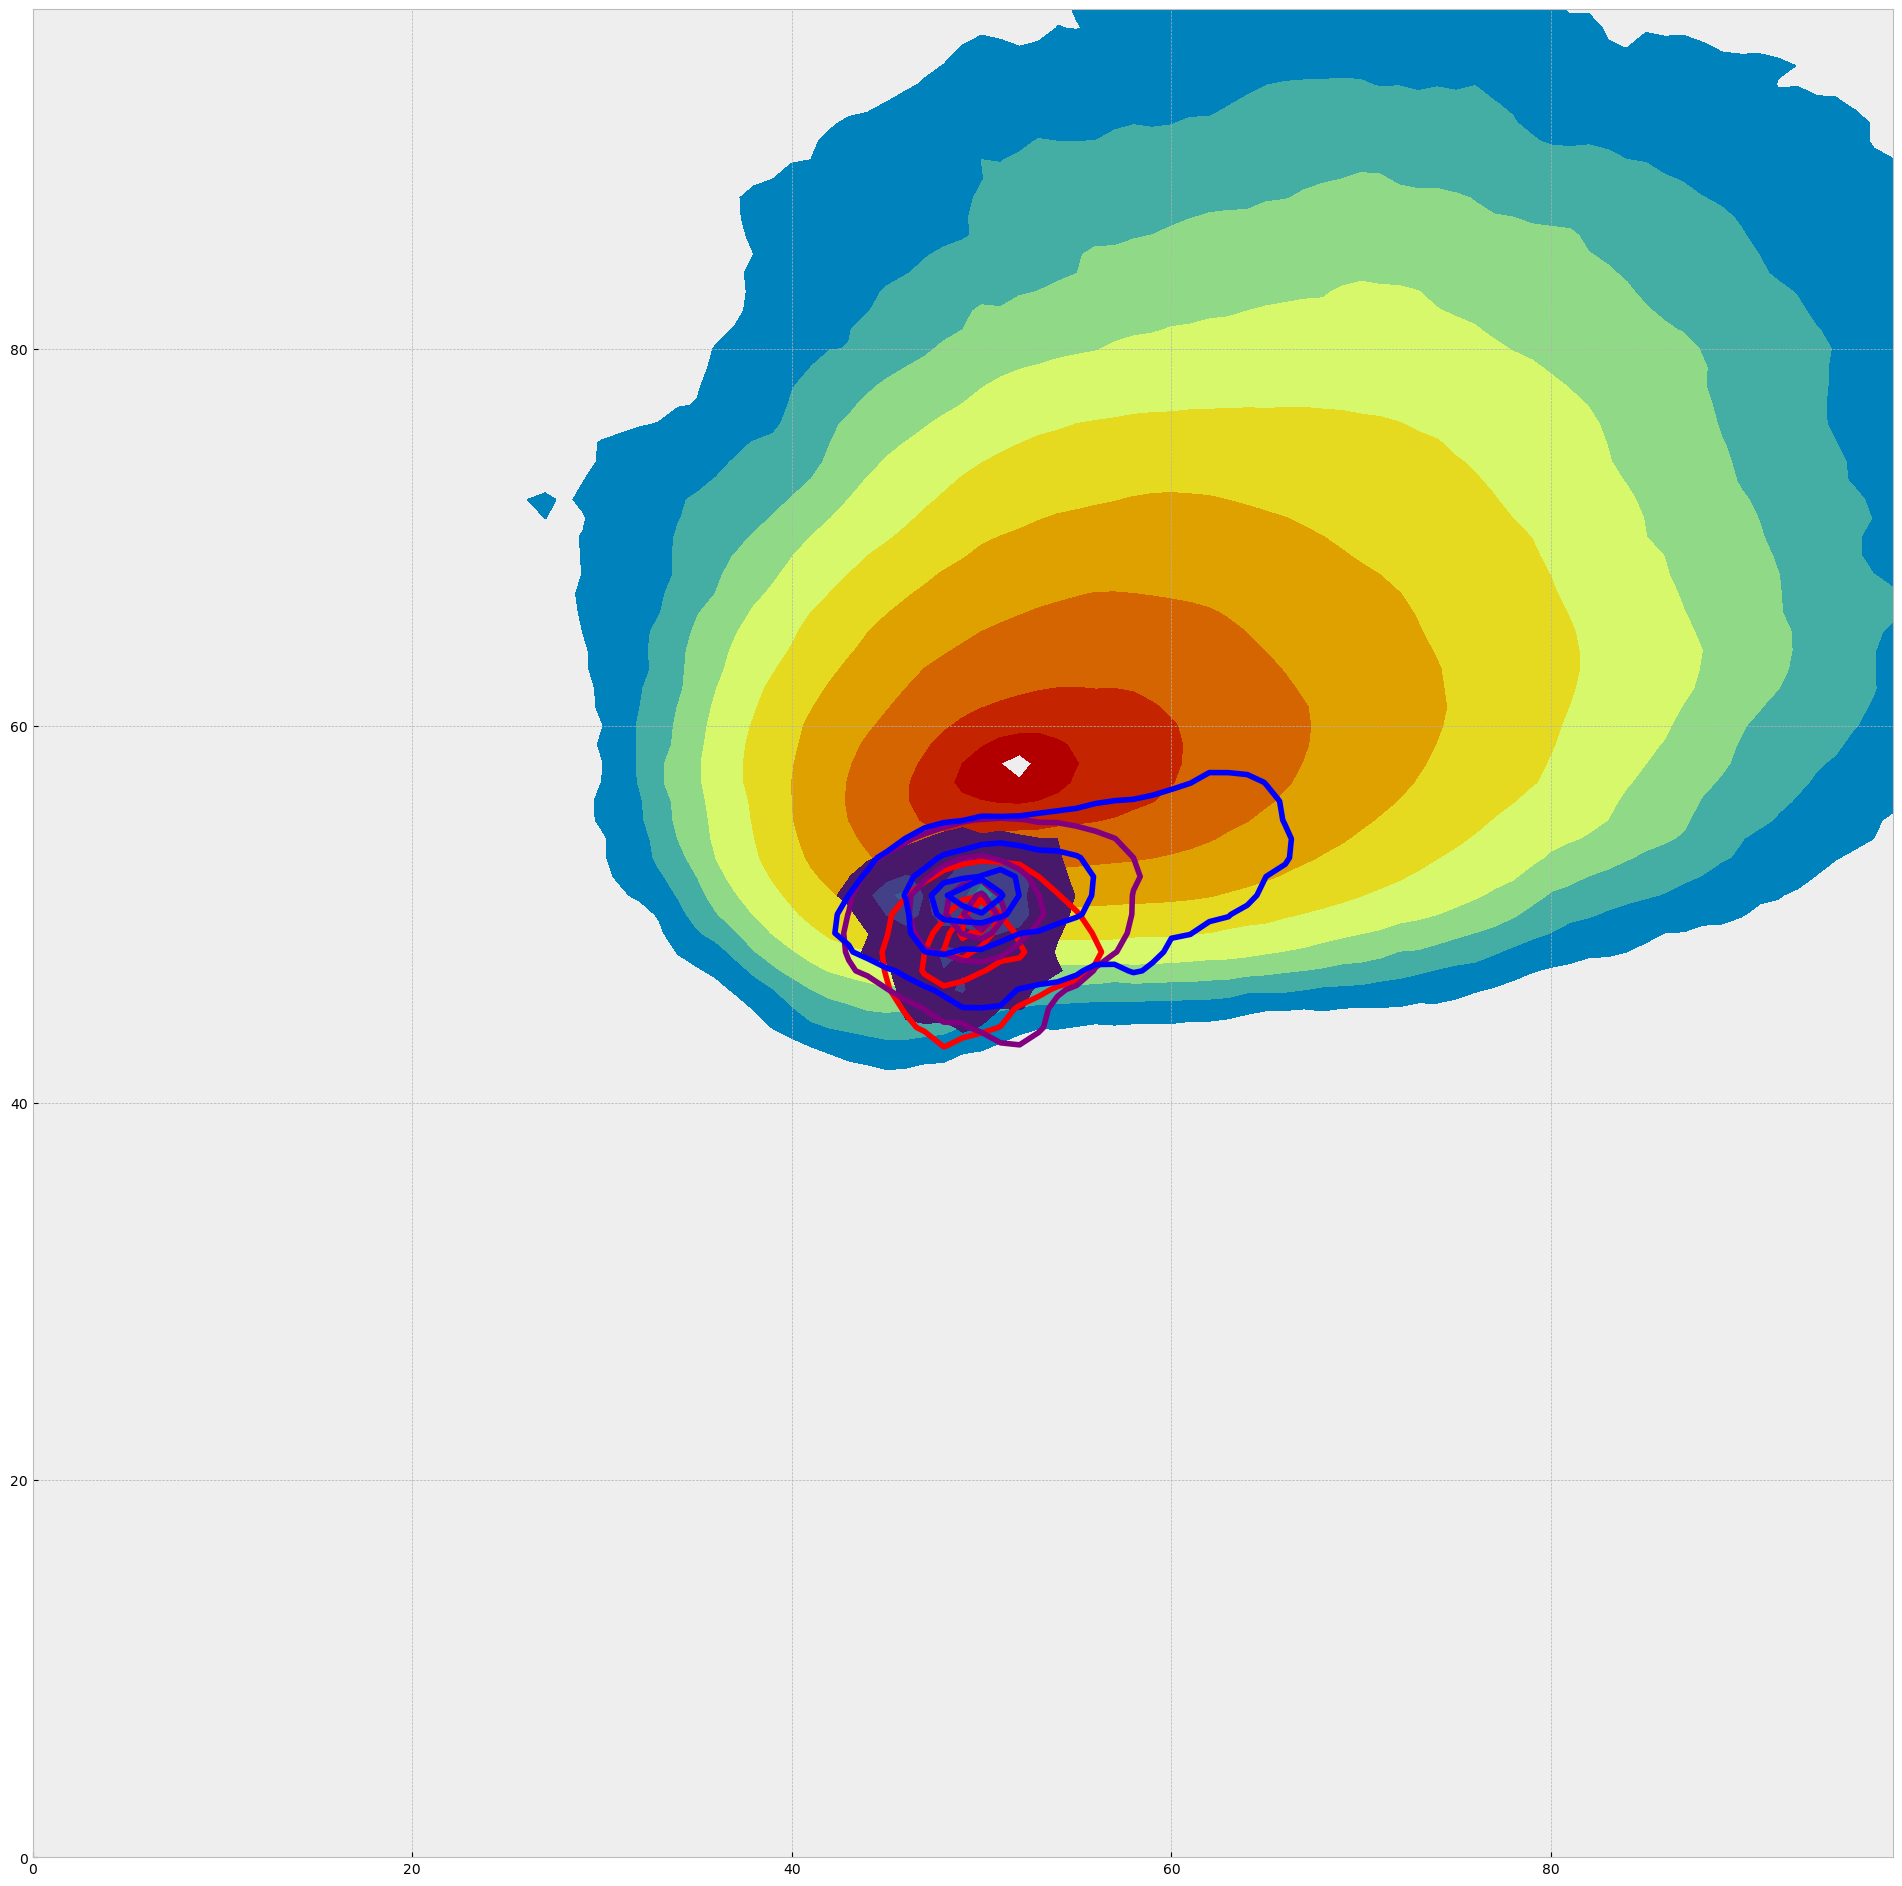

In [781]:
plt.figure(1, figsize=(24,24))
xr2 = np.arange(0, 99, 1)
reflevs = np.arange(20, 70, 5)
zdrdlev = np.arange(1, 10, 1)
rotlev = np.arange(0.002,0.01, 0.002)
# plt.contourf(xr, xr, ref_st[4, :, :], reflevs, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
# plt.contour(xr, xr, zdrd_st[:, :]/4, zdrdlev, cmap=plt.cm.viridis, linewidths=5)
plt.contourf(xr2, xr2, ref_pm1, reflevs, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.contourf(xr2, xr2, zdrd_pm1/4, zdrdlev, cmap=plt.cm.viridis)
plt.contour(xr2, xr2, rot1_pm1, rotlev, colors='r', linewidths=4)
plt.contour(xr2, xr2, rot3_pm1, rotlev, colors='purple', linewidths=4)
plt.contour(xr2, xr2, rot5_pm1, rotlev, colors='blue', linewidths=4)

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1574872994.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  refp1 = plt.contour(xr11, yr11, ref_pm, [40], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1574872994.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1574872994.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1574872994.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh()

Text(0, 0.5, 'Distance from Z Centroid (km)')

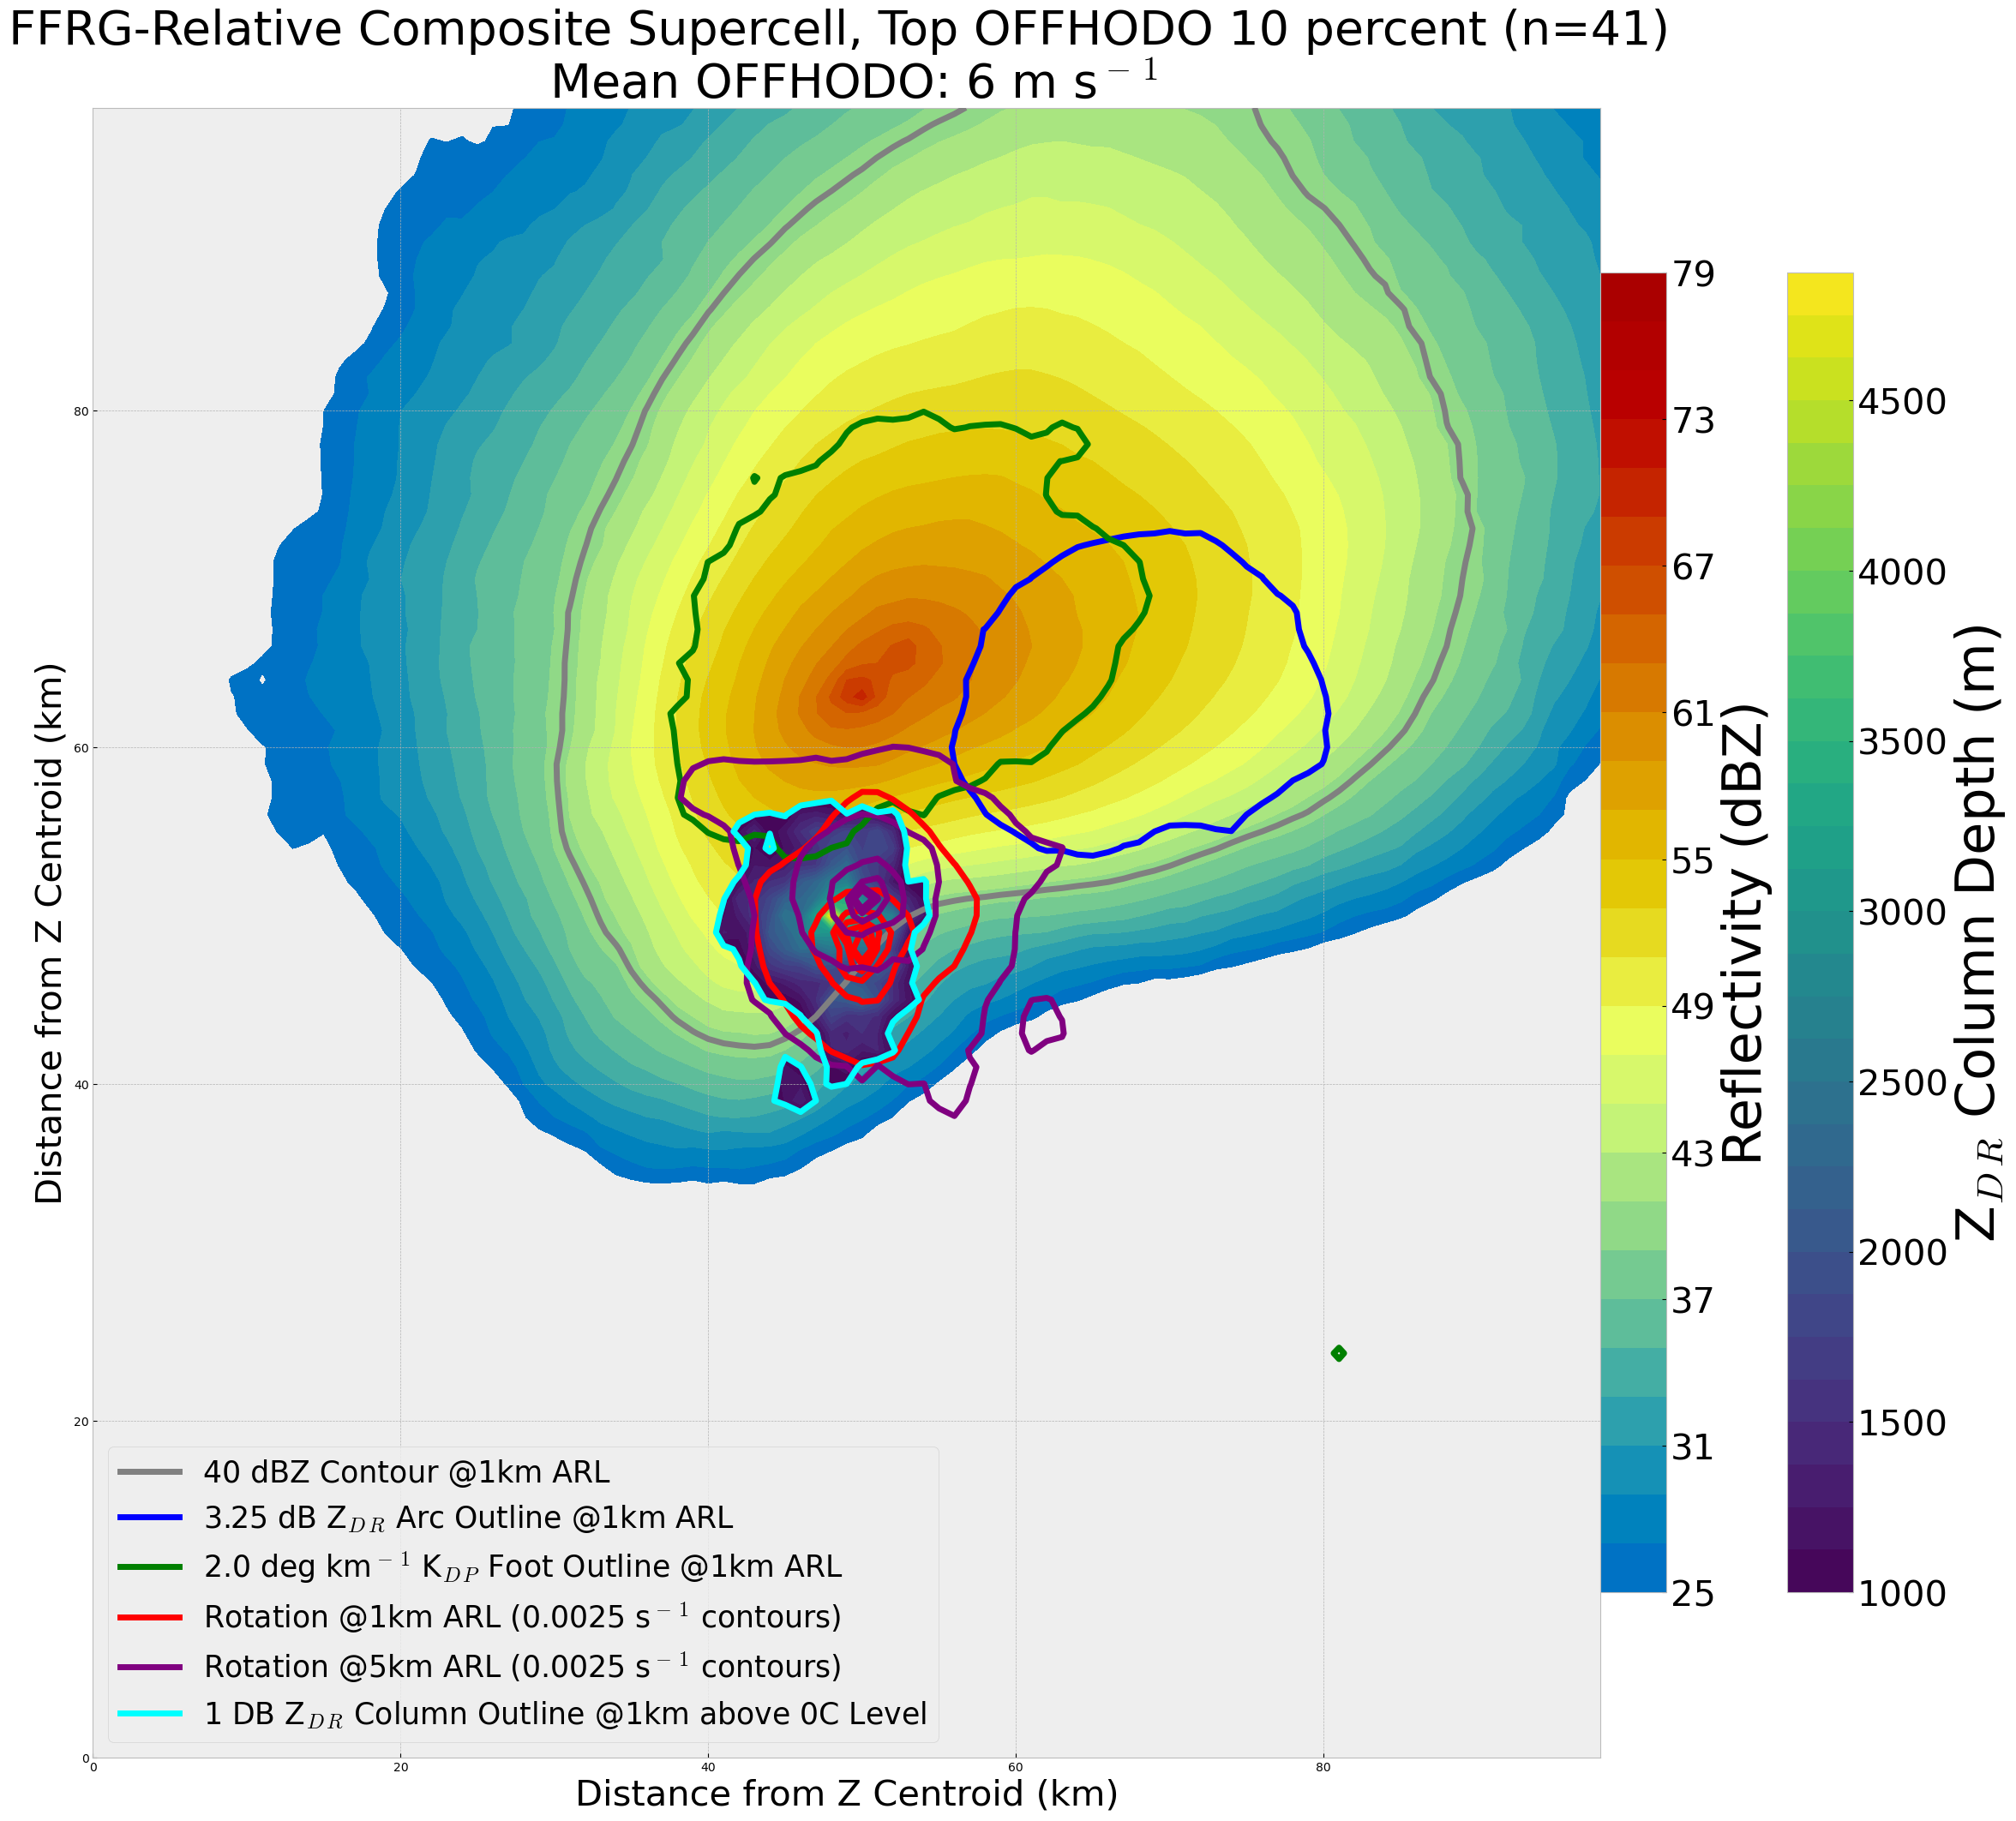

In [782]:
#Create a figure and plot up the initial data and contours for the algorithm
fig=plt.figure(1,figsize=(30.,25.))
# ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp1 = plt.contour(xr11, yr11, ref_pm, [40], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm, [3.5], colors='b', linewidths=5)
rotp1 = plt.contour(xr11, yr11, kdp_pm, [2.0], colors='g', linewidths=5)

refp2 = plt.contourf(xr11, yr11, ref_pm, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='cyan', linewidths=5, zorder=10)

refd2 = plt.contourf(xr11, yr11, zdrd_pm*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

plt.title(titlestring1+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='blue', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (0.0025 s$^-$$^1$ contours)')
rot5_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (0.0025 s$^-$$^1$ contours)')
column_outline = mlines.Line2D([], [], color='cyan', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline @1km above 0C Level')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot5_outline, column_outline], loc = 3, fontsize = 25)

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from Z Centroid (km)", size=30)
plt.ylabel("Distance from Z Centroid (km)", size=30)

#plt.savefig('AMS2025_plots/AC_'+save_string+'SHIFTEDplot3km.png', bbox_inches='tight')

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2559276480.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  refp1 = plt.contour(xr11, yr11, ref_pm1, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2559276480.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2559276480.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pm1, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2559276480.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormes

Text(0, 0.5, 'Distance from Z Centroid (km)')

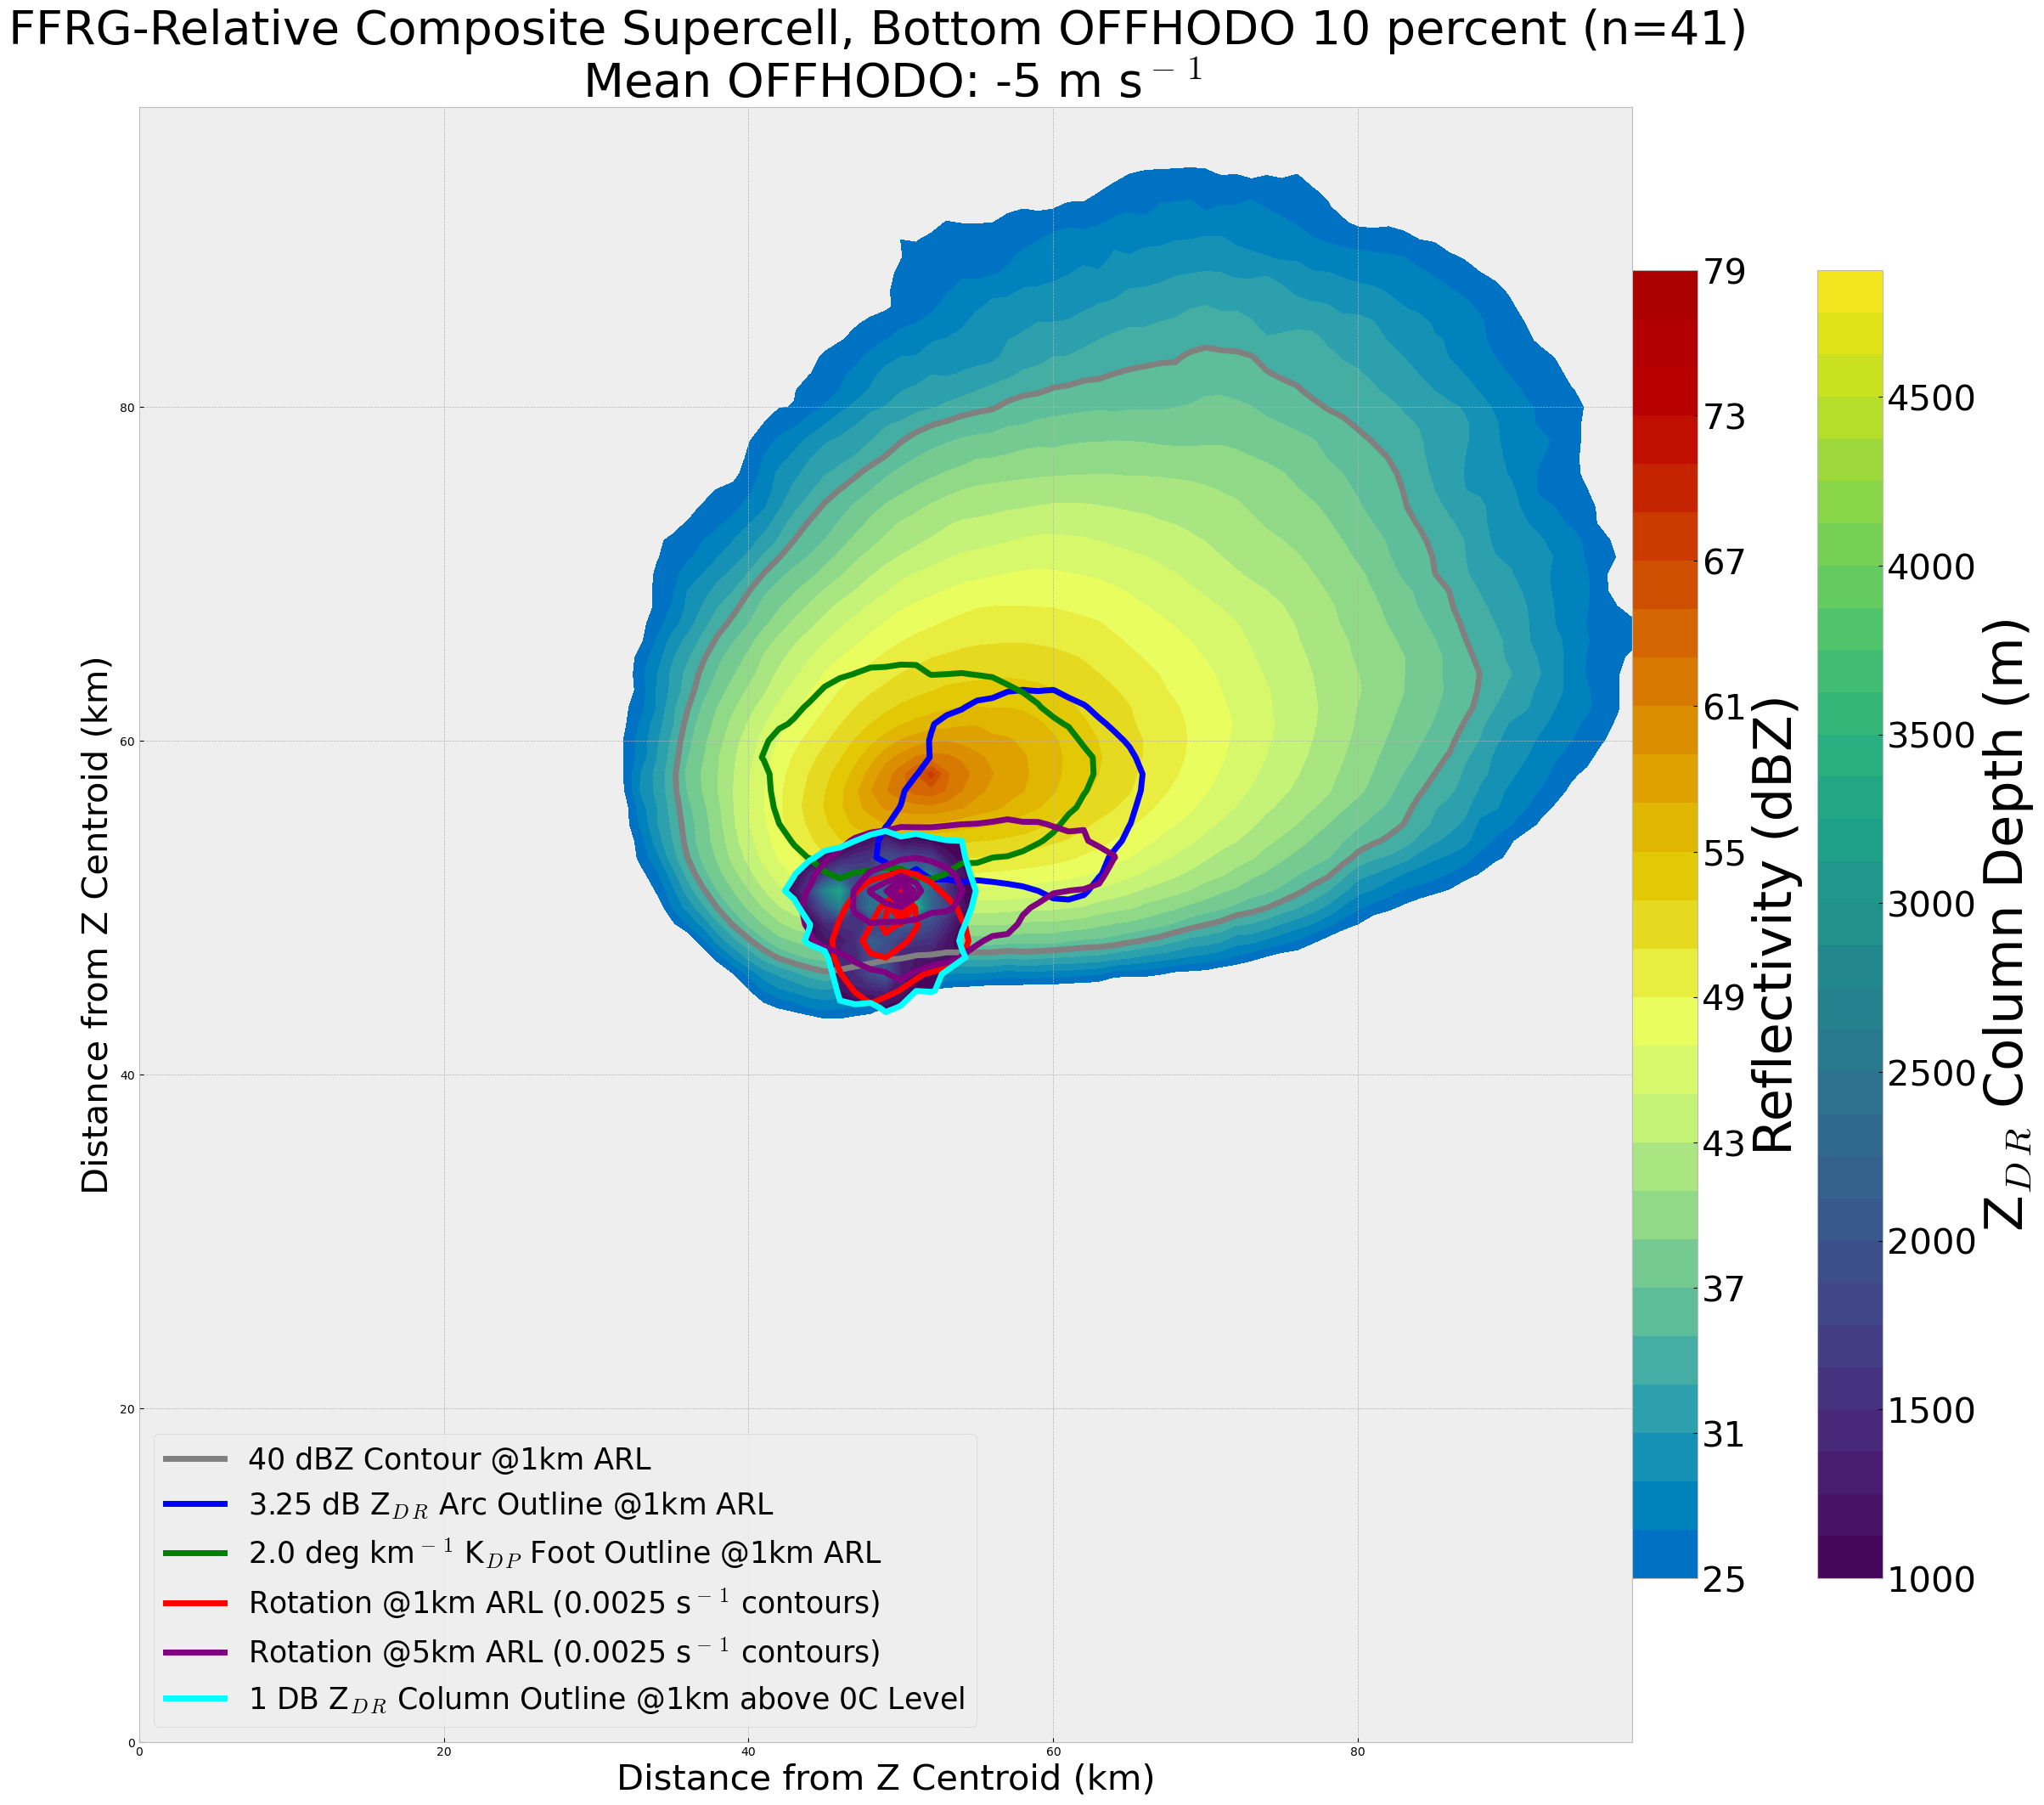

In [783]:
#Create a figure and plot up the initial data and contours for the algorithm
fig=plt.figure(1,figsize=(30.,25.))
# ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp1 = plt.contour(xr11, yr11, ref_pm1, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm1, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm1, [3.5], colors='b', linewidths=5)
rotp1 = plt.contour(xr11, yr11, kdp_pm1, [2.0], colors='g', linewidths=5)

refp2 = plt.contourf(xr11, yr11, ref_pm1, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm1, [4], colors='cyan', linewidths=5, zorder=10)

refd2 = plt.contourf(xr11, yr11, zdrd_pm1*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

plt.title(titlestring2+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='blue', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (0.0025 s$^-$$^1$ contours)')
#rot5_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (0.0025 s$^-$$^1$ contours)')
column_outline = mlines.Line2D([], [], color='cyan', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline @1km above 0C Level')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot5_outline, column_outline], loc = 3, fontsize = 25)

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from Z Centroid (km)", size=30)
plt.ylabel("Distance from Z Centroid (km)", size=30)

#plt.savefig('AMS2025_plots/AC_'+save_string+'SHIFTEDplot2_3km.png', bbox_inches='tight')
#plt.savefig('IO120plot2.png', bbox_inches='tight')

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3358252750.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  refp1 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3358252750.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005, 0.01, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3358252750.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  rotp2 = plt.contour(xr11, yr11, rot3_pm, [0.005, 0.01, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3358252750.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005, 0.01, 0.0

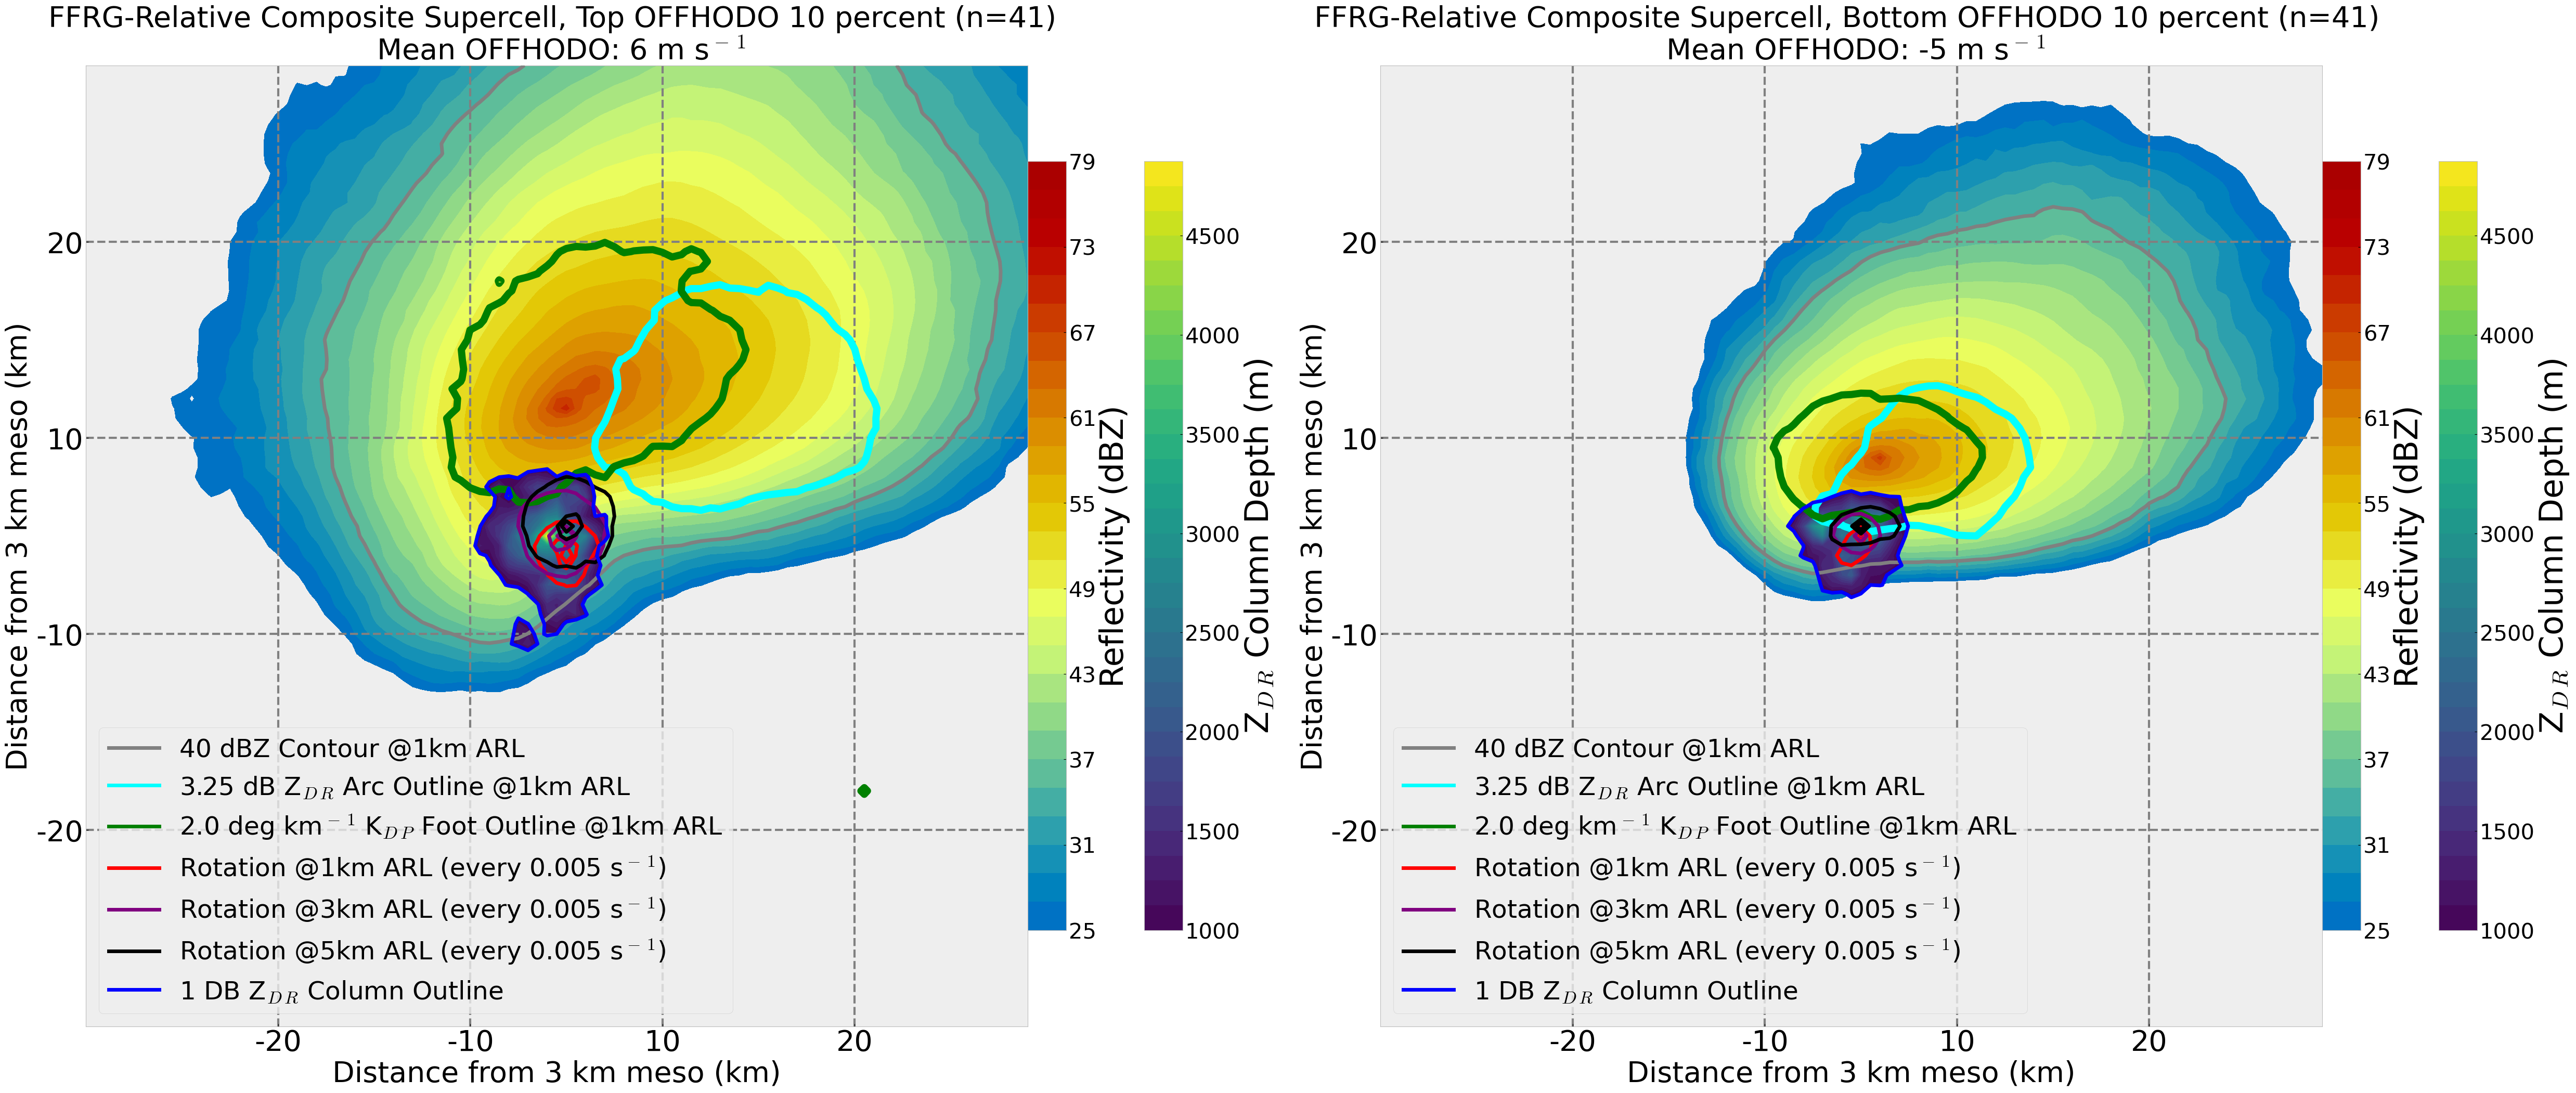

In [784]:
#Make a 2-panel figure
figure_layout = """
AB
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_layout, figsize=(63,24))

plt.sca(ax=axes['A'])
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp1 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005, 0.01, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp2 = plt.contour(xr11, yr11, rot3_pm, [0.005, 0.01, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005, 0.01, 0.015], colors='k', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm, [3.25], colors='cyan', linewidths=10)
rotp1 = plt.contour(xr11, yr11, kdp_pm, [2.0], colors='g', linewidths=10)

refp2 = plt.contourf(xr11, yr11, ref_pm, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='b', linewidths=5, zorder=10)

refd2 = plt.contourf(xr11, yr11, zdrd_pm*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

plt.title(titlestring1+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
#zdr_outline = mlines.Line2D([], [], color='cyan', linewidth = 5, linestyle = 'solid', label='2 SD TRENDSS Arc Outline @1km ARL')
zdr_outline = mlines.Line2D([], [], color='cyan', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (every 0.005 s$^-$$^1$)')
rot2_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @3km ARL (every 0.005 s$^-$$^1$)')
rot5_outline = mlines.Line2D([], [], color='k', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (every 0.005 s$^-$$^1$)')
column_outline = mlines.Line2D([], [], color='b', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot2_outline, rot5_outline, column_outline], loc = 3, fontsize = 35)

plt.grid(linewidth=3, color='grey', linestyle='--')

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from 3 km meso (km)", size=40)
plt.ylabel("Distance from 3 km meso (km)", size=40)
plt.xticks([20,40,60,80],[-20,-10,10,20],size=40)
plt.yticks([20,40,60,80],[-20,-10,10,20],size=40)

plt.sca(ax=axes['B'])
refp1 = plt.contour(xr11, yr11, ref_pm1, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.005, 0.01, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp2 = plt.contour(xr11, yr11, rot3_pm1, [0.005, 0.01, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm1, [0.005, 0.01, 0.015], colors='k', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm1, [3.25], colors='cyan', linewidths=10)
rotp1 = plt.contour(xr11, yr11, kdp_pm1, [2.0], colors='g', linewidths=10)

refp2 = plt.contourf(xr11, yr11, ref_pm1, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm1, [4], colors='b', linewidths=5, zorder=10)

refd2 = plt.contourf(xr11, yr11, zdrd_pm1*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

plt.title(titlestring2+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
#zdr_outline = mlines.Line2D([], [], color='cyan', linewidth = 5, linestyle = 'solid', label='2 SD TRENDSS Arc Outline @1km ARL')
zdr_outline = mlines.Line2D([], [], color='cyan', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')

kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (every 0.005 s$^-$$^1$)')
rot2_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @3km ARL (every 0.005 s$^-$$^1$)')
rot5_outline = mlines.Line2D([], [], color='k', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (every 0.005 s$^-$$^1$)')
column_outline = mlines.Line2D([], [], color='b', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot2_outline, rot5_outline, column_outline], loc = 3, fontsize = 35)

plt.grid(linewidth=3, color='grey', linestyle='--')

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from 3 km meso (km)", size=40)
plt.ylabel("Distance from 3 km meso (km)", size=40)
plt.xticks([20,40,60,80],[-20,-10,10,20],size=40)
plt.yticks([20,40,60,80],[-20,-10,10,20],size=40)

plt.subplots_adjust(wspace=+0.04)

#plt.savefig('AMS2025_plots/AC_StampPaperSHIFTED3'+save_string+'2panel.png', bbox_inches='tight')
#plt.savefig('AMS2025_plots/TRENDSSAC_StampPaperSHIFTED3'+save_string+'2panel.png', bbox_inches='tight')
plt.savefig('AMS2025_plots/AC_StampPaperSHIFTED3'+save_string+'2panel.png', bbox_inches='tight')

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3687074258.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  refp1 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3687074258.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005, 0.01, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3687074258.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  rotp2 = plt.contour(xr11, yr11, rot3_pm, [0.005, 0.01, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3687074258.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005, 0.01, 0.0

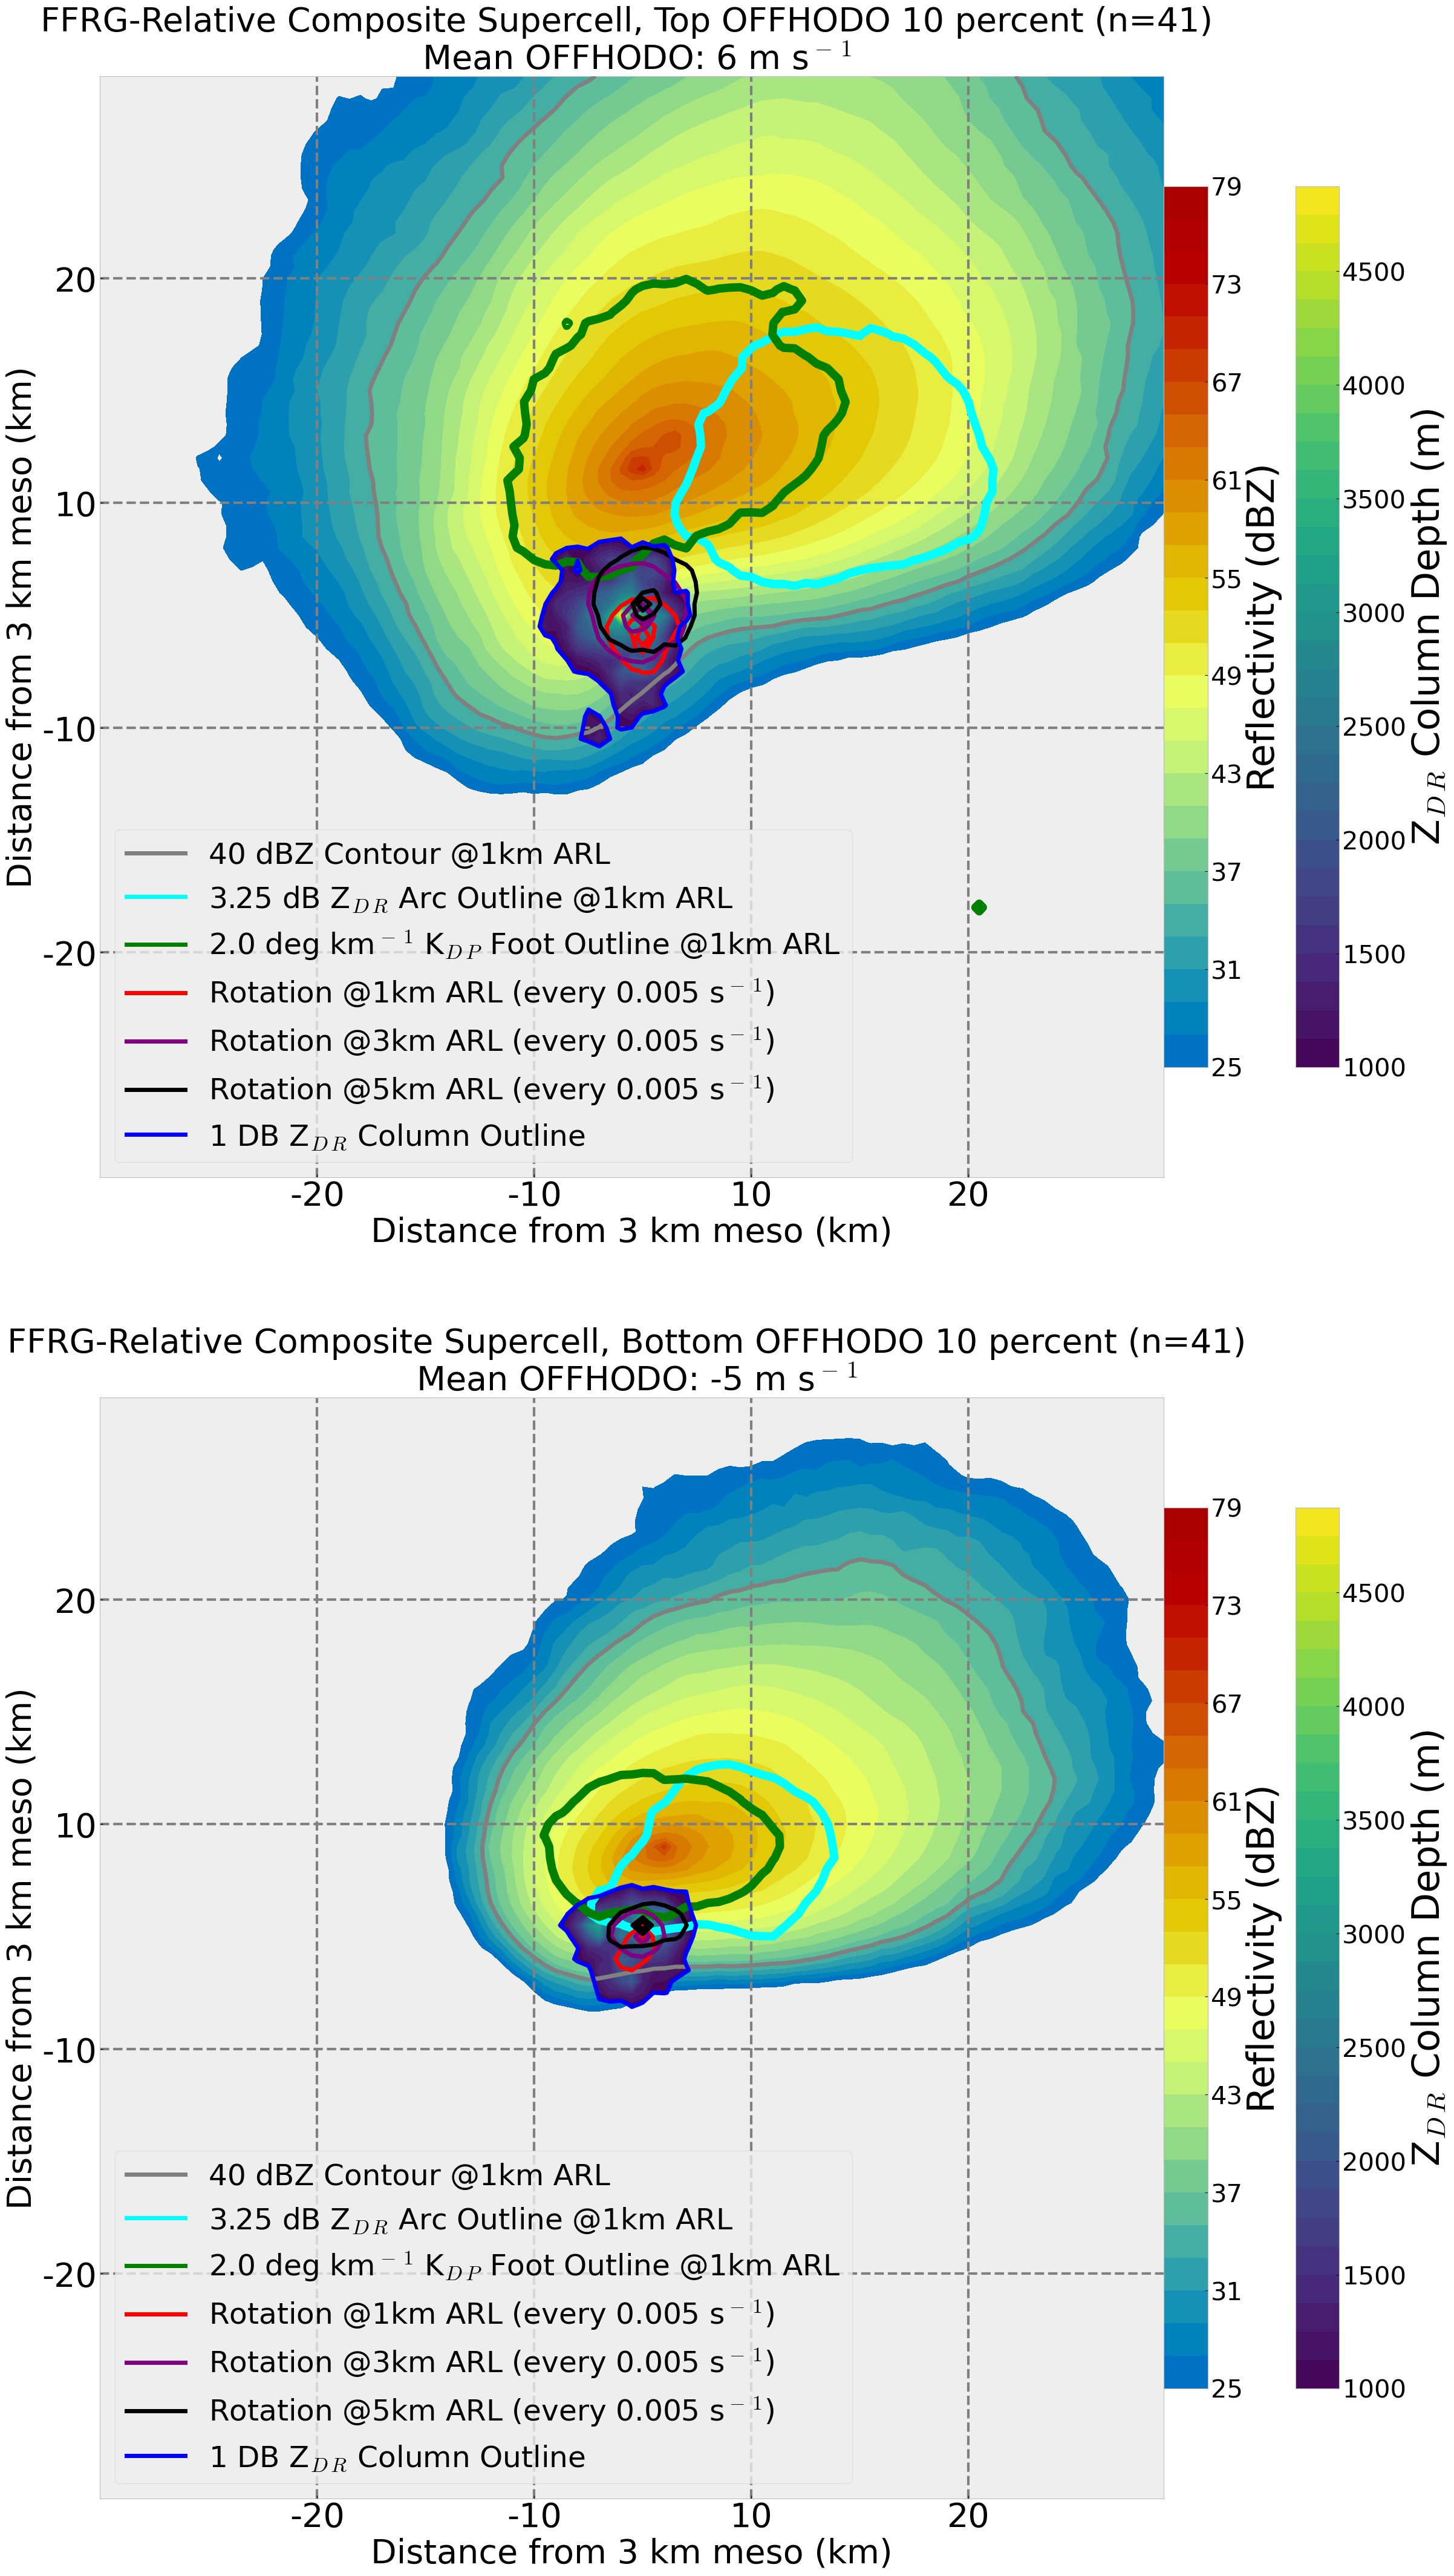

In [785]:
#Make a 2-panel figure
figure_layout = """
A
B
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_layout, figsize=(30,52))

plt.sca(ax=axes['A'])
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp1 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005, 0.01, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp2 = plt.contour(xr11, yr11, rot3_pm, [0.005, 0.01, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005, 0.01, 0.015], colors='k', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm, [3.25], colors='cyan', linewidths=10)
rotp1 = plt.contour(xr11, yr11, kdp_pm, [2.0], colors='g', linewidths=10)

refp2 = plt.contourf(xr11, yr11, ref_pm, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='b', linewidths=5, zorder=10)

refd2 = plt.contourf(xr11, yr11, zdrd_pm*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

plt.title(titlestring1+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
#zdr_outline = mlines.Line2D([], [], color='cyan', linewidth = 5, linestyle = 'solid', label='2 SD TRENDSS Arc Outline @1km ARL')
zdr_outline = mlines.Line2D([], [], color='cyan', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (every 0.005 s$^-$$^1$)')
rot2_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @3km ARL (every 0.005 s$^-$$^1$)')
rot5_outline = mlines.Line2D([], [], color='k', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (every 0.005 s$^-$$^1$)')
column_outline = mlines.Line2D([], [], color='b', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot2_outline, rot5_outline, column_outline], loc = 3, fontsize = 35)

plt.grid(linewidth=3, color='grey', linestyle='--')

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from 3 km meso (km)", size=40)
plt.ylabel("Distance from 3 km meso (km)", size=40)
plt.xticks([20,40,60,80],[-20,-10,10,20],size=40)
plt.yticks([20,40,60,80],[-20,-10,10,20],size=40)

plt.sca(ax=axes['B'])
refp1 = plt.contour(xr11, yr11, ref_pm1, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.005, 0.01, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp2 = plt.contour(xr11, yr11, rot3_pm1, [0.005, 0.01, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm1, [0.005, 0.01, 0.015], colors='k', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm1, [3.25], colors='cyan', linewidths=10)
rotp1 = plt.contour(xr11, yr11, kdp_pm1, [2.0], colors='g', linewidths=10)

refp2 = plt.contourf(xr11, yr11, ref_pm1, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm1, [4], colors='b', linewidths=5, zorder=10)

refd2 = plt.contourf(xr11, yr11, zdrd_pm1*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

plt.title(titlestring2+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
#zdr_outline = mlines.Line2D([], [], color='cyan', linewidth = 5, linestyle = 'solid', label='2 SD TRENDSS Arc Outline @1km ARL')
zdr_outline = mlines.Line2D([], [], color='cyan', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')

kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (every 0.005 s$^-$$^1$)')
rot2_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @3km ARL (every 0.005 s$^-$$^1$)')
rot5_outline = mlines.Line2D([], [], color='k', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (every 0.005 s$^-$$^1$)')
column_outline = mlines.Line2D([], [], color='b', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot2_outline, rot5_outline, column_outline], loc = 3, fontsize = 35)

plt.grid(linewidth=3, color='grey', linestyle='--')

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from 3 km meso (km)", size=40)
plt.ylabel("Distance from 3 km meso (km)", size=40)
plt.xticks([20,40,60,80],[-20,-10,10,20],size=40)
plt.yticks([20,40,60,80],[-20,-10,10,20],size=40)

plt.subplots_adjust(wspace=+0.04)

#plt.savefig('AMS2025_plots/AC_StampPaperSHIFTED3'+save_string+'2panel.png', bbox_inches='tight')
#plt.savefig('AMS2025_plots/TRENDSSAC_StampPaperSHIFTED3'+save_string+'2panel.png', bbox_inches='tight')
plt.savefig('AMS2025_plots/VERT_StampPaperSHIFTED3'+save_string+'2panel.png', bbox_inches='tight')

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2183888965.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  refp1 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2183888965.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005], colors='r', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2183888965.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  rotp2 = plt.contour(xr11, yr11, rot3_pm, [0.005], colors='purple', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2183888965.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005], colors='k', linewidths=10, zord

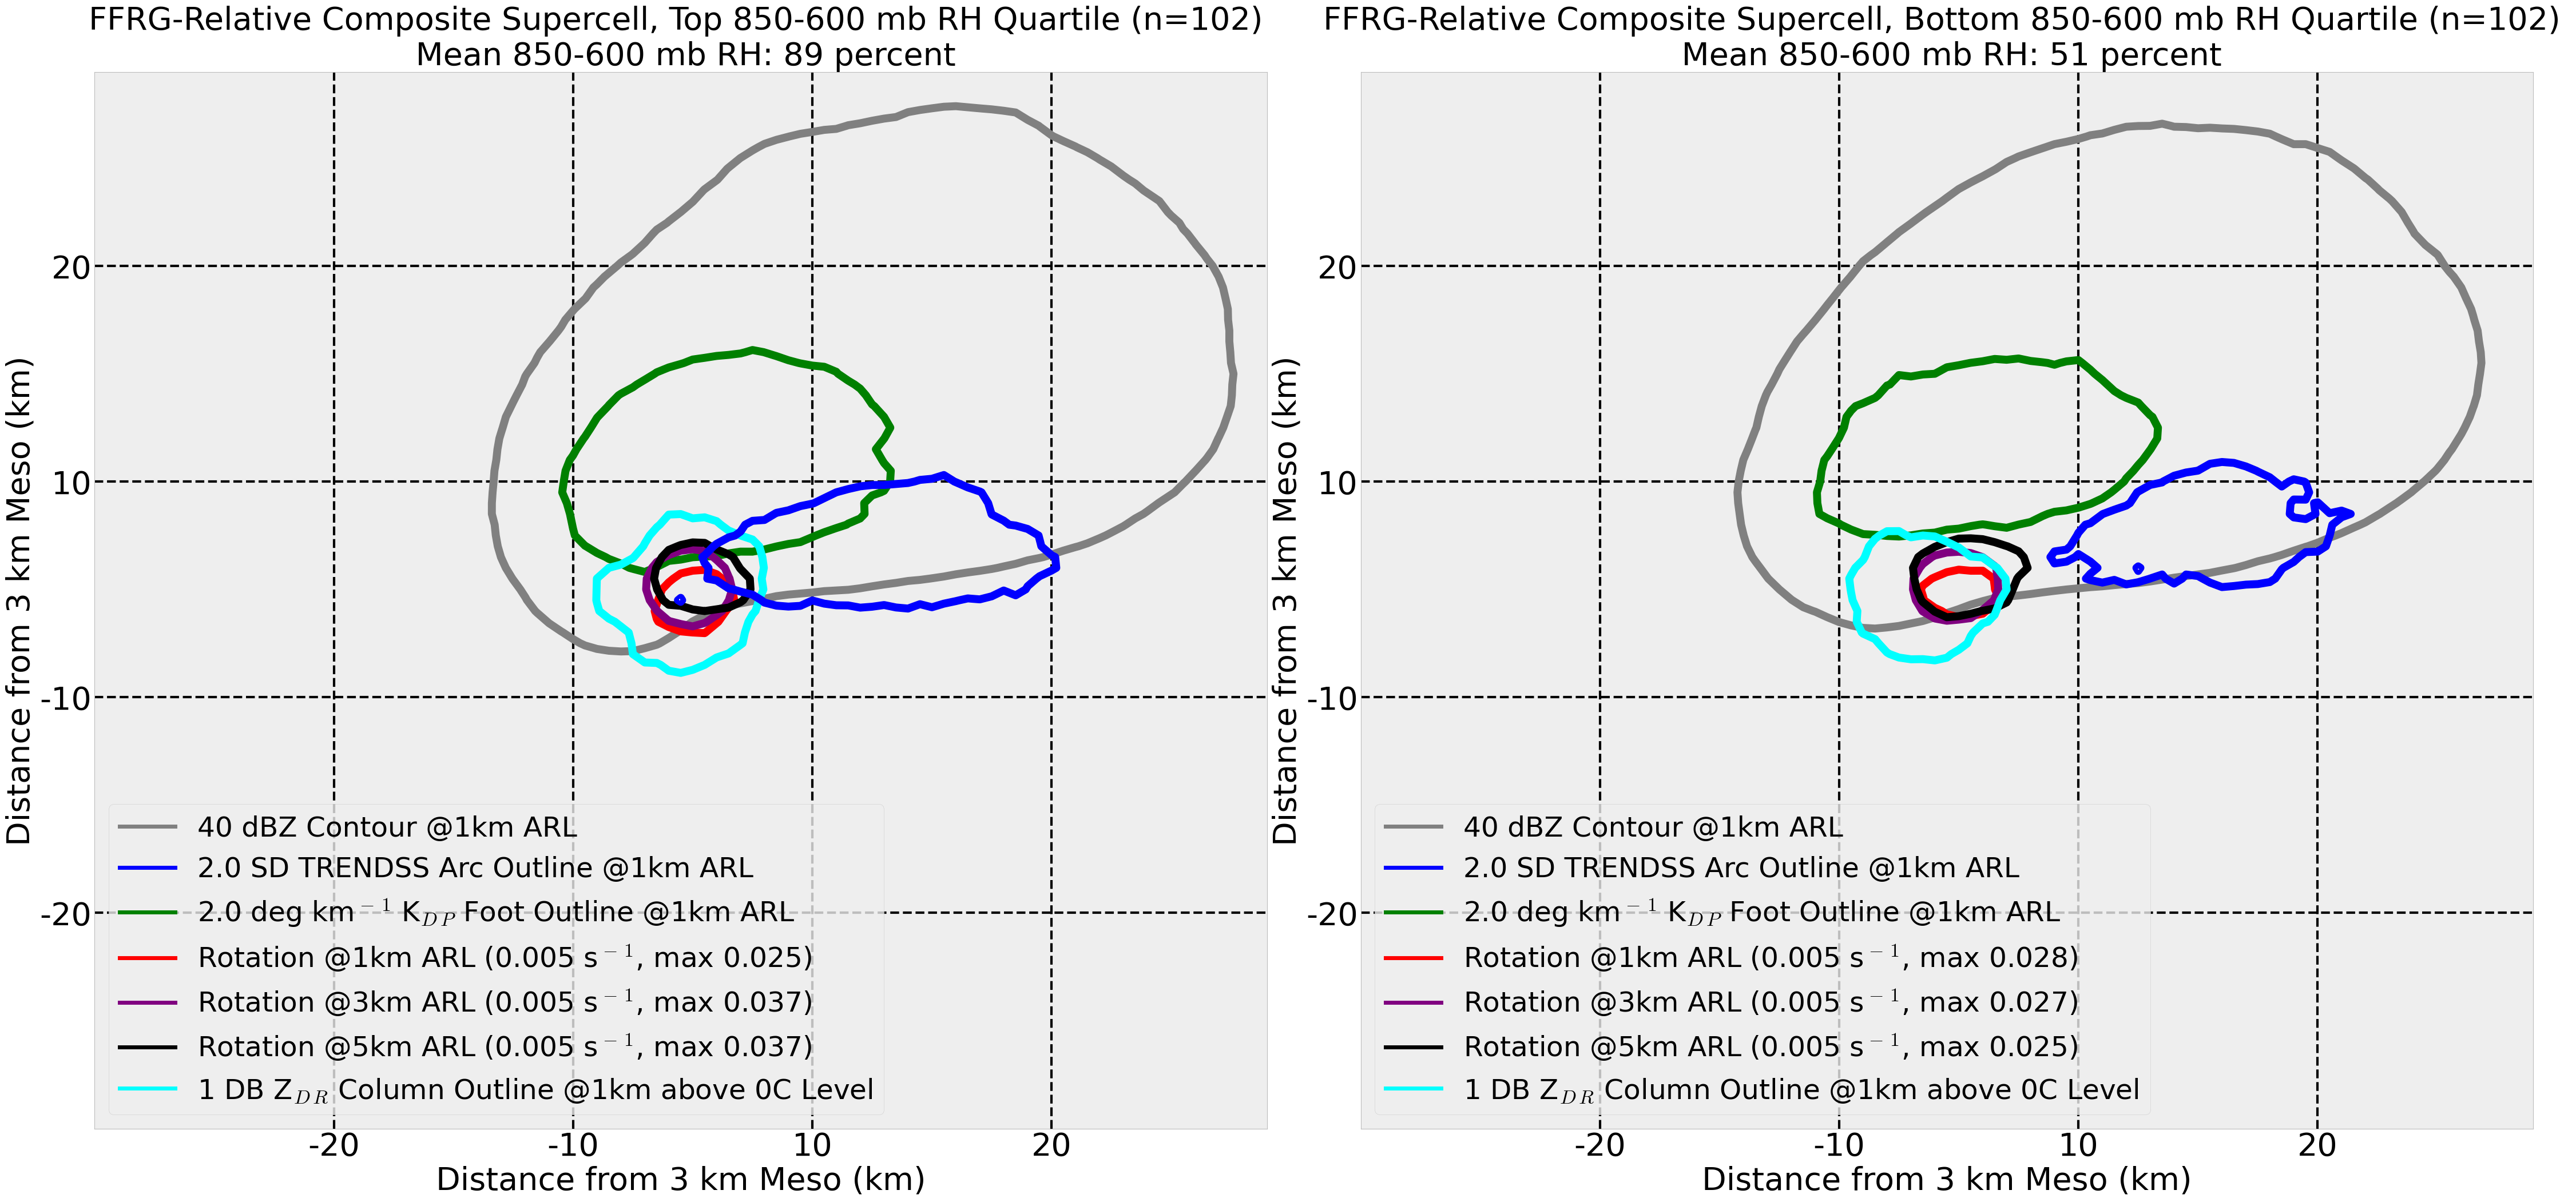

In [724]:
#Make a 2-panel figure
figure_layout = """
AB
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_layout, figsize=(55,24))

plt.sca(ax=axes['A'])
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp1 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005], colors='r', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp2 = plt.contour(xr11, yr11, rot3_pm, [0.005], colors='purple', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005], colors='k', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, nzdr_pm, [2.0], colors='b', linewidths=10, zorder=12)
rotp1 = plt.contour(xr11, yr11, kdp_pm, [2.0], colors='g', linewidths=10)

#refp2 = plt.contourf(xr11, yr11, ref_pm, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='cyan', linewidths=10, zorder=10)

#refd2 = plt.contourf(xr11, yr11, zdrd_pm*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

plt.title(titlestring1+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='blue', linewidth = 5, linestyle = 'solid', label='2.0 SD TRENDSS Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (0.005 s$^-$$^1$, max %.3f)' %np.max(rot1_pm[rot1_pm>0.005]))
rot2_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @3km ARL (0.005 s$^-$$^1$, max %.3f)' %np.max(rot3_pm[rot3_pm>0.005]))
rot5_outline = mlines.Line2D([], [], color='k', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (0.005 s$^-$$^1$, max %.3f)' %np.max(rot5_pm[rot5_pm>0.005]))
column_outline = mlines.Line2D([], [], color='cyan', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline @1km above 0C Level')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot2_outline, rot5_outline, column_outline], loc = 3, fontsize = 35)

plt.grid(linewidth=3, color='k', linestyle='--')

# cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
# cg2.ax.tick_params(labelsize=30)
# cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

# cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
# cg1.ax.tick_params(labelsize=30)
# cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from 3 km Meso (km)", size=40)
plt.ylabel("Distance from 3 km Meso (km)", size=40)
plt.xticks([20,40,60,80],[-20,-10,10,20],size=40)
plt.yticks([20,40,60,80],[-20,-10,10,20],size=40)

plt.sca(ax=axes['B'])
refp1 = plt.contour(xr11, yr11, ref_pm1, [35], colors='grey', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.005], colors='r', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp2 = plt.contour(xr11, yr11, rot3_pm1, [0.005], colors='purple', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm1, [0.005], colors='k', linewidths=10, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, nzdr_pm1, [2.0], colors='b', linewidths=10, zorder=12)
rotp1 = plt.contour(xr11, yr11, kdp_pm1, [2.0], colors='g', linewidths=10)

#refp2 = plt.contourf(xr11, yr11, ref_pm1, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm1, [4], colors='cyan', linewidths=10, zorder=10)

#refd2 = plt.contourf(xr11, yr11, zdrd_pm1*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

plt.title(titlestring2+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='blue', linewidth = 5, linestyle = 'solid', label='2.0 SD TRENDSS Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (0.005 s$^-$$^1$, max %.3f)' %np.max(rot1_pm1[rot1_pm1>0.005]))
rot2_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @3km ARL (0.005 s$^-$$^1$, max %.3f)' %np.max(rot3_pm1[rot3_pm1>0.005]))

rot5_outline = mlines.Line2D([], [], color='k', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (0.005 s$^-$$^1$, max %.3f)' %np.max(rot5_pm1[rot5_pm1>0.005]))
column_outline = mlines.Line2D([], [], color='cyan', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline @1km above 0C Level')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot2_outline, rot5_outline, column_outline], loc = 3, fontsize = 35)

plt.grid(linewidth=3, color='k', linestyle='--')

# cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
# cg2.ax.tick_params(labelsize=30)
# cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

# cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
# cg1.ax.tick_params(labelsize=30)
# cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from 3 km Meso (km)", size=40)
plt.ylabel("Distance from 3 km Meso (km)", size=40)
plt.xticks([20,40,60,80],[-20,-10,10,20],size=40)
plt.yticks([20,40,60,80],[-20,-10,10,20],size=40)

plt.subplots_adjust(wspace=+0.08)

#plt.savefig('AMS2025_plots/AC_StampPaperLINES'+save_string+'2panel.png', bbox_inches='tight')
plt.savefig('AMS2025_plots/TRENDSSAC_StampPaperLINES'+save_string+'2panel.png', bbox_inches='tight')

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\779719102.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  refp2 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\779719102.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\779719102.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\779719102.py:24: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.005], colors='r', linewidths=5, zorder=5, l

Text(0.5, 1.0, 'FFRG-Relative Composite Comparison \n (High-850-600 mb RH=solid, Low-850-600 mb RH=dashed)')

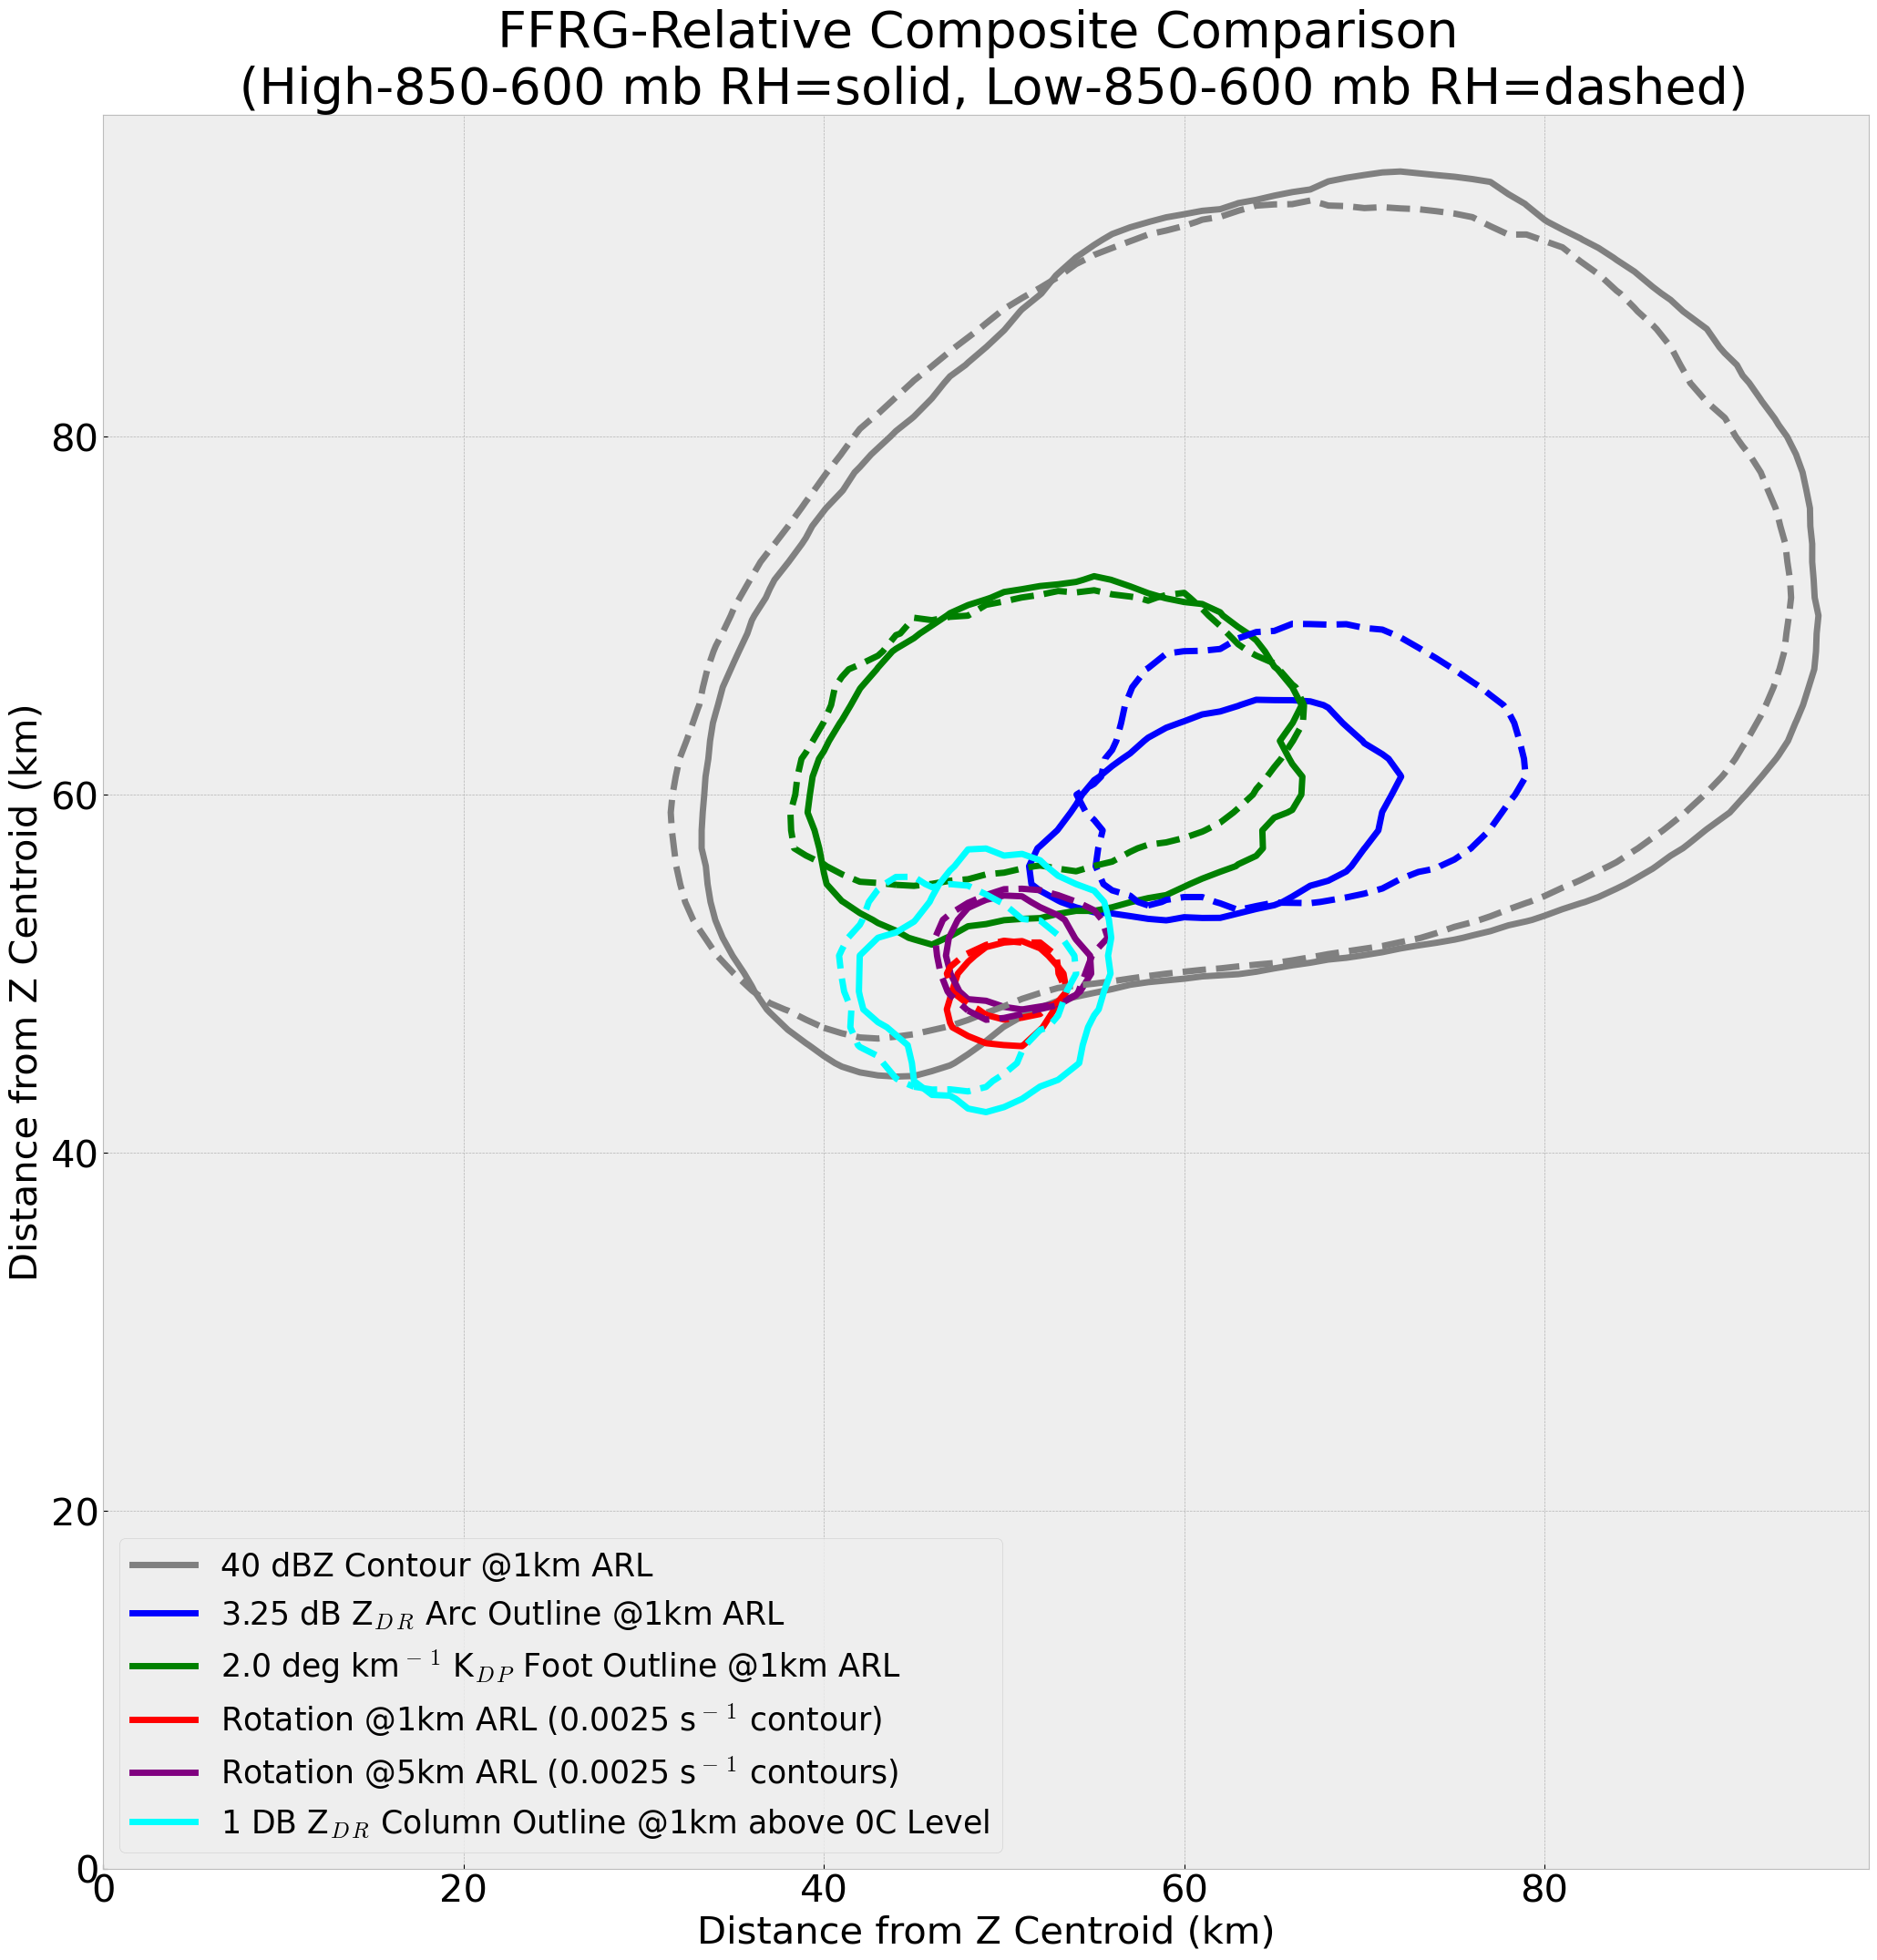

In [725]:
#Create a figure and plot up the initial data and contours for the algorithm
fig=plt.figure(1,figsize=(25.,25.))
# ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp2 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm, [3.5], colors='b', linewidths=5)
rotp1 = plt.contour(xr11, yr11, kdp_pm, [2.0], colors='g', linewidths=5)

#refp2 = plt.contourf(xr11, yr11, Z_pmm_allNT, np.arange(5,80,2), cmap=plt.cm.gist_ncar)
refp3 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='cyan', linewidths=5, zorder=10)

#refp2 = plt.contourf(xr11, yr11, ZD_pmm_allNT, np.arange(1,20,0.5), cmap=plt.cm.viridis)

refp2 = plt.contour(xr11, yr11, ref_pm1, [35], colors='grey', linewidths=5, zorder=5, linestyles='--')
rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.005], colors='r', linewidths=5, zorder=5, linestyles='--', label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm1, [0.005], colors='purple', linewidths=5, zorder=5, linestyles='--', label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm1, [3.5], colors='b', linewidths=5, linestyles='--')
rotp1 = plt.contour(xr11, yr11, kdp_pm1, [2.0], colors='g', linewidths=5, linestyles='--')

#refp2 = plt.contourf(xr11, yr11, Z_pmm_allNT, np.arange(5,80,2), cmap=plt.cm.gist_ncar)
refp3 = plt.contour(xr11, yr11, zdrd_pm1, [4], colors='cyan', linewidths=5, zorder=10, linestyles='--')

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='blue', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (0.0025 s$^-$$^1$ contour)')
rot5_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (0.0025 s$^-$$^1$ contours)')
column_outline = mlines.Line2D([], [], color='cyan', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline @1km above 0C Level')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot5_outline, column_outline], loc = 3, fontsize = 25)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel("Distance from Z Centroid (km)", size=30)
plt.ylabel("Distance from Z Centroid (km)", size=30)
plt.title(titlestring3, size=40)

#refp2 = plt.contourf(xr11, yr11, ZD_pmm_allNT, np.arange(1,20,0.5), cmap=plt.cm.viridis)
#plt.savefig('SupCompLines_TOR_NON_final.png')
#plt.savefig('AMS2025_plots/AC_'+save_string+'SHIFTEDcompplot3.png', bbox_inches='tight')

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2018239055.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  refp1 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2018239055.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2018239055.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2018239055.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh()

Text(0, 0.5, 'Distance from Z Centroid (km)')

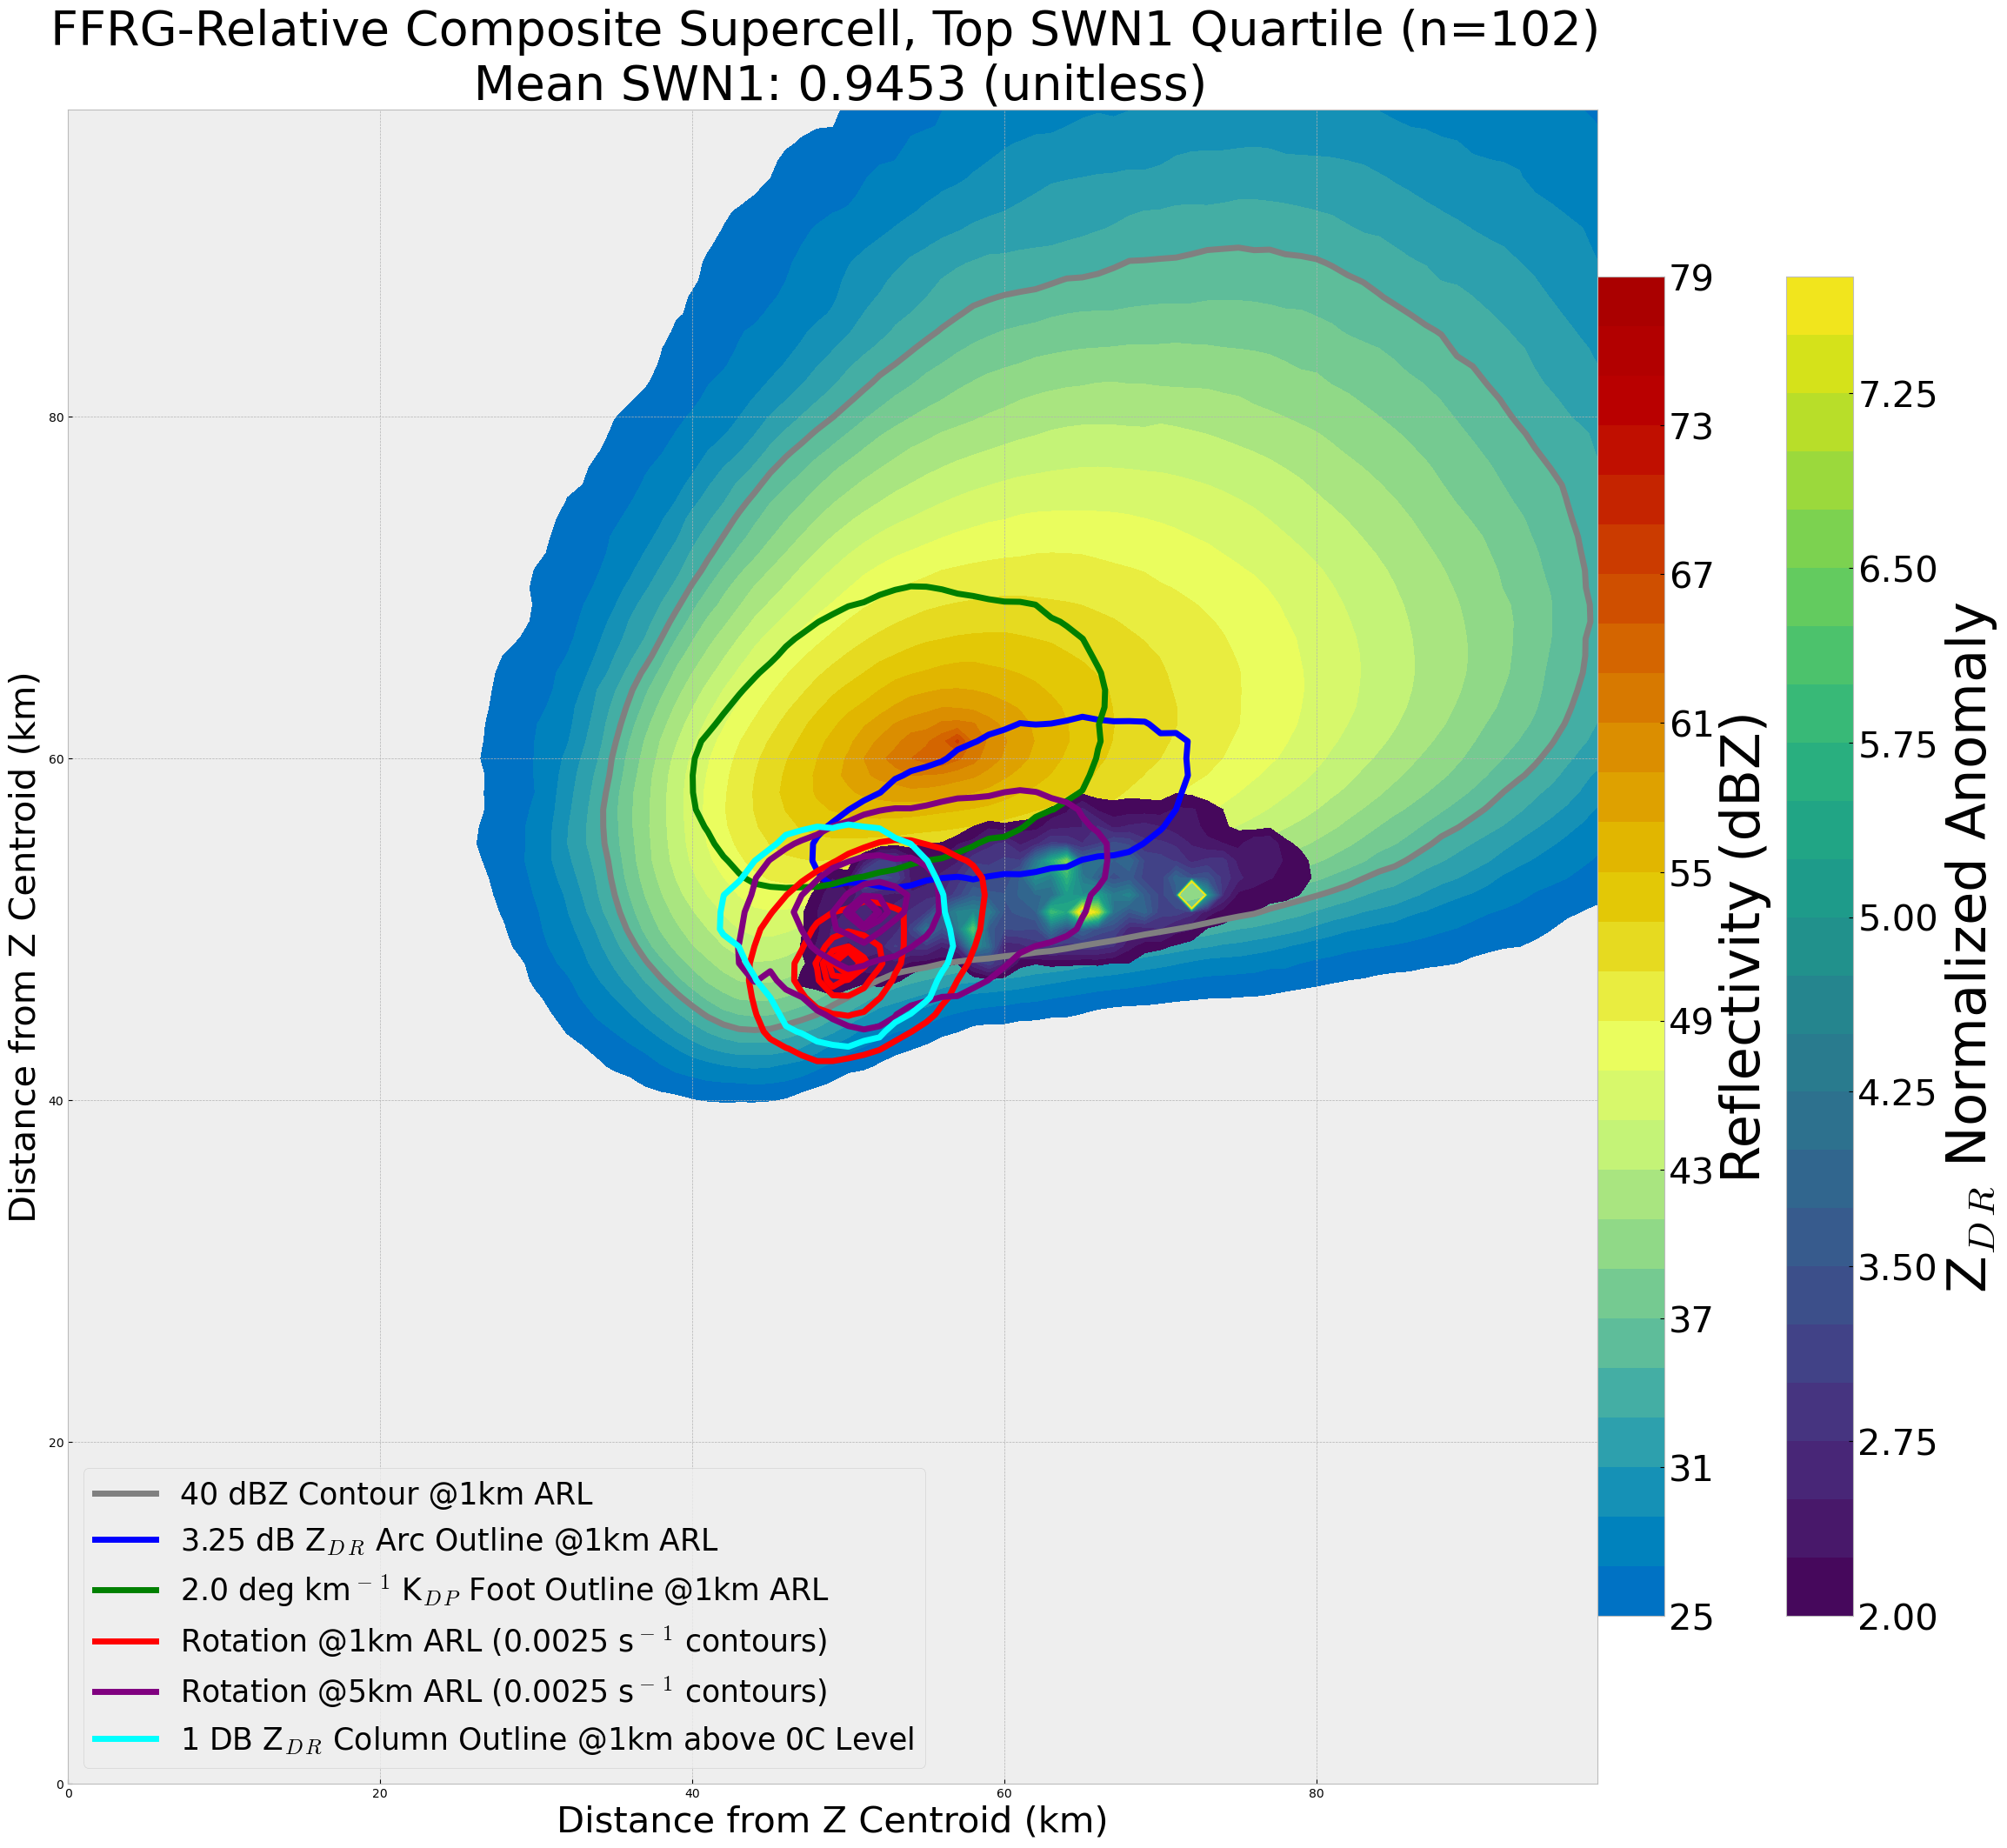

In [615]:
#Create a figure and plot up the initial data and contours for the algorithm
fig=plt.figure(1,figsize=(30.,25.))
# ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp1 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm, [3.5], colors='b', linewidths=5)
rotp1 = plt.contour(xr11, yr11, kdp_pm, [2.0], colors='g', linewidths=5)

refp2 = plt.contourf(xr11, yr11, ref_pm, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='cyan', linewidths=5, zorder=10)

refd2 = plt.contourf(xr11, yr11, nzdr_pm, np.arange(2,8,0.25), cmap=plt.cm.viridis)

plt.title(titlestring1+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='blue', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (0.0025 s$^-$$^1$ contours)')
rot5_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (0.0025 s$^-$$^1$ contours)')
column_outline = mlines.Line2D([], [], color='cyan', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline @1km above 0C Level')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot5_outline, column_outline], loc = 3, fontsize = 25)

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Normalized Anomaly",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from Z Centroid (km)", size=30)
plt.ylabel("Distance from Z Centroid (km)", size=30)

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3144703038.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  refp1 = plt.contour(xr11, yr11, ref_pm1, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3144703038.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3144703038.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pm1, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\3144703038.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormes

Text(0, 0.5, 'Distance from Z Centroid (km)')

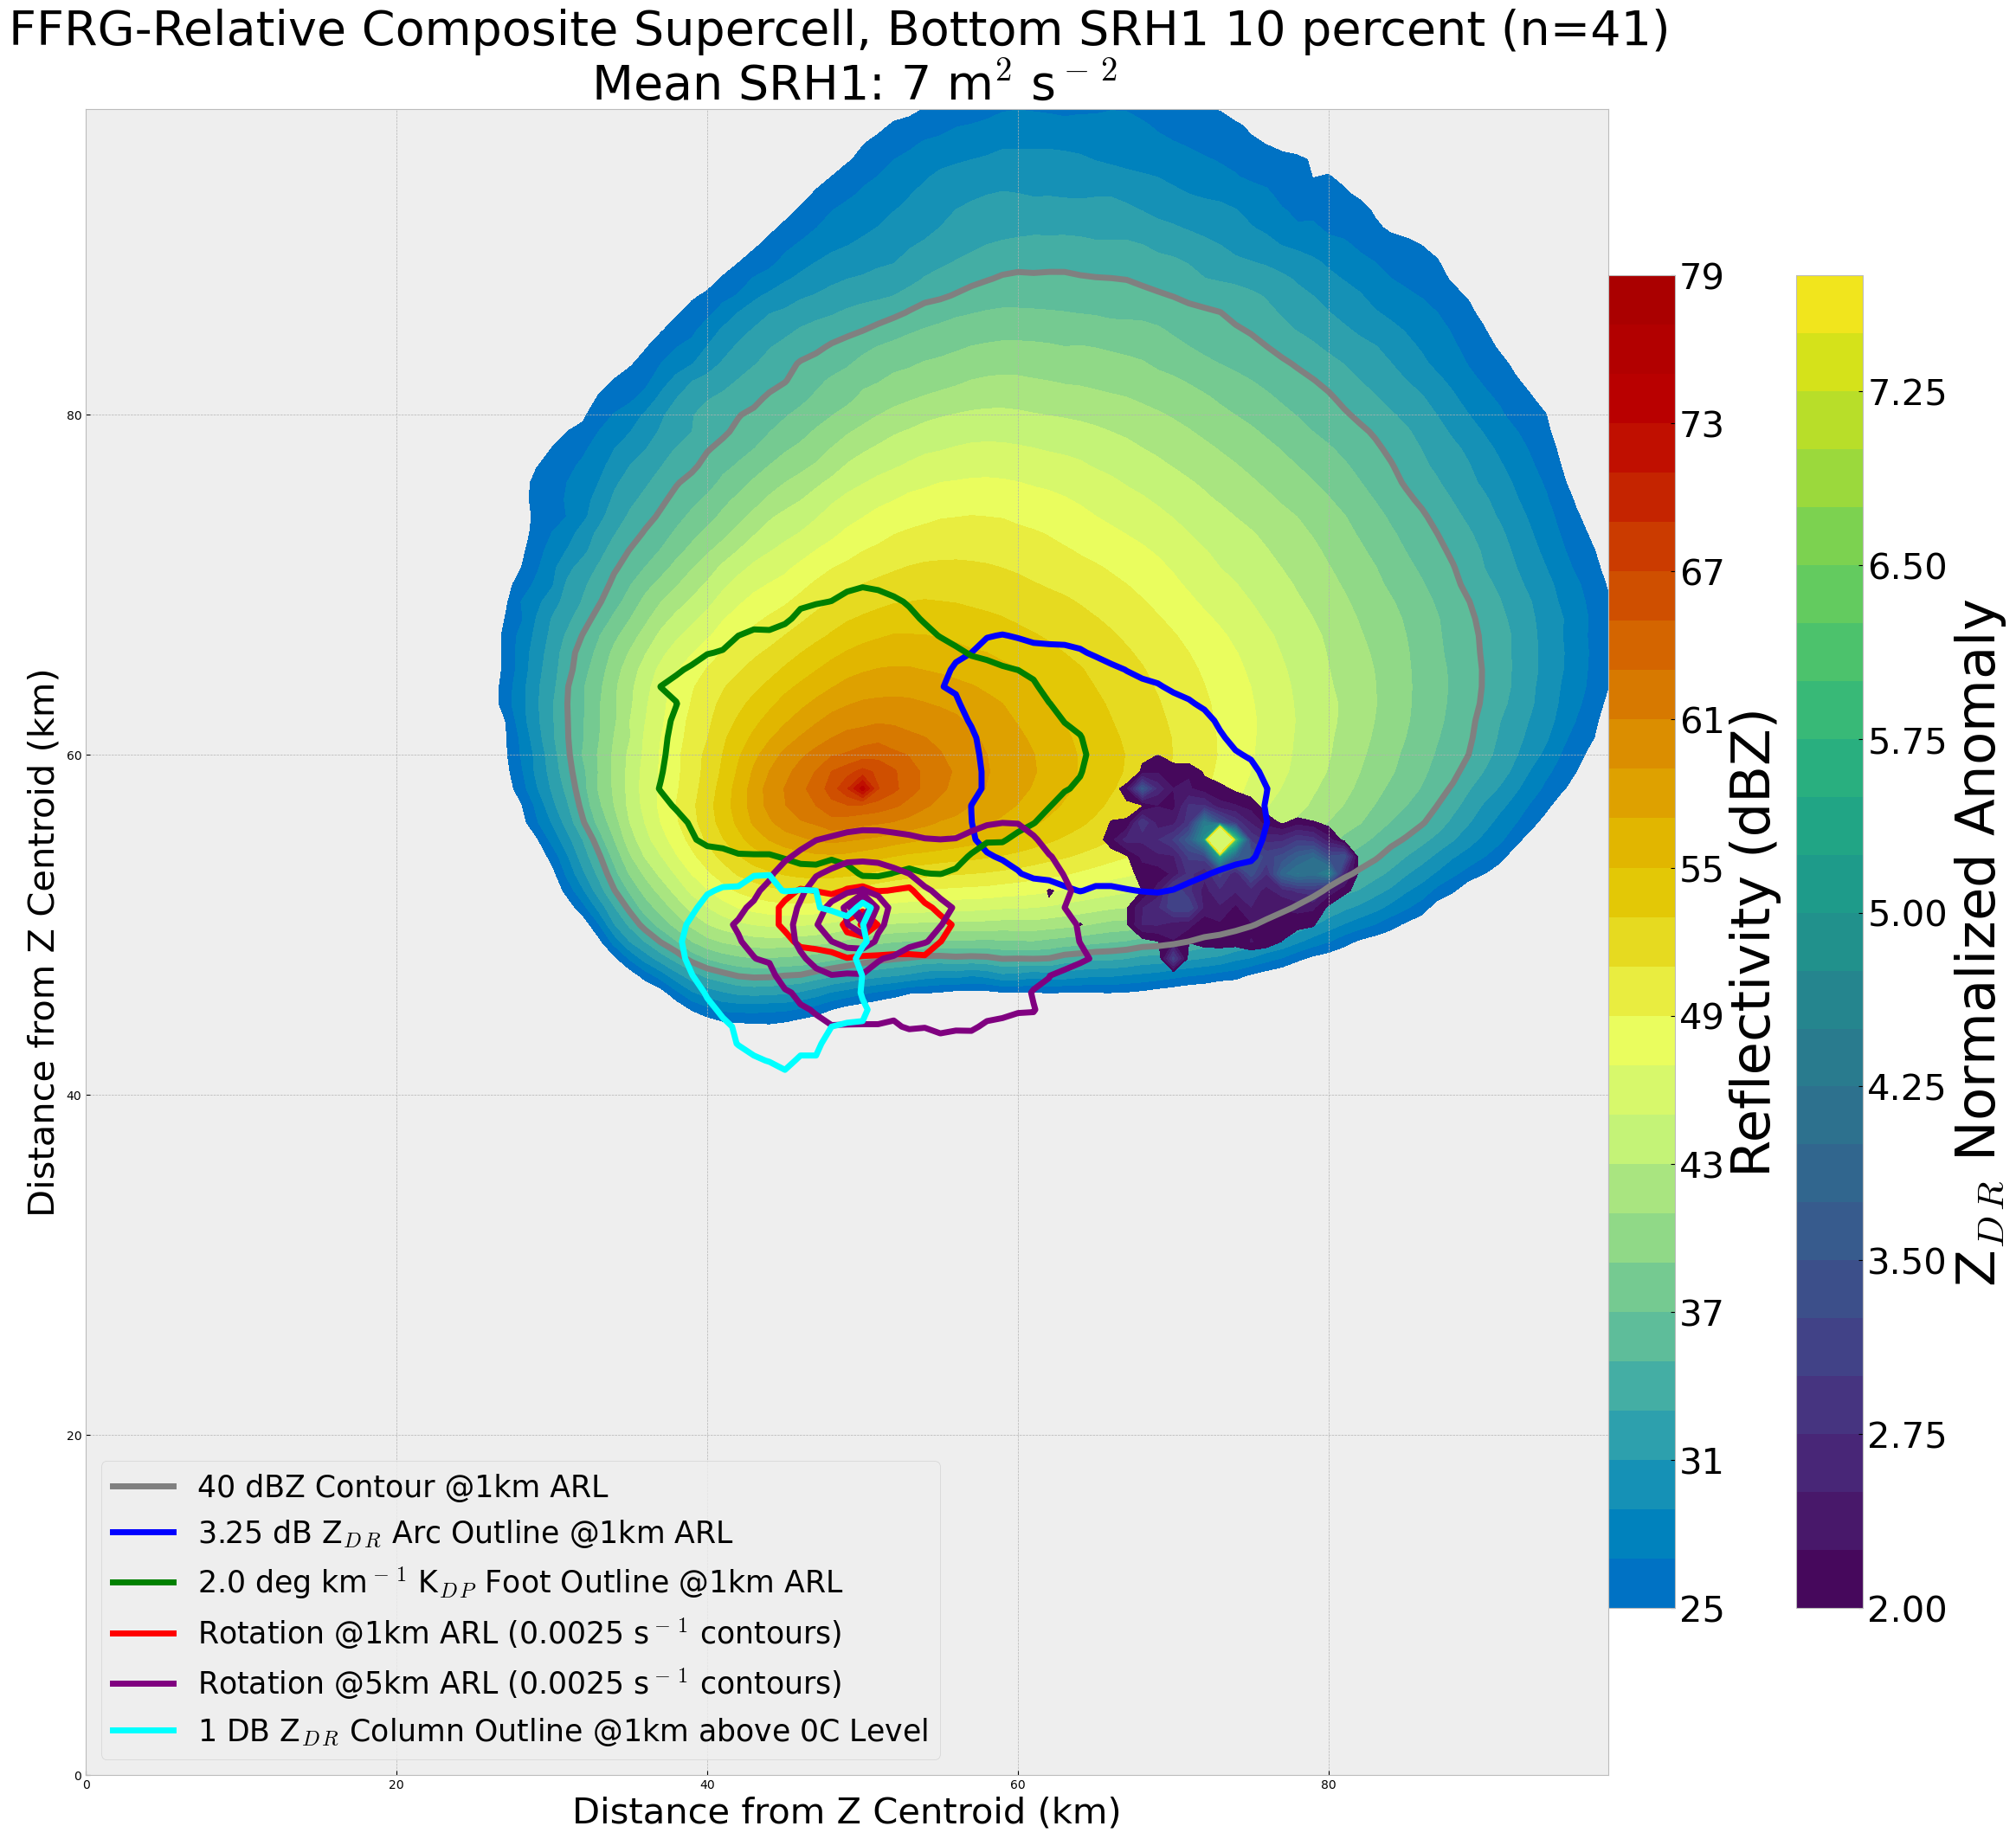

In [367]:
#Create a figure and plot up the initial data and contours for the algorithm
fig=plt.figure(1,figsize=(30.,25.))
# ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp1 = plt.contour(xr11, yr11, ref_pm1, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm1, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pm1, [3.5], colors='b', linewidths=5)
rotp1 = plt.contour(xr11, yr11, kdp_pm1, [2.0], colors='g', linewidths=5)

refp2 = plt.contourf(xr11, yr11, ref_pm1, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pm1, [4], colors='cyan', linewidths=5, zorder=10)

refd2 = plt.contourf(xr11, yr11, nzdr_pm1, np.arange(2,8,0.25), cmap=plt.cm.viridis)

plt.title(titlestring2+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='blue', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (0.0025 s$^-$$^1$ contours)')
#rot5_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (0.0025 s$^-$$^1$ contours)')
column_outline = mlines.Line2D([], [], color='cyan', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline @1km above 0C Level')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot5_outline, column_outline], loc = 3, fontsize = 25)

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Normalized Anomaly",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from Z Centroid (km)", size=30)
plt.ylabel("Distance from Z Centroid (km)", size=30)

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2975655968.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  refp2 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2975655968.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2975655968.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2975655968.py:24: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.005], colors='r', linewidths=5, zorder=

Text(0.5, 1.0, 'FFRG-Relative Composite Comparison \n (High-SRH1=solid, Low-SRH1=dashed)')

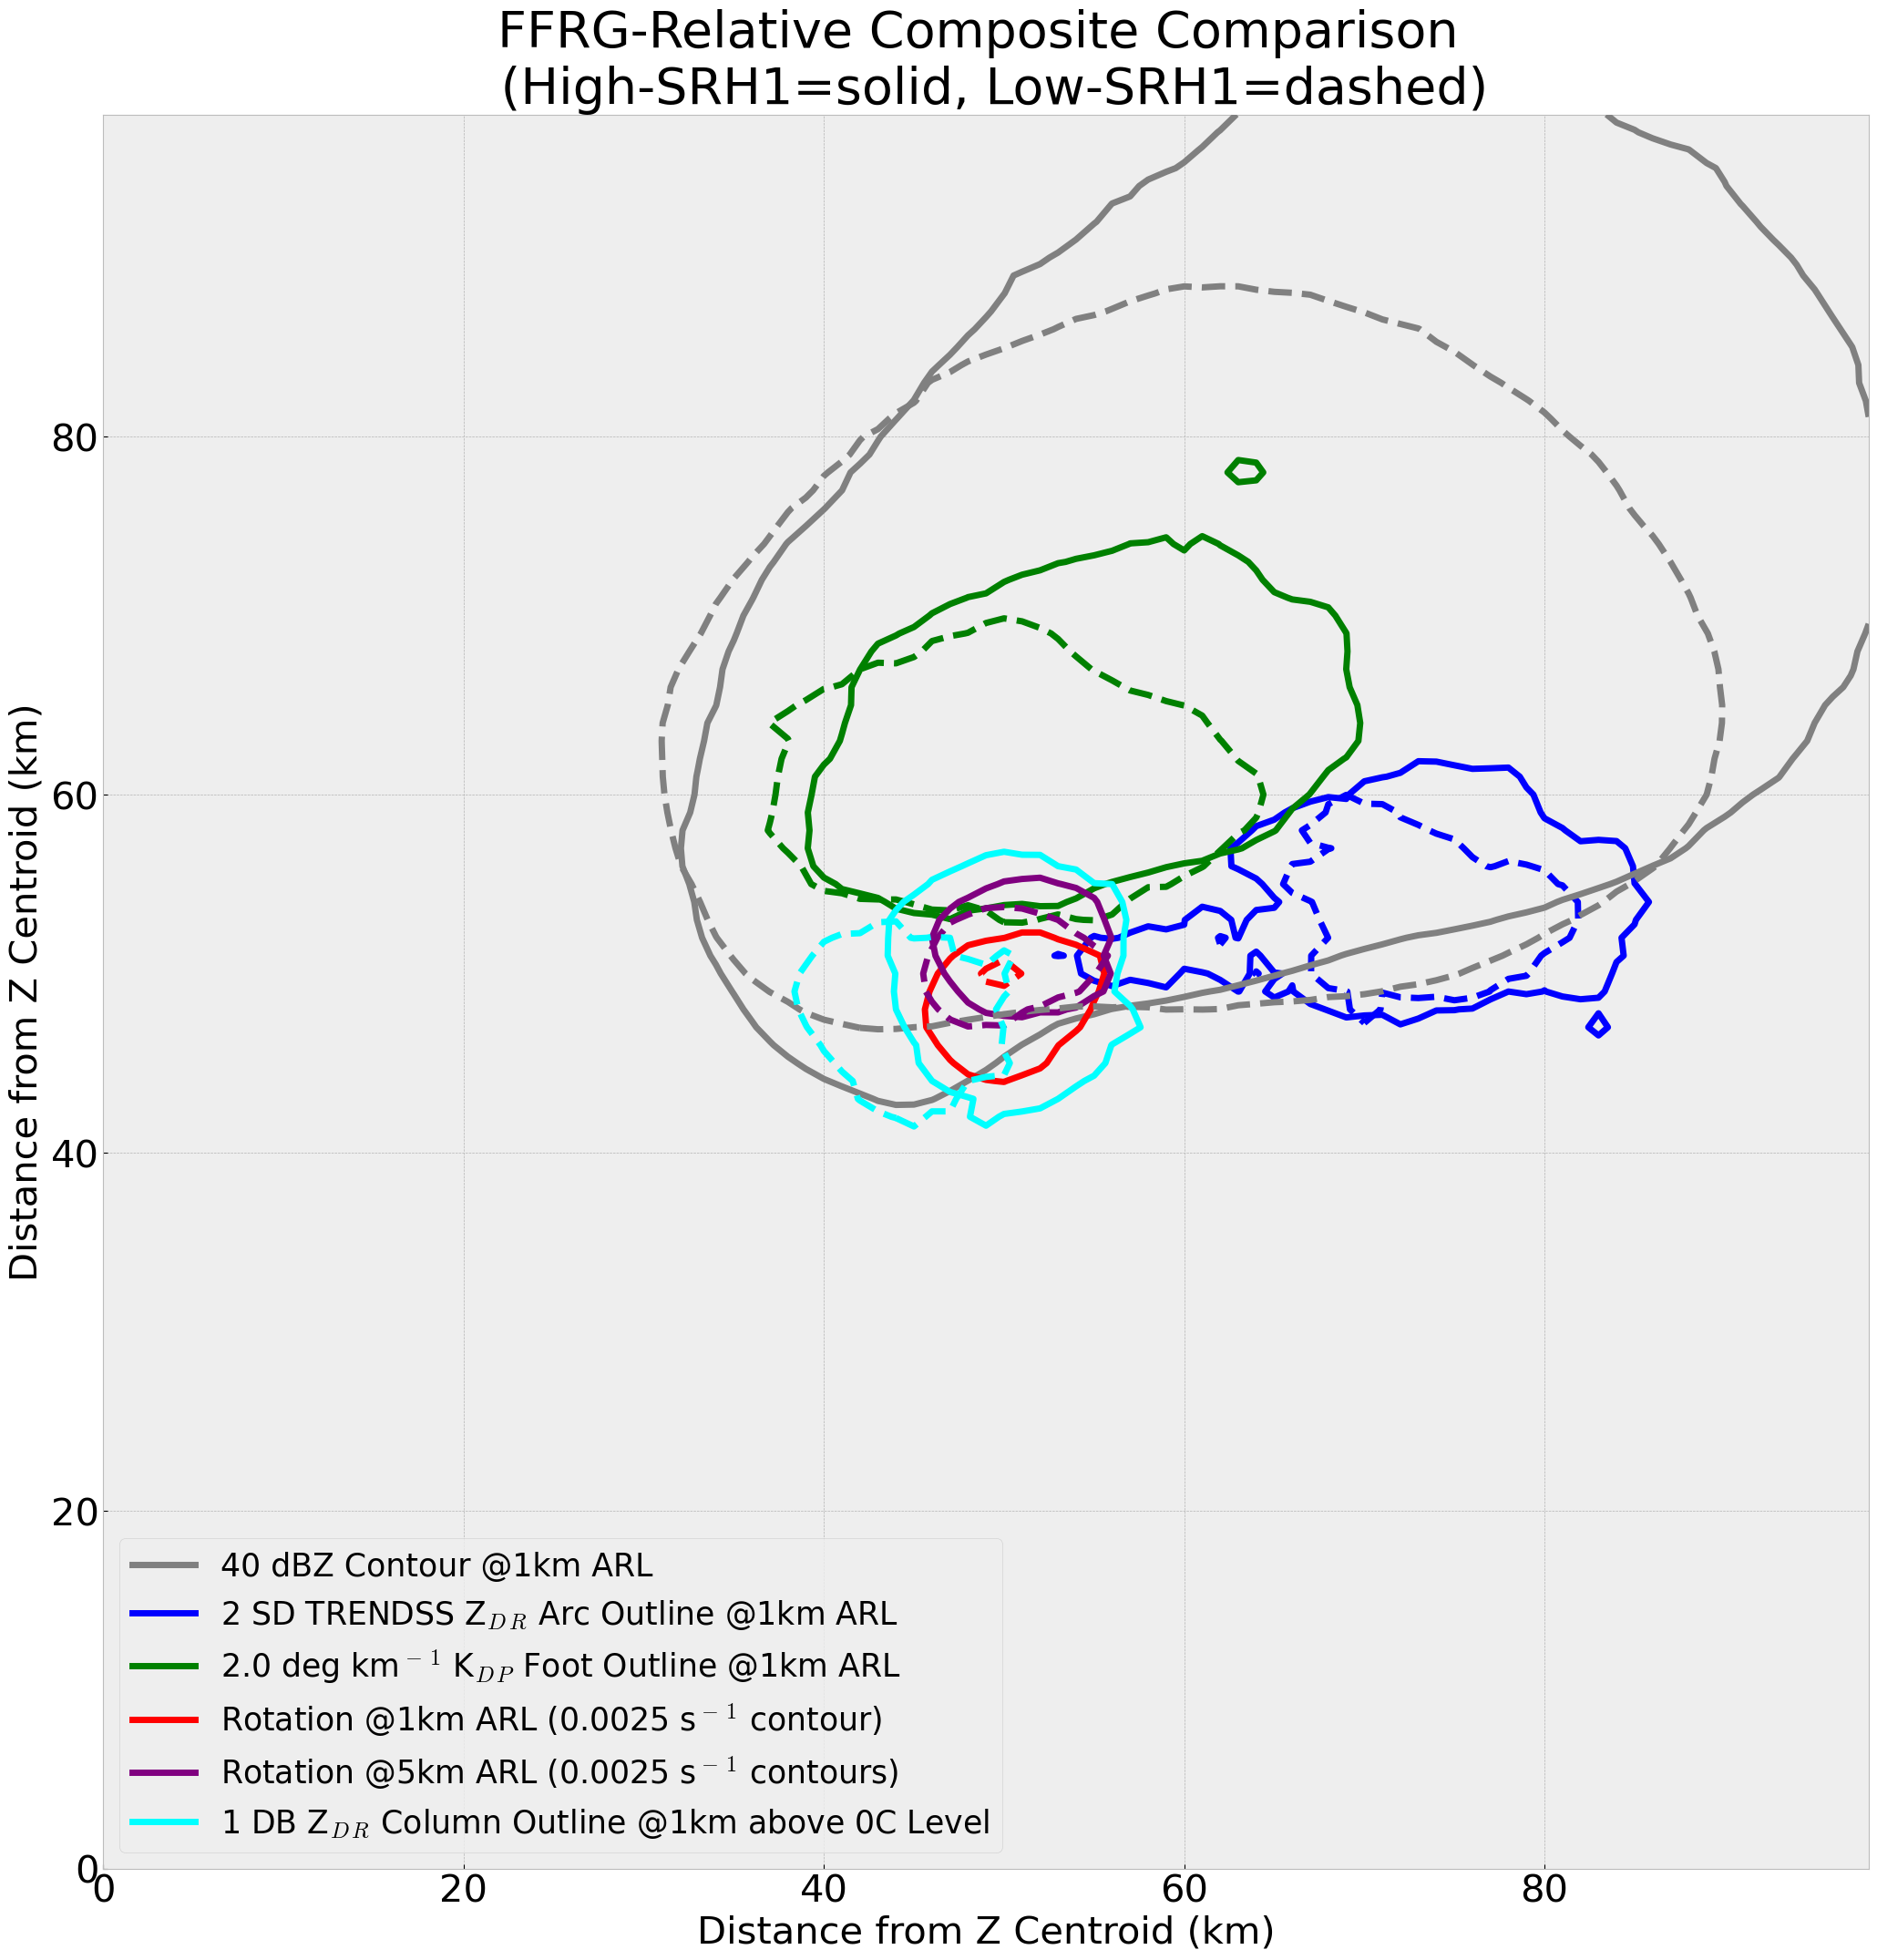

In [368]:
#Create a figure and plot up the initial data and contours for the algorithm
fig=plt.figure(1,figsize=(25.,25.))
# ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp2 = plt.contour(xr11, yr11, ref_pm, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pm, [0.005], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm, [0.005], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, nzdr_pm, [2.0], colors='b', linewidths=5)
rotp1 = plt.contour(xr11, yr11, kdp_pm, [2.0], colors='g', linewidths=5)

#refp2 = plt.contourf(xr11, yr11, Z_pmm_allNT, np.arange(5,80,2), cmap=plt.cm.gist_ncar)
refp3 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='cyan', linewidths=5, zorder=10)

#refp2 = plt.contourf(xr11, yr11, ZD_pmm_allNT, np.arange(1,20,0.5), cmap=plt.cm.viridis)

refp2 = plt.contour(xr11, yr11, ref_pm1, [35], colors='grey', linewidths=5, zorder=5, linestyles='--')
rotp1 = plt.contour(xr11, yr11, rot1_pm1, [0.005], colors='r', linewidths=5, zorder=5, linestyles='--', label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pm1, [0.005], colors='purple', linewidths=5, zorder=5, linestyles='--', label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, nzdr_pm1, [2.0], colors='b', linewidths=5, linestyles='--')
rotp1 = plt.contour(xr11, yr11, kdp_pm1, [2.0], colors='g', linewidths=5, linestyles='--')

#refp2 = plt.contourf(xr11, yr11, Z_pmm_allNT, np.arange(5,80,2), cmap=plt.cm.gist_ncar)
refp3 = plt.contour(xr11, yr11, zdrd_pm1, [4], colors='cyan', linewidths=5, zorder=10, linestyles='--')

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='blue', linewidth = 5, linestyle = 'solid', label='2 SD TRENDSS Z$_D$$_R$ Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (0.0025 s$^-$$^1$ contour)')
rot5_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (0.0025 s$^-$$^1$ contours)')
column_outline = mlines.Line2D([], [], color='cyan', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline @1km above 0C Level')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot5_outline, column_outline], loc = 3, fontsize = 25)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel("Distance from Z Centroid (km)", size=30)
plt.ylabel("Distance from Z Centroid (km)", size=30)
plt.title(titlestring3, size=40)

#refp2 = plt.contourf(xr11, yr11, ZD_pmm_allNT, np.arange(1,20,0.5), cmap=plt.cm.viridis)
#plt.savefig('SupCompLines_TOR_NON_final.png')
#plt.savefig('AMS2025_plots/AC_'+save_string+'SHIFTEDcompplottrendss3.png', bbox_inches='tight')

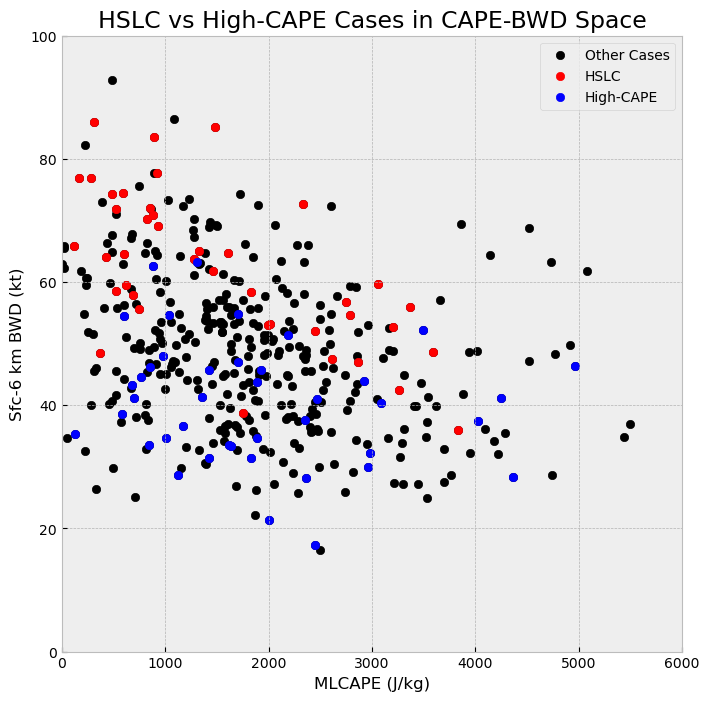

In [191]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(mlcape_arr, shr6_arr, c='k', label='Other Cases')
plt.scatter(np.asarray(mlcape_arr)[HSLC_index], np.asarray(shr6_arr)[HSLC_index], c='r', label='HSLC')
plt.scatter(np.asarray(mlcape_arr)[HC_index], np.asarray(shr6_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('MLCAPE (J/kg)')
plt.ylabel('Sfc-6 km BWD (kt)')
plt.xlim(0,6000)
plt.ylim(0,100)
plt.title('HSLC vs High-CAPE Cases in CAPE-BWD Space', size=17)
plt.legend()
#plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\numpy\ma\core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\710312049.py:6: UserWarning: Warning: converting a masked element to nan.
  plt.scatter(np.asarray(mlcape_arr)[HSLC_index], np.asarray(srh1_arr)[HSLC_index], c='r', label='HSLC')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\710312049.py:7: UserWarning: Warning: converting a masked element to nan.
  plt.scatter(np.asarray(mlcape_arr)[HC_index], np.asarray(srh1_arr)[HC_index], c='b', label='High-CAPE')


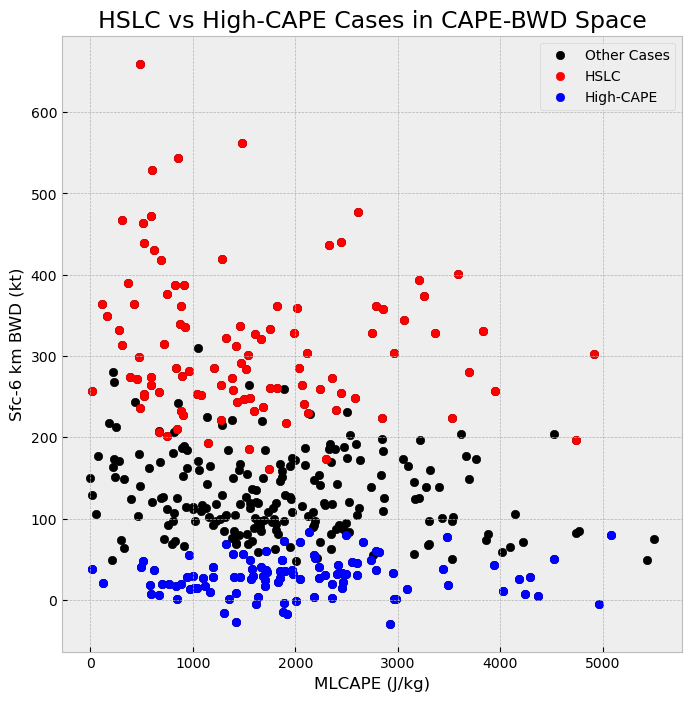

In [40]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(mlcape_arr, srh1_arr, c='k', label='Other Cases')
plt.scatter(np.asarray(mlcape_arr)[HSLC_index], np.asarray(srh1_arr)[HSLC_index], c='r', label='HSLC')
plt.scatter(np.asarray(mlcape_arr)[HC_index], np.asarray(srh1_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('MLCAPE (J/kg)')
plt.ylabel('Sfc-6 km BWD (kt)')
plt.title('HSLC vs High-CAPE Cases in CAPE-BWD Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

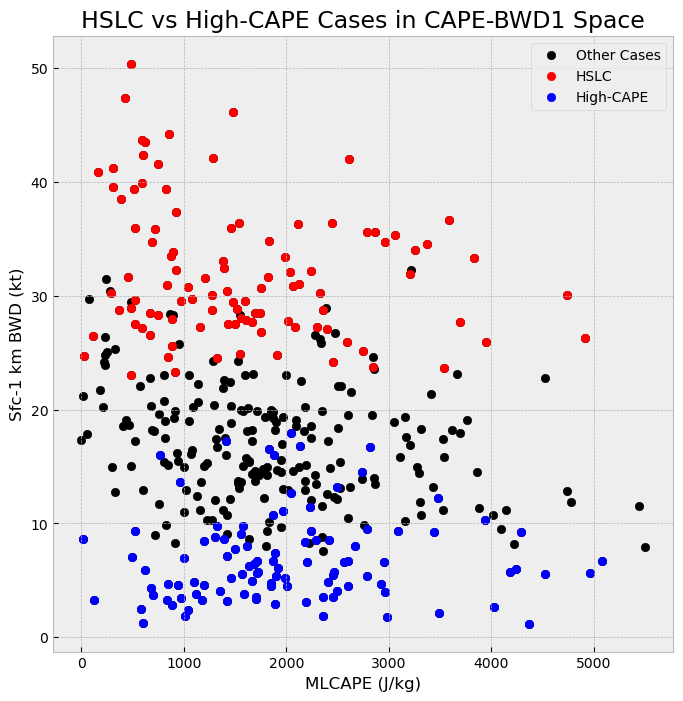

In [41]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(mlcape_arr, shr1_arr, c='k', label='Other Cases')
plt.scatter(np.asarray(mlcape_arr)[HSLC_index], np.asarray(shr1_arr)[HSLC_index], c='r', label='HSLC')
plt.scatter(np.asarray(mlcape_arr)[HC_index], np.asarray(shr1_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('MLCAPE (J/kg)')
plt.ylabel('Sfc-1 km BWD (kt)')
plt.title('HSLC vs High-CAPE Cases in CAPE-BWD1 Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\numpy\ma\core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\110857924.py:6: UserWarning: Warning: converting a masked element to nan.
  plt.scatter(np.asarray(lcl_arr)[HSLC_index], np.asarray(srh1_arr)[HSLC_index], c='r', label='HSLC')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\110857924.py:7: UserWarning: Warning: converting a masked element to nan.
  plt.scatter(np.asarray(lcl_arr)[HC_index], np.asarray(srh1_arr)[HC_index], c='b', label='High-CAPE')


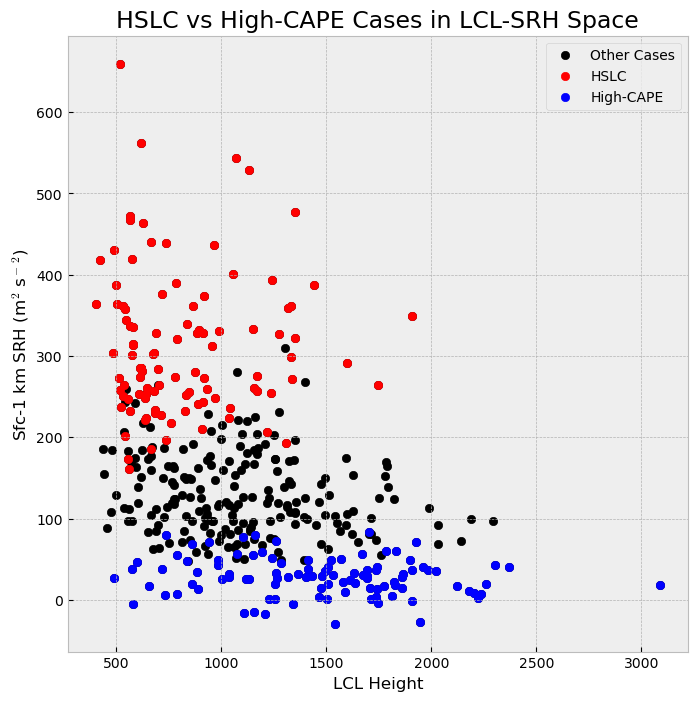

In [42]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(lcl_arr, srh1_arr, c='k', label='Other Cases')
plt.scatter(np.asarray(lcl_arr)[HSLC_index], np.asarray(srh1_arr)[HSLC_index], c='r', label='HSLC')
plt.scatter(np.asarray(lcl_arr)[HC_index], np.asarray(srh1_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('LCL Height')
plt.ylabel('Sfc-1 km SRH (m$^2$ s$^-$$^2$)')
plt.title('HSLC vs High-CAPE Cases in LCL-SRH Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

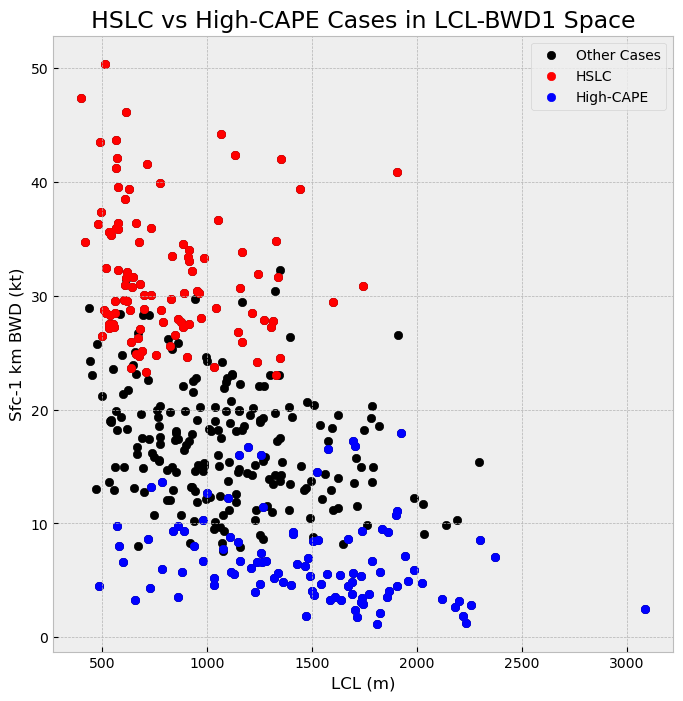

In [43]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(lcl_arr, shr1_arr, c='k', label='Other Cases')
plt.scatter(np.asarray(lcl_arr)[HSLC_index], np.asarray(shr1_arr)[HSLC_index], c='r', label='HSLC')
plt.scatter(np.asarray(lcl_arr)[HC_index], np.asarray(shr1_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('LCL (m)')
plt.ylabel('Sfc-1 km BWD (kt)')
plt.title('HSLC vs High-CAPE Cases in LCL-BWD1 Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

In [ ]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(srw02_arr, shr1_arr, c='k', label='Other Cases')
plt.scatter(np.asarray(srw02_arr)[HSLC_index], np.asarray(shr1_arr)[HSLC_index], c='r', label='HSLC')
plt.scatter(np.asarray(srw02_arr)[HC_index], np.asarray(shr1_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('0-2 km SRW (kt)')
plt.ylabel('Sfc-1 km BWD (kt)')
plt.title('HSLC vs High-CAPE Cases in SRW02-BWD1 Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

In [ ]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(srw02_arr, offhodo_devs_arr, c='k', label='Other Cases')
plt.scatter(np.asarray(srw02_arr)[HSLC_index], np.asarray(offhodo_devs_arr)[HSLC_index], c='r', label='HSLC')
plt.scatter(np.asarray(srw02_arr)[HC_index], np.asarray(offhodo_devs_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('0-2 km SRW (kt)')
plt.ylabel('Off-Hodograph Deviation from Bunkers RM (m s$^-$$^1$)')
plt.title('High RM vs Low RM Cases in SRW02-RM Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

In [ ]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
w_thingy=plt.scatter(srw01_arr1, swvort1_arr, c=w_meso, vmin=0, vmax=30, cmap=plt.cm.magma_r)
# plt.scatter(np.asarray(srw01_arr)[HSLC_index], np.asarray(swvort1_arr)[HSLC_index], c='r', label='High')
# plt.scatter(np.asarray(srw01_arr)[HC_index], np.asarray(swvort1_arr)[HC_index], c='b', label='Low')
plt.xlabel('0-1 km SRW (m s$^-$$^1$)')
plt.ylabel('Sfc-1 km Streamwise Vort (s$^-$$^1$)')
plt.title('High vs Low "Theoretical W" Cases in SRW01-SWV1 Space \n For a 0.01 s$^-$$^1$ Meso', size=17)
cg2 = plt.colorbar(w_thingy, shrink=0.80, pad=0)
cg2.ax.tick_params(labelsize=15)
cg2.set_label("Theoretical W (m s$^-$$^1$)",size = 18)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

In [ ]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(srw01_arr, swvort1_arr, c='k', label='Other Cases')
plt.scatter(np.asarray(srw01_arr)[HSLC_index], np.asarray(swvort1_arr)[HSLC_index], c='r', label='High')
plt.scatter(np.asarray(srw01_arr)[HC_index], np.asarray(swvort1_arr)[HC_index], c='b', label='Low')
plt.xlabel('0-1 km SRW (kt)')
plt.ylabel('Sfc-1 km Streamwise Vort (s$^-$$^1$)')
plt.title('High vs Low "Theoretical W" Cases in SRW01-SWV1 Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

In [ ]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(lcl_arr, cape3_arr, c='k', label='All Cases')
# plt.scatter(np.asarray(srw01_arr)[HSLC_index], np.asarray(swvort1_arr)[HSLC_index], c='r', label='HSLC')
# plt.scatter(np.asarray(srw01_arr)[HC_index], np.asarray(swvort1_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('LCL Height (m)')
plt.ylabel('Sfc-3 km CAPE (J kg$^-$$^1$)')
plt.title('LCL - 3CAPE Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

In [ ]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(srw02_arr, np.asarray(swvort1_arr)/1000, c='k', label='All Cases')
# plt.scatter(np.asarray(srw01_arr)[HSLC_index], np.asarray(swvort1_arr)[HSLC_index], c='r', label='HSLC')
# plt.scatter(np.asarray(srw01_arr)[HC_index], np.asarray(swvort1_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('0-2 km SR flow (kt)')
plt.ylabel('0-1 km Streamwise Vort (m s$^-$$^1$)')
plt.title('02 SRW - 01 SWVORT Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

In [ ]:
#Make some environment boxplots
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(lcl_arr, shr1_arr, c='k', label='All Cases')
# plt.scatter(np.asarray(srw01_arr)[HSLC_index], np.asarray(swvort1_arr)[HSLC_index], c='r', label='HSLC')
# plt.scatter(np.asarray(srw01_arr)[HC_index], np.asarray(swvort1_arr)[HC_index], c='b', label='High-CAPE')
plt.xlabel('LCL Height (m)')
plt.ylabel('Sfc-1 km Shear (kt)')
plt.title('LCL - SHR01 Space', size=17)
plt.legend()
# plt.savefig('HSLCenvscatter.png', bbox_inches='tight')

In [ ]:
#print(HC_index[0].shape[0])
for i in range(HC_index[0].shape[0]):
    print(HC_index[0][i])
    print(ALL_years[HC_index][i], ALL_months[HC_index][i], ALL_days[HC_index][i], ALL_sites[HC_index][i])

In [ ]:
for i in range(HSLC_index[0].shape[0]):
    print(HSLC_index[0][i])
    print(ALL_years[HSLC_index][i], ALL_months[HSLC_index][i], ALL_days[HSLC_index][i], ALL_sites[HSLC_index][i])
    print(np.asarray(lcl_arr)[HSLC_index][i])

In [ ]:
plt.figure(1, figsize=(24,24))
xr2 = np.arange(0, 99, 1)
reflevs = np.arange(20, 70, 5)
zdrdlev = np.arange(1, 10, 1)
rotlev = np.arange(0.002,0.01, 0.002)
rotlev1 = np.arange(-0.02,0.022, 0.002)
zdrlev = np.arange(0,6,0.25)
# plt.contourf(xr, xr, ref_st[4, :, :], reflevs, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
# plt.contour(xr, xr, zdrd_st[:, :]/4, zdrdlev, cmap=plt.cm.viridis, linewidths=5)
plt.contourf(xr2, xr2, rot1_pm, rotlev1, cmap=plt.cm.seismic)
#plt.contourf(xr2, xr2, zdr_pm, zdrlev, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
print(np.nanpercentile(rot1_pm,99))
#plt.contourf(xr2, xr2, zdrd_pm/4, zdrdlev, cmap=plt.cm.viridis)
# plt.contour(xr2, xr2, rot1_pm, rotlev, colors='r', linewidths=4)
# plt.contour(xr2, xr2, rot3_pm, rotlev, colors='purple', linewidths=4)
# plt.contour(xr2, xr2, rot5_pm, rotlev, colors='blue', linewidths=4)

In [ ]:
print(np.max(rot1_pm))
print(np.min(rot1_pm))

In [ ]:
plt.figure(1, figsize=(24,24))
xr2 = np.arange(0, 99, 1)

for i in HSLC_index[0]:
#for i in np.arange(201,207,1):
#for i in [0]:
    #print(i)
    postage = pickle.load(open('SPORK_SHIFT_ROTATE3'+str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i])+'.pkl', 'rb'))
#     ref_array[i,:,:] = postage[2]
#     rot1_array[i,:,:] = postage[3]
#     rot3_array[i,:,:] = postage[4]
#     rot5_array[i,:,:] = postage[5]    
#     rot7_array[i,:,:] = postage[6]
#     zdrd_array[i,:,:] = postage[7]    
#     nzdr_array[i,:,:] = postage[8]
#     zdr_array[i,:,:] = postage[9]
#     kdp_array[i,:,:] = postage[10]
#     cc_array[i,:,:] = postage[11] 
    refp2 = plt.contour(xr11, yr11, postage[2], [35], colors='grey', linewidths=5, zorder=5, alpha=0.5)
    refp2 = plt.contour(xr11, yr11, postage[3], [0.0025], colors='r', linewidths=5, zorder=6)
    #refp2 = plt.contour(xr11, yr11, postage[7], [4], colors='r', linewidths=5, zorder=6)
    #refp2 = plt.contour(xr11, yr11, postage[3], [-0.0025], colors='b', linewidths=5, zorder=6)
#refp2 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='k', linewidths=5, zorder=6)   
refp2 = plt.contour(xr11, yr11, rot1_pm, [0.0025], colors='k', linewidths=5, zorder=6)   
refp2 = plt.contour(xr11, yr11, ref_pm, [35], colors='k', linestyles='--', linewidths=10, zorder=6)   
    #refp2 = plt.contour(xr11, yr11, postage[5], [0.005], colors='purple', linewidths=5, zorder=6)        

In [ ]:
plt.figure(1, figsize=(24,24))
xr2 = np.arange(0, 99, 1)
#xr11=xr2
for i in HC_index[0]:
#for i in np.arange(201,207,1):
#for i in [0]:
    #print(i)
    postage = pickle.load(open('SPORK_SHIFT_ROTATE3'+str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i])+'.pkl', 'rb'))
#     ref_array[i,:,:] = postage[2]
#     rot1_array[i,:,:] = postage[3]
#     rot3_array[i,:,:] = postage[4]
#     rot5_array[i,:,:] = postage[5]    
#     rot7_array[i,:,:] = postage[6]
#     zdrd_array[i,:,:] = postage[7]    
#     nzdr_array[i,:,:] = postage[8]
#     zdr_array[i,:,:] = postage[9]
#     kdp_array[i,:,:] = postage[10]
#     cc_array[i,:,:] = postage[11] 
    refp2 = plt.contour(xr11, yr11, postage[2], [35], colors='grey', linewidths=5, zorder=5, alpha=0.5)
    refp2 = plt.contour(xr11, yr11, postage[3], [0.0025], colors='r', linewidths=5, zorder=6)
    #refp2 = plt.contour(xr11, yr11, postage[7], [4], colors='r', linewidths=5, zorder=6)
    #refp2 = plt.contour(xr11, yr11, postage[3], [-0.0025], colors='b', linewidths=5, zorder=6)
#refp2 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='k', linewidths=5, zorder=6)   
refp2 = plt.contour(xr11, yr11, rot1_pm1, [0.0025], colors='k', linewidths=5, zorder=6)   
refp2 = plt.contour(xr11, yr11, ref_pm1, [35], colors='k', linestyles='--', linewidths=10, zorder=6)   
    #refp2 = plt.contour(xr11, yr11, postage[5], [0.005], colors='purple', linewidths=5, zorder=6)        

In [ ]:
rotlev1 = np.arange(-0.02,0.022, 0.002)



plt.style.use('bmh')
xr2 = np.arange(0, 99, 1)
xr2 = xr2 - 50
xr11=xr2
yr11=xr2
#for i in HSLC_index[0]:
for i in [9]:
#for i in np.arange(0,205,1):
#for i in [0]:
    #print(i)
    plt.figure(i+20, figsize=(24,24))
    postage = pickle.load(open('SPORK_ROTATE'+str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i])+'.pkl', 'rb'))
#     ref_array[i,:,:] = postage[2]
#     rot1_array[i,:,:] = postage[3]
#     rot3_array[i,:,:] = postage[4]
#     rot5_array[i,:,:] = postage[5]    
#     rot7_array[i,:,:] = postage[6]
#     zdrd_array[i,:,:] = postage[7]    
#     nzdr_array[i,:,:] = postage[8]
#     zdr_array[i,:,:] = postage[9]
#     kdp_array[i,:,:] = postage[10]
#     cc_array[i,:,:] = postage[11] 
#     refp2 = plt.contour(xr11, yr11, postage[2], [35], colors='grey', linewidths=5, zorder=5, alpha=0.5)
#     refp2 = plt.contour(xr11, yr11, postage[3], [0.0025], colors='r', linewidths=5, zorder=6)
#     refp2 = plt.contour(xr11, yr11, postage[3], [-0.0025], colors='b', linewidths=5, zorder=6)
    plt.contour(xr2, xr2, postage[4], rotlev1, cmap=plt.cm.seismic, linewidths=5)
    plt.contour(xr2, xr2, postage[7], [4], colors='cyan', linewidths=5)
    #plt.contourf(xr2, xr2, postage[9], zdrlev, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    plt.contourf(xr2, xr2, postage[2], np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    plt.contour(xr2, xr2, postage[3], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='k', linewidths=5)
    
    #refp2 = plt.contour(xr11, yr11, rot1_pm, [0.00125,0.0025,0.005], colors='k', linewidths=5, zorder=6)
    plt.title(str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i]), size=40)
    plt.xlim(-50,50)
    plt.ylim(-50,50)
    plt.xticks(np.arange(-50,50,5))
    plt.yticks(np.arange(-50,50,5))
    

    #plt.savefig('Storm'+str(i)+'_test.png')


    #refp2 = plt.contour(xr11, yr11, postage[5], [0.005], colors='purple', linewidths=5, zorder=6)        

In [ ]:
plt.style.use('bmh')
xr2 = np.arange(0, 99, 1)
xr2 = xr2 - 50
xr11=xr2
yr11=xr2
#for i in HSLC_index[0]:
#for i in [206]:
for i in range(len(ALL_years[index_pmm1])):
#for i in np.arange(0,205,1):
#for i in [0]:
    #print(i)
    plt.figure(i+20, figsize=(24,24))
    postage = pickle.load(open('SPORK_SHIFT_ROTATE'+str(ALL_years[index_pmm1][i])+str(ALL_months[index_pmm1][i])+str(ALL_days[index_pmm1][i])+str(ALL_sites[index_pmm1][i])+'.pkl', 'rb'))
#     ref_array[i,:,:] = postage[2]
#     rot1_array[i,:,:] = postage[3]
#     rot3_array[i,:,:] = postage[4]
#     rot5_array[i,:,:] = postage[5]    
#     rot7_array[i,:,:] = postage[6]
#     zdrd_array[i,:,:] = postage[7]    
#     nzdr_array[i,:,:] = postage[8]
#     zdr_array[i,:,:] = postage[9]
#     kdp_array[i,:,:] = postage[10]
#     cc_array[i,:,:] = postage[11] 
#     refp2 = plt.contour(xr11, yr11, postage[2], [35], colors='grey', linewidths=5, zorder=5, alpha=0.5)
#     refp2 = plt.contour(xr11, yr11, postage[3], [0.0025], colors='r', linewidths=5, zorder=6)
#     refp2 = plt.contour(xr11, yr11, postage[3], [-0.0025], colors='b', linewidths=5, zorder=6)
    plt.contour(xr2, xr2, postage[4], rotlev1, cmap=plt.cm.seismic, linewidths=5)
    plt.contour(xr2, xr2, postage[3], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='k', linewidths=5)
    plt.contour(xr2, xr2, postage[7], [4], colors='cyan', linewidths=5)
    #plt.contourf(xr2, xr2, postage[9], zdrlev, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    plt.contourf(xr2, xr2, postage[2], np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    
    #refp2 = plt.contour(xr11, yr11, rot1_pm, [0.00125,0.0025,0.005], colors='k', linewidths=5, zorder=6)
    plt.title(str(ALL_years[index_pmm1][i])+str(ALL_months[index_pmm1][i])+str(ALL_days[index_pmm1][i])+str(ALL_sites[index_pmm1][i]), size=40)
    plt.xlim(-50,50)
    plt.ylim(-50,50)
    plt.xticks(np.arange(-50,50,5))
    plt.yticks(np.arange(-50,50,5))
    

    plt.savefig('AStorm_SRH1'+str(i)+'_test.png')


In [ ]:
plt.style.use('bmh')
xr2 = np.arange(0, 99, 1)
xr2 = xr2 - 50
xr11=xr2
yr11=xr2
#for i in HSLC_index[0]:
#for i in [206]:
for i in range(len(ALL_years[index_pmm10])):
#for i in np.arange(0,205,1):
#for i in [0]:
    #print(i)
    plt.figure(i+20, figsize=(24,24))
    postage = pickle.load(open('SPORK_SHIFT_ROTATE'+str(ALL_years[index_pmm10][i])+str(ALL_months[index_pmm10][i])+str(ALL_days[index_pmm10][i])+str(ALL_sites[index_pmm10][i])+'.pkl', 'rb'))
#     ref_array[i,:,:] = postage[2]
#     rot1_array[i,:,:] = postage[3]
#     rot3_array[i,:,:] = postage[4]
#     rot5_array[i,:,:] = postage[5]    
#     rot7_array[i,:,:] = postage[6]
#     zdrd_array[i,:,:] = postage[7]    
#     nzdr_array[i,:,:] = postage[8]
#     zdr_array[i,:,:] = postage[9]
#     kdp_array[i,:,:] = postage[10]
#     cc_array[i,:,:] = postage[11] 
#     refp2 = plt.contour(xr11, yr11, postage[2], [35], colors='grey', linewidths=5, zorder=5, alpha=0.5)
#     refp2 = plt.contour(xr11, yr11, postage[3], [0.0025], colors='r', linewidths=5, zorder=6)
#     refp2 = plt.contour(xr11, yr11, postage[3], [-0.0025], colors='b', linewidths=5, zorder=6)
    plt.contour(xr2, xr2, postage[4], rotlev1, cmap=plt.cm.seismic, linewidths=5)
    plt.contour(xr2, xr2, postage[3], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='k', linewidths=5)
    plt.contour(xr2, xr2, postage[7], [4], colors='cyan', linewidths=5)
    #plt.contourf(xr2, xr2, postage[9], zdrlev, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    plt.contourf(xr2, xr2, postage[2], np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    
    #refp2 = plt.contour(xr11, yr11, rot1_pm, [0.00125,0.0025,0.005], colors='k', linewidths=5, zorder=6)
    plt.title(str(ALL_years[index_pmm10][i])+str(ALL_months[index_pmm10][i])+str(ALL_days[index_pmm10][i])+str(ALL_sites[index_pmm10][i]), size=40)
    plt.xlim(-50,50)
    plt.ylim(-50,50)
    plt.xticks(np.arange(-50,50,5))
    plt.yticks(np.arange(-50,50,5))
    

    plt.savefig('AStorm_10SRH1'+str(i)+'_test.png')


In [ ]:
plt.figure(1, figsize=(24,24))
xr2 = np.arange(0, 99, 1)
xr2 = xr2 - 50
#for i in HSLC_index[0]:
for i in [137]:
#for i in np.arange(201,207,1):
#for i in [0]:
    #print(i)
    postage = pickle.load(open('SPORK_SHIFT_ROTATE'+str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i])+'.pkl', 'rb'))
#     ref_array[i,:,:] = postage[2]
#     rot1_array[i,:,:] = postage[3]
#     rot3_array[i,:,:] = postage[4]
#     rot5_array[i,:,:] = postage[5]    
#     rot7_array[i,:,:] = postage[6]
#     zdrd_array[i,:,:] = postage[7]    
#     nzdr_array[i,:,:] = postage[8]
#     zdr_array[i,:,:] = postage[9]
#     kdp_array[i,:,:] = postage[10]
#     cc_array[i,:,:] = postage[11] 
#     refp2 = plt.contour(xr11, yr11, postage[2], [35], colors='grey', linewidths=5, zorder=5, alpha=0.5)
#     refp2 = plt.contour(xr11, yr11, postage[3], [0.0025], colors='r', linewidths=5, zorder=6)
#     refp2 = plt.contour(xr11, yr11, postage[3], [-0.0025], colors='b', linewidths=5, zorder=6)
    plt.contour(xr2, xr2, postage[5], rotlev1, cmap=plt.cm.seismic, linewidths=5)
    plt.contour(xr2, xr2, postage[7], [4], colors='cyan', linewidths=5)
    #plt.contourf(xr2, xr2, postage[9], zdrlev, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    plt.contourf(xr2, xr2, postage[2], np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    
#refp2 = plt.contour(xr11, yr11, rot1_pm, [0.00125,0.0025,0.005], colors='k', linewidths=5, zorder=6)
plt.title(str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i]), size=40)
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.xticks(np.arange(-50,50,5))
plt.yticks(np.arange(-50,50,5))

    #refp2 = plt.contour(xr11, yr11, postage[5], [0.005], colors='purple', linewidths=5, zorder=6)     

In [ ]:
plt.figure(1, figsize=(24,24))
xr2 = np.arange(0, 99, 1)

#for i in HSLC_index[0]:
for i in range(len(ALL_years)):

#for i in np.arange(201,207,1):
#for i in [0]:
    #print(i)
    postage = pickle.load(open('SPORK_SHIFT_ROTATE3'+str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i])+'.pkl', 'rb'))
#     ref_array[i,:,:] = postage[2]
#     rot1_array[i,:,:] = postage[3]
#     rot3_array[i,:,:] = postage[4]
#     rot5_array[i,:,:] = postage[5]    
#     rot7_array[i,:,:] = postage[6]
#     zdrd_array[i,:,:] = postage[7]    
#     nzdr_array[i,:,:] = postage[8]
#     zdr_array[i,:,:] = postage[9]
#     kdp_array[i,:,:] = postage[10]
#     cc_array[i,:,:] = postage[11] 
    refp2 = plt.contour(xr11, yr11, postage[2], [35], colors='grey', linewidths=5, zorder=5, alpha=0.5)
    refp2 = plt.contour(xr11, yr11, postage[5], [0.0025], colors='r', linewidths=5, zorder=6)
    #refp2 = plt.contour(xr11, yr11, postage[7], [4], colors='r', linewidths=5, zorder=6)
    #refp2 = plt.contour(xr11, yr11, postage[3], [-0.0025], colors='b', linewidths=5, zorder=6)
#refp2 = plt.contour(xr11, yr11, zdrd_pm, [4], colors='k', linewidths=5, zorder=6)   
refp2 = plt.contour(xr11, yr11, rot1_pm, [0.005], colors='k', linewidths=5, zorder=6)   
refp2 = plt.contour(xr11, yr11, ref_pm, [35], colors='k', linestyles='--', linewidths=10, zorder=6)   
    #refp2 = plt.contour(xr11, yr11, postage[5], [0.005], colors='purple', linewidths=5, zorder=6)        

In [ ]:
print(Z0C)

In [44]:
ref_pmall = _run_pmm_one_variable(ref_array)
rot1_pmall = _run_pmm_one_variable(rot1_array)
rot3_pmall = _run_pmm_one_variable(rot3_array)
rot5_pmall = _run_pmm_one_variable(rot5_array)
rot7_pmall = _run_pmm_one_variable(rot7_array)
nzdr_pmall = _run_pmm_one_variable(nzdr_array)
zdrd_pmall = _run_pmm_one_variable(zdrd_array)
zdr_pmall = _run_pmm_one_variable(zdr_array)
kdp_pmall = _run_pmm_one_variable(kdp_array)
cc_pmall = _run_pmm_one_variable(cc_array)

C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1263285892.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  refp1 = plt.contour(xr11, yr11, ref_pmall, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1263285892.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  rotp1 = plt.contour(xr11, yr11, rot1_pmall, [0.005, 0.01, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1263285892.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  rotp2 = plt.contour(xr11, yr11, rot3_pmall, [0.005, 0.01, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1263285892.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  rotp3 = plt.contour(xr11, yr11, rot5_pmall, [0.00

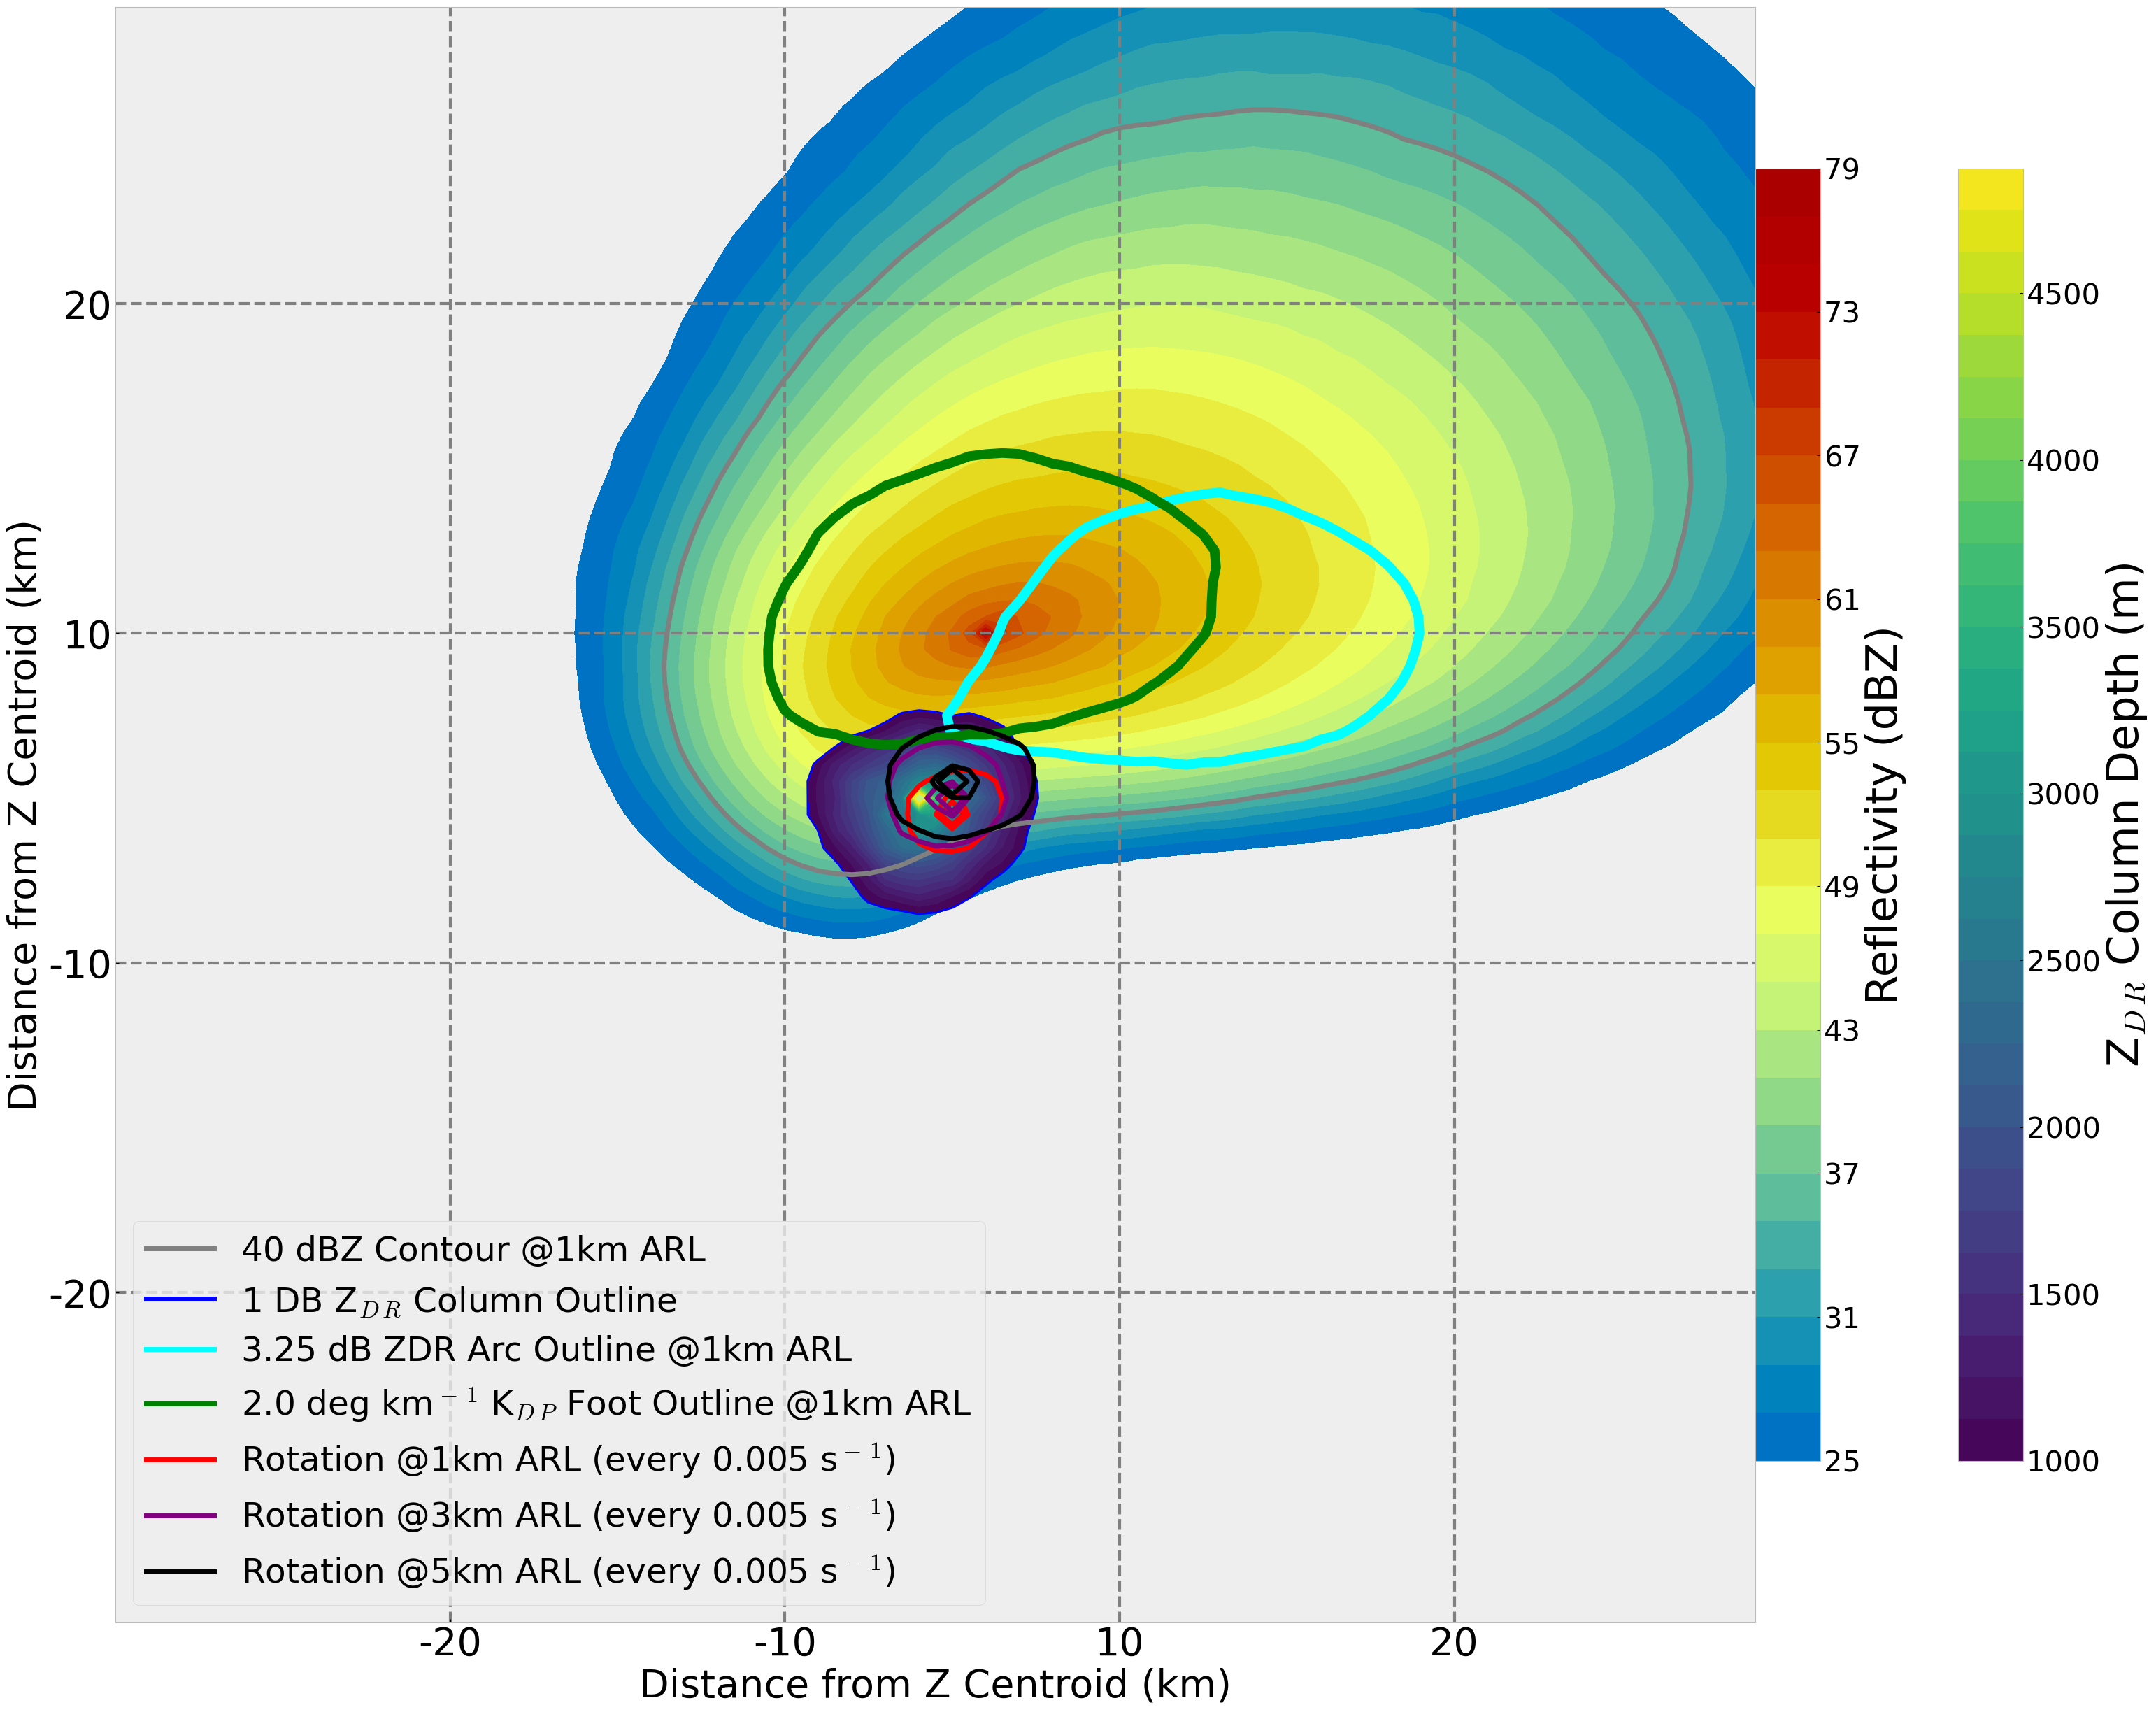

In [60]:
#Make a 2-panel figure
figure_layout = """
A
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_layout, figsize=(40,30))

plt.sca(ax=axes['A'])
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp1 = plt.contour(xr11, yr11, ref_pmall, [35], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pmall, [0.005, 0.01, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp2 = plt.contour(xr11, yr11, rot3_pmall, [0.005, 0.01, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pmall, [0.005, 0.01, 0.015], colors='k', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pmall, [3.25], colors='cyan', linewidths=10)
rotp1 = plt.contour(xr11, yr11, kdp_pmall, [2.0], colors='g', linewidths=10)


refp2 = plt.contourf(xr11, yr11, ref_pmall, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pmall, [4], colors='b', linewidths=5, zorder=1)

refd2 = plt.contourf(xr11, yr11, zdrd_pmall*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

#plt.title(titlestring1+unit_string, size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='cyan', linewidth = 5, linestyle = 'solid', label='3.25 dB ZDR Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (every 0.005 s$^-$$^1$)')
rot2_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @3km ARL (every 0.005 s$^-$$^1$)')
rot5_outline = mlines.Line2D([], [], color='k', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (every 0.005 s$^-$$^1$)')
column_outline = mlines.Line2D([], [], color='b', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline')

plt.legend(handles=[refl_outline, column_outline, zdr_outline, kdp_outline, rot1_outline, rot2_outline, rot5_outline], loc = 3, fontsize = 35)
#plt.legend(handles=[refl_outline, column_outline, zdr_outline, kdp_outline, rot1_outline, rot2_outline], loc = 3, fontsize = 35)

plt.grid(linewidth=3, color='grey', linestyle='--')

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from Z Centroid (km)", size=40)
plt.ylabel("Distance from Z Centroid (km)", size=40)
plt.xticks([20,40,60,80],[-20,-10,10,20],size=40)
plt.yticks([20,40,60,80],[-20,-10,10,20],size=40)

plt.savefig('AMS2025_plots/AllSuper_M5.png', bbox_inches='tight')

In [ ]:
#Create a figure and plot up the initial data and contours for the algorithm
fig=plt.figure(1,figsize=(30.,25.))
# ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
REFlevels = np.arange(20,73,2)
depth_levels= np.arange(0.01,23,1)
xr1 = np.arange(-50,49,1)

xr11, yr11 = np.meshgrid(xr2, xr2)

refp1 = plt.contour(xr11, yr11, ref_pmall, [40], colors='grey', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, rot1_pmall, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp3 = plt.contour(xr11, yr11, rot5_pmall, [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='purple', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')

#rotp1 = plt.contour(xr, xr, rot5_means[st_n], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='r', linewidths=5, zorder=5, label='40 dBZ Contour @ 1km ARL')
rotp1 = plt.contour(xr11, yr11, zdr_pmall, [3.5], colors='b', linewidths=5)
rotp1 = plt.contour(xr11, yr11, kdp_pmall, [2.0], colors='g', linewidths=5)

refp2 = plt.contourf(xr11, yr11, ref_pmall, np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
refp3 = plt.contour(xr11, yr11, zdrd_pmall, [4], colors='cyan', linewidths=5, zorder=10)

refd2 = plt.contourf(xr11, yr11, zdrd_pmall*250, np.arange(4,20,0.5)*250, cmap=plt.cm.viridis)

plt.title("All Cases Composite Supercell (n=409)", size=40)

refl_outline = mlines.Line2D([], [], color='grey', linewidth = 5, linestyle = 'solid', label='40 dBZ Contour @1km ARL')
zdr_outline = mlines.Line2D([], [], color='blue', linewidth = 5, linestyle = 'solid', label='3.25 dB Z$_D$$_R$ Arc Outline @1km ARL')
kdp_outline = mlines.Line2D([], [], color='green', linewidth = 5,linestyle = 'solid', label='2.0 deg km$^-$$^1$ K$_D$$_P$ Foot Outline @1km ARL')
rot1_outline = mlines.Line2D([], [], color='r', linewidth = 5,linestyle = 'solid', label='Rotation @1km ARL (0.0025 s$^-$$^1$ contours)')
rot5_outline = mlines.Line2D([], [], color='purple', linewidth = 5,linestyle = 'solid', label='Rotation @5km ARL (0.0025 s$^-$$^1$ contours)')
column_outline = mlines.Line2D([], [], color='cyan', linewidth = 5,linestyle = 'solid', label='1 DB Z$_D$$_R$ Column Outline @1km above 0C Level')

plt.legend(handles=[refl_outline, zdr_outline, kdp_outline, rot1_outline, rot5_outline, column_outline], loc = 3, fontsize = 25)

cg2 = plt.colorbar(refd2, shrink=0.80, pad=-0.04)
cg2.ax.tick_params(labelsize=30)
cg2.set_label("Z$_D$$_R$ Column Depth (m)",size = 45)

cg1 = plt.colorbar(refp2, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

plt.xlabel("Distance from Z Centroid (km)", size=30)
plt.ylabel("Distance from Z Centroid (km)", size=30)

plt.savefig('AC_ALLSHIFTEDplot3km.png', bbox_inches='tight')

In [231]:
print(stats.spearmanr(np.asarray(srw02_arr), np.asarray(swvort1_arr)))
srw02_srh1_nan = np.asarray(srw02_arr) * np.asarray(srh1_arr) 
print(stats.spearmanr(np.asarray(srw02_arr)[~np.isnan(srw02_srh1_nan)], np.asarray(srh1_arr)[~np.isnan(srw02_srh1_nan)]))
srw02_lcl_nan = np.asarray(srw02_arr) * np.asarray(lcl_arr) 
print(stats.spearmanr(np.asarray(srw02_arr)[~np.isnan(srw02_lcl_nan)], np.asarray(lcl_arr)[~np.isnan(srw02_lcl_nan)]))
srw02_mlcape_nan = np.asarray(srw02_arr) * np.asarray(mlcape_arr) 
print(stats.spearmanr(np.asarray(srw02_arr)[~np.isnan(srw02_mlcape_nan)], np.asarray(mlcape_arr)[~np.isnan(srw02_mlcape_nan)]))
srw02_shr6_nan = np.asarray(srw02_arr) * np.asarray(shr6_arr) 
print(stats.spearmanr(np.asarray(srw02_arr)[~np.isnan(srw02_shr6_nan)], np.asarray(shr6_arr)[~np.isnan(srw02_shr6_nan)]))
srw02_Z0C_nan = np.asarray(srw02_arr) * np.asarray(Z0C_arr) 
print(stats.spearmanr(np.asarray(srw02_arr)[~np.isnan(srw02_Z0C_nan)], np.asarray(Z0C_arr)[~np.isnan(srw02_Z0C_nan)]))


SpearmanrResult(correlation=0.12734860895279454, pvalue=0.009934852687217817)
SpearmanrResult(correlation=0.24583391774061145, pvalue=5.126267179096498e-07)
SpearmanrResult(correlation=0.14109473713750512, pvalue=0.004249157642150441)
SpearmanrResult(correlation=-0.06714894079762025, pvalue=0.1752974008807446)
SpearmanrResult(correlation=0.38563788924240455, pvalue=5.955399099760429e-16)
SpearmanrResult(correlation=-0.007571744781161316, pvalue=0.878664362051263)


C:\Users\matts\AppData\Local\Temp\ipykernel_85812\455941191.py:2: UserWarning: Warning: converting a masked element to nan.
  srw02_srh1_nan = np.asarray(srw02_arr) * np.asarray(srh1_arr)
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\455941191.py:3: UserWarning: Warning: converting a masked element to nan.
  print(stats.spearmanr(np.asarray(srw02_arr)[~np.isnan(srw02_srh1_nan)], np.asarray(srh1_arr)[~np.isnan(srw02_srh1_nan)]))


In [237]:
swvort1_srh1_nan = np.asarray(swvort1_arr) * np.asarray(srh1_arr) 
print(stats.spearmanr(np.asarray(swvort1_arr)[~np.isnan(swvort1_srh1_nan)], np.asarray(srh1_arr)[~np.isnan(swvort1_srh1_nan)]))
swvort1_lcl_nan = np.asarray(swvort1_arr) * np.asarray(lcl_arr) 
print(stats.spearmanr(np.asarray(swvort1_arr)[~np.isnan(swvort1_lcl_nan)], np.asarray(lcl_arr)[~np.isnan(swvort1_lcl_nan)]))
swvort1_mlcape_nan = np.asarray(swvort1_arr) * np.asarray(mlcape_arr) 
print(stats.spearmanr(np.asarray(swvort1_arr)[~np.isnan(swvort1_mlcape_nan)], np.asarray(mlcape_arr)[~np.isnan(swvort1_mlcape_nan)]))
swvort1_shr6_nan = np.asarray(swvort1_arr) * np.asarray(shr6_arr) 
print(stats.spearmanr(np.asarray(swvort1_arr)[~np.isnan(swvort1_shr6_nan)], np.asarray(shr6_arr)[~np.isnan(swvort1_shr6_nan)]))
swvort1_Z0C_nan = np.asarray(swvort1_arr) * np.asarray(Z0C_arr) 
print(stats.spearmanr(np.asarray(swvort1_arr)[~np.isnan(swvort1_Z0C_nan)], np.asarray(Z0C_arr)[~np.isnan(swvort1_Z0C_nan)]))

SpearmanrResult(correlation=0.9727068748366923, pvalue=4.5799035047916846e-259)
SpearmanrResult(correlation=-0.548208704437109, pvalue=1.8435351848331066e-33)
SpearmanrResult(correlation=-0.20272526686147055, pvalue=3.6231842900380786e-05)
SpearmanrResult(correlation=0.4047682523423824, pvalue=1.4810880139684524e-17)
SpearmanrResult(correlation=-0.002648093646188871, pvalue=0.957420720253428)


C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2974946006.py:1: UserWarning: Warning: converting a masked element to nan.
  swvort1_srh1_nan = np.asarray(swvort1_arr) * np.asarray(srh1_arr)
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\2974946006.py:2: UserWarning: Warning: converting a masked element to nan.
  print(stats.spearmanr(np.asarray(swvort1_arr)[~np.isnan(swvort1_srh1_nan)], np.asarray(srh1_arr)[~np.isnan(swvort1_srh1_nan)]))


In [244]:
srh1_lcl_nan = np.asarray(srh1_arr) * np.asarray(lcl_arr) 
print(stats.spearmanr(np.asarray(srh1_arr)[~np.isnan(srh1_lcl_nan)], np.asarray(lcl_arr)[~np.isnan(srh1_lcl_nan)]))
srh1_mlcape_nan = np.asarray(srh1_arr) * np.asarray(mlcape_arr) 
print(stats.spearmanr(np.asarray(srh1_arr)[~np.isnan(srh1_mlcape_nan)], np.asarray(mlcape_arr)[~np.isnan(srh1_mlcape_nan)]))
srh1_shr6_nan = np.asarray(srh1_arr) * np.asarray(shr6_arr) 
print(stats.spearmanr(np.asarray(srh1_arr)[~np.isnan(srh1_shr6_nan)], np.asarray(shr6_arr)[~np.isnan(srh1_shr6_nan)]))
srh1_Z0C_nan = np.asarray(srh1_arr) * np.asarray(Z0C_arr) 
print(stats.spearmanr(np.asarray(srh1_arr)[~np.isnan(srh1_Z0C_nan)], np.asarray(Z0C_arr)[~np.isnan(srh1_Z0C_nan)]))

SpearmanrResult(correlation=-0.507450569823795, pvalue=5.068026109153118e-28)
SpearmanrResult(correlation=-0.1945494202086494, pvalue=7.79467811301428e-05)
SpearmanrResult(correlation=0.44917507797832346, pvalue=1.3293161671055013e-21)
SpearmanrResult(correlation=-0.0009125653141880323, pvalue=0.9853566933781738)


C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1937695865.py:1: UserWarning: Warning: converting a masked element to nan.
  srh1_lcl_nan = np.asarray(srh1_arr) * np.asarray(lcl_arr)
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1937695865.py:2: UserWarning: Warning: converting a masked element to nan.
  print(stats.spearmanr(np.asarray(srh1_arr)[~np.isnan(srh1_lcl_nan)], np.asarray(lcl_arr)[~np.isnan(srh1_lcl_nan)]))
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1937695865.py:3: UserWarning: Warning: converting a masked element to nan.
  srh1_mlcape_nan = np.asarray(srh1_arr) * np.asarray(mlcape_arr)
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1937695865.py:4: UserWarning: Warning: converting a masked element to nan.
  print(stats.spearmanr(np.asarray(srh1_arr)[~np.isnan(srh1_mlcape_nan)], np.asarray(mlcape_arr)[~np.isnan(srh1_mlcape_nan)]))
C:\Users\matts\AppData\Local\Temp\ipykernel_85812\1937695865.py:5: UserWarning: Warning: converting a masked element to nan.
  sr

In [247]:
lcl_mlcape_nan = np.asarray(lcl_arr) * np.asarray(mlcape_arr) 
print(stats.spearmanr(np.asarray(lcl_arr)[~np.isnan(lcl_mlcape_nan)], np.asarray(mlcape_arr)[~np.isnan(lcl_mlcape_nan)]))
lcl_shr6_nan = np.asarray(lcl_arr) * np.asarray(shr6_arr) 
print(stats.spearmanr(np.asarray(lcl_arr)[~np.isnan(lcl_shr6_nan)], np.asarray(shr6_arr)[~np.isnan(lcl_shr6_nan)]))
lcl_Z0C_nan = np.asarray(lcl_arr) * np.asarray(Z0C_arr) 
print(stats.spearmanr(np.asarray(lcl_arr)[~np.isnan(lcl_Z0C_nan)], np.asarray(Z0C_arr)[~np.isnan(lcl_Z0C_nan)]))

SpearmanrResult(correlation=0.13160330862621153, pvalue=0.007699595303268265)
SpearmanrResult(correlation=-0.24735436186520643, pvalue=4.0613584144293376e-07)
SpearmanrResult(correlation=-0.06083511942555064, pvalue=0.21956483659835882)


In [249]:
mlcape_shr6_nan = np.asarray(mlcape_arr) * np.asarray(shr6_arr) 
print(stats.spearmanr(np.asarray(mlcape_arr)[~np.isnan(mlcape_shr6_nan)], np.asarray(shr6_arr)[~np.isnan(mlcape_shr6_nan)]))
mlcape_Z0C_nan = np.asarray(mlcape_arr) * np.asarray(Z0C_arr) 
print(stats.spearmanr(np.asarray(mlcape_arr)[~np.isnan(mlcape_Z0C_nan)], np.asarray(Z0C_arr)[~np.isnan(mlcape_Z0C_nan)]))

SpearmanrResult(correlation=-0.36353776050344994, pvalue=3.17770945358011e-14)
SpearmanrResult(correlation=0.48667095796515275, pvalue=1.0412616797415926e-25)


In [250]:
shr6_Z0C_nan = np.asarray(shr6_arr) * np.asarray(Z0C_arr) 
print(stats.spearmanr(np.asarray(shr6_arr)[~np.isnan(shr6_Z0C_nan)], np.asarray(Z0C_arr)[~np.isnan(shr6_Z0C_nan)]))

SpearmanrResult(correlation=-0.24711354635479332, pvalue=4.171328776430969e-07)


C:\Users\matts\AppData\Local\Temp\ipykernel_85812\374758731.py:25: UserWarning: Warning: converting a masked element to nan.
  bplot=plt.boxplot(np.asarray(srh1_arr)[~np.isnan(np.asarray(srh1_arr))], whis=[5, 95], patch_artist=True, whiskerprops=dict(color='k'),


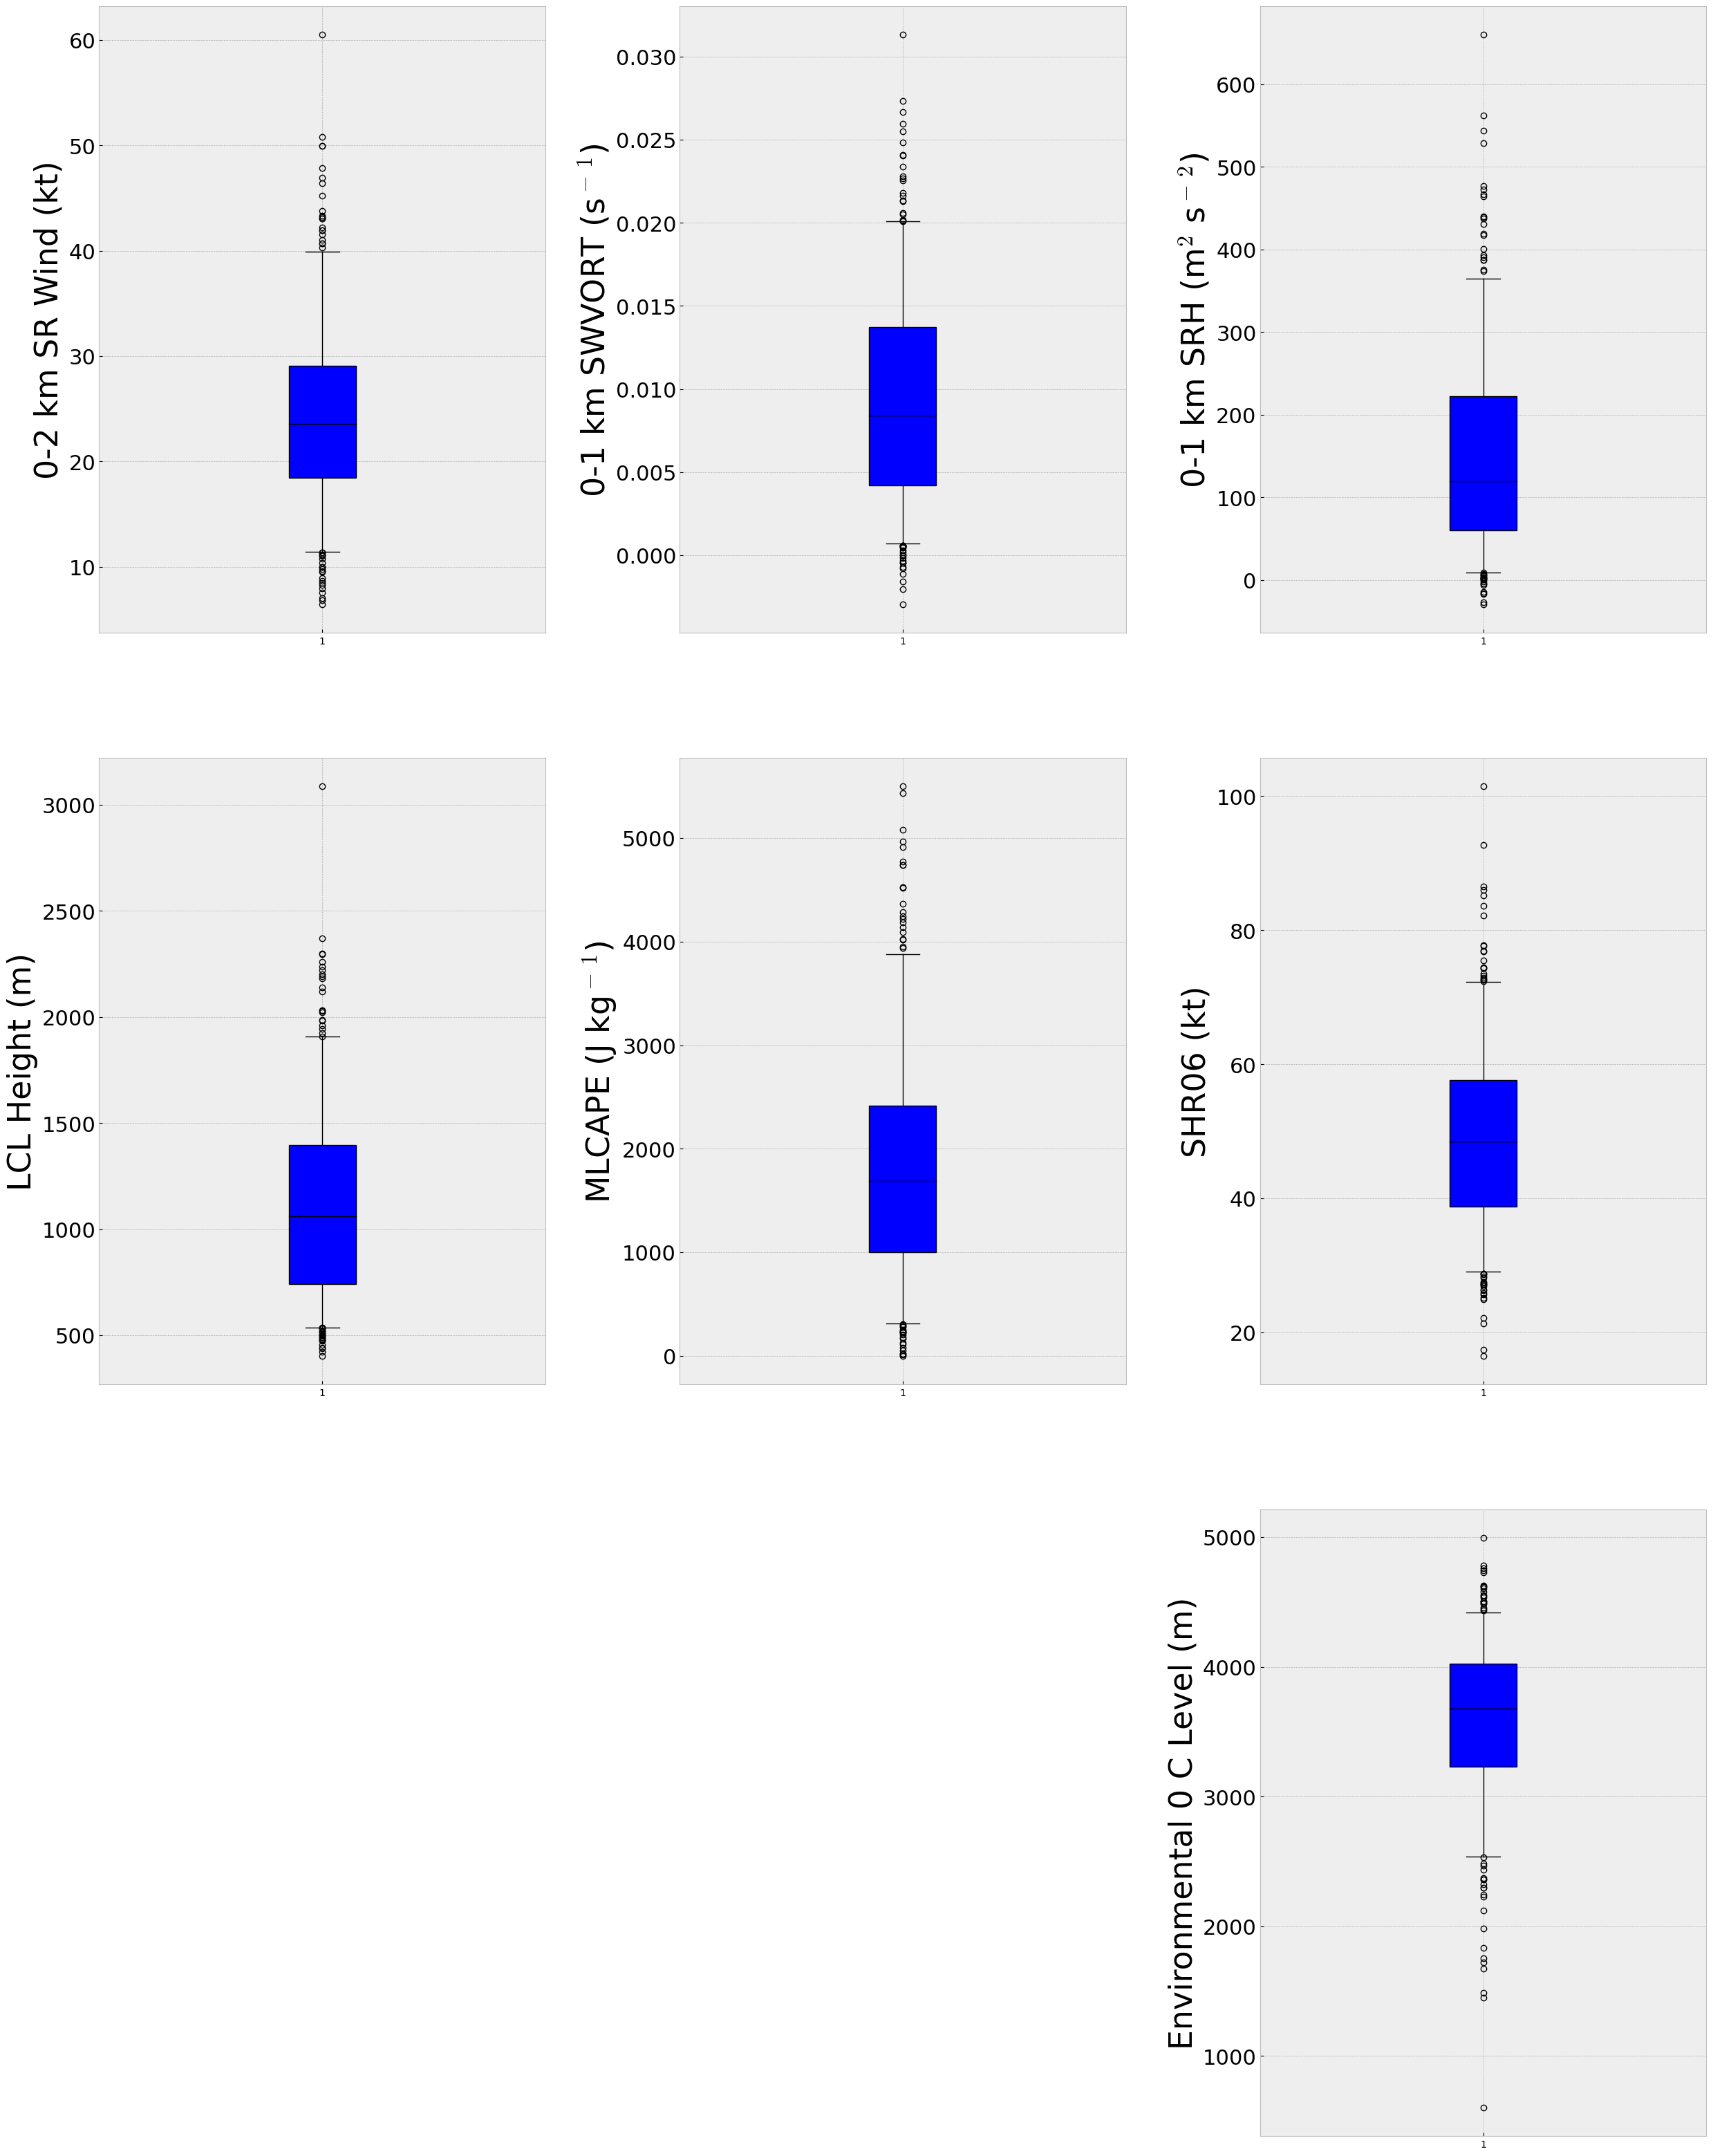

In [283]:
#Make a 2-panel figure
figure_layout = """
ABC
DEF
..G
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_layout, figsize=(30,40))

plt.sca(ax=axes['A'])
bplot=plt.boxplot(np.asarray(srw02_arr), whis=[5, 95], patch_artist=True, whiskerprops=dict(color='k'),
                 flierprops=dict(color='k', markeredgecolor='k'), capprops=dict(color='k'),
                  medianprops=dict(color='k'))
plt.yticks(size=22)
plt.ylabel('0-2 km SR Wind (kt)', size=33)

plt.sca(ax=axes['B'])
bplot=plt.boxplot(np.asarray(swvort1_arr), whis=[5, 95], patch_artist=True, whiskerprops=dict(color='k'),
                 flierprops=dict(color='k', markeredgecolor='k'), capprops=dict(color='k'),
                  medianprops=dict(color='k'))
plt.yticks(size=22)
plt.ylabel('0-1 km SWVORT (s$^-$$^1$)', size=33)

plt.sca(ax=axes['C'])
bplot=plt.boxplot(np.asarray(srh1_arr)[~np.isnan(np.asarray(srh1_arr))], whis=[5, 95], patch_artist=True, whiskerprops=dict(color='k'),
                 flierprops=dict(color='k', markeredgecolor='k'), capprops=dict(color='k'),
                  medianprops=dict(color='k'))
plt.yticks(size=22)
plt.ylabel('0-1 km SRH (m$^2$ s$^-$$^2$)', size=33)

plt.sca(ax=axes['D'])
bplot=plt.boxplot(np.asarray(lcl_arr)[~np.isnan(np.asarray(lcl_arr))], whis=[5, 95], patch_artist=True, whiskerprops=dict(color='k'),
                 flierprops=dict(color='k', markeredgecolor='k'), capprops=dict(color='k'),
                  medianprops=dict(color='k'))
plt.yticks(size=22)
plt.ylabel('LCL Height (m)', size=33)

plt.sca(ax=axes['E'])
bplot=plt.boxplot(np.asarray(mlcape_arr)[~np.isnan(np.asarray(mlcape_arr))], whis=[5, 95], patch_artist=True, whiskerprops=dict(color='k'),
                 flierprops=dict(color='k', markeredgecolor='k'), capprops=dict(color='k'),
                  medianprops=dict(color='k'))
plt.yticks(size=22)
plt.ylabel('MLCAPE (J kg$^-$$^1$)', size=33)

plt.sca(ax=axes['F'])
bplot=plt.boxplot(np.asarray(shr6_arr)[~np.isnan(np.asarray(shr6_arr))], whis=[5, 95], patch_artist=True, whiskerprops=dict(color='k'),
                 flierprops=dict(color='k', markeredgecolor='k'), capprops=dict(color='k'),
                  medianprops=dict(color='k'))
plt.yticks(size=22)
plt.ylabel('SHR06 (kt)', size=33)

plt.sca(ax=axes['G'])
bplot=plt.boxplot(np.asarray(Z0C_arr)[~np.isnan(np.asarray(Z0C_arr))], whis=[5, 95], patch_artist=True, whiskerprops=dict(color='k'),
                 flierprops=dict(color='k', markeredgecolor='k'), capprops=dict(color='k'),
                  medianprops=dict(color='k'))
plt.yticks(size=22)
plt.ylabel('Environmental 0 C Level (m)', size=33)

plt.subplots_adjust(wspace=+0.3)

plt.savefig('EnvironmentDist.png', bbox_inches='tight')

In [270]:
print(srh1_arr)

[240.57629481373107, 357.6713403447129, 223.57270266232194, 302.7913713759108, 219.39585891095, 102.17053638223454, 71.88707145981822, 109.55328283015416, 125.28163313722813, 146.43097774926798, 49.27951387105322, 312.30516680568337, 233.2181969916399, 123.47495556391164, 303.45240667570806, 84.92988841724146, 124.17764675043794, 235.795801066004, 227.29121803505274, 439.31120698027576, 285.40002158229385, 80.04148648210588, 301.360965448311, 118.49415732912499, 184.22286312319966, 186.3488371093386, 285.6722691264713, 375.88219911577255, 210.6115757192393, 81.30816172577269, 165.43751656687547, 256.4693862085778, 54.51296251551863, 185.2589686044689, 84.24256039759227, 49.58303067082698, 217.34207127887527, 13.922367595717974, 150.1911493921144, 220.99753067730984, 49.4127777410076, 159.4618735464329, 56.38464493920578, 186.8971440346083, 255.8953286222188, 349.2475001725566, 47.53643717495005, 103.9852775270542, 0.8085300196116236, 37.280243616705484, 361.953518590201, 437.1326698891